**Prepared by: Tim Hayes**

**Cohort: PGP-DSBA-UTA-AUG''22-A2**'

# Unsupervised Learning: Trade&Ahead

**Marks: 60**

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share 
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
# Libraries to help with reading and manipulating data
import math
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.manifold import TSNE

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
## Complete the code to import the data
data = pd.read_csv('stock_data.csv')
df = data.copy()

## Utility Graphical Functions

In [3]:
def output_pretty_boxplot(df, x, y=None, hue=None, figsize=None, title=None, order=None, rotate_x=False):
    '''Output a customized nice looking standardized boxplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :y: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default to nNone
        :figsize: The figure size tuple to use in the plot default is None
        :title: the title desired in the plot default is Boxplot: {x} vs {y}'
        :order: boxplot order default is none'
        :rotate_x: rotate x axis text default is false'
    ''' 
    # Use default figsize if not provided
    if (figsize is None):
        figsize=(10,3);      
        
    plt.figure(figsize=figsize);

    if (rotate_x):
        plt.xticks(rotation=45);
        
    if (title is None):
        title = 'Boxplot: {}'.format(x);
        
        if (y is not None):
            title += ' vs {}'.format(y);
            
        if (hue is not None):
            title += ' with a hue of {}'.format(hue);

    # Output boxplot with variables
    sns.boxplot(data=df,x=x, y=y, showmeans=True, hue=hue, order=order);

    plt.title(title);  
    plt.show();
    
def output_pretty_countplot(df, x, order=None, hue=None, figsize=None, title=None, re_orient=False):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    ''' 
    
    if (title is None):
        title = 'Countplot: for {}'.format(x)
    
        if (hue is not None):
            title += ' with hue of {}'.format(hue)
        
    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,3.5);
        
    plt.figure(figsize=figsize);
        
    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True
       
    # Ouput count plot
    if (re_orient):
        ax = sns.countplot(data=df,y=x,order=order,hue=hue);  
    else:
        ax = sns.countplot(data=df,x=x,order=order,hue=hue);  
        
    # output the amounts on top of the bars
    for p in ax.patches:
        if (re_orient):
            x = p.get_x() + p.get_width() + (p.get_width()*0.04) + .25
            y = p.get_y() + p.get_height()          
        else:
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height() + (p.get_height()*0.01)
            
        value = '{:.1f}'.format(p.get_height()) if re_orient == False else '{:.1f}'.format(p.get_width())
        
        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue
  
        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();
    
def output_pretty_barplot(df, x, y, order=None, hue=None, figsize=None, y_lim=None):
    '''Output a customized nice looking standardized barplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :y: The y axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :y_lim: Y axis limits by defaul is None
    ''' 
   
    title = 'Barplot of {} vs {}'.format(x, y)
    
    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,3.5);
        
    plt.figure(figsize=figsize);
    
    if (y_lim is not None):
        plt.ylim(y_lim)
        
    # Render the barplot
    ax = sns.barplot(x=x, y=y,hue=hue, data=df,errwidth=0, order=order)

    # iterate through the axes containers and add amount to bar
    for i in ax.containers:
        ax.bar_label(i,)
    
    plt.title(title);
    plt.xticks(rotation=90);

def output_pretty_numeric_plots(df, feature, title_suffix=''):
    '''Output a customized boxplot and histplot
    :df: DataFrame to use
    :feature: the feature to plot
    :title_suffix: title suffix to append, default is ''
    ''' 
    print(df[feature].describe())
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(data=df, x=feature, ax=ax_box,showmeans=True)
    sns.histplot(data=df, x=feature, kde=True, ax=ax_hist)

def output_pretty_scatterplot(df, x, y, alpha=0.7, palette='dark', hue=None, title=None, figsize=(10,5)):
    '''Output a customized nice looking standardized scatterplot
        :df: DataFrame to use
        :x: The x data to use in the plot
        :y: The y data to use in the plot in the plot
        :alpha: Alpha value to be used defaults to 0.7.
        :palette: Palette to be used defaults to dark
        :hue: Hue to employ default i None
        :title Title of plot default to None
        :figsize: The figure size tuple to use in the plot default is 15,3.5
    '''
    
    if (figsize is not None):
        plt.figure(figsize=figsize);
    
    ax = sns.scatterplot(data=df, x=x, y=y, hue=hue, palette=palette);

    if (title is None):
        title = 'Scatterplot: {} vs {}'.format(x,y)
        if (hue is not None):
                title += ' with hue of {}'.format(hue)
    
    plt.title(title);

## Utility Clustering Functions

In [4]:
def cluster_profiling(dataframe, segment_feature):
    ''' Output cluster profiling results for a dataframe
        :df: DataFrame to use
        :segment_feature: Feature name that holds the cluster identifiers
    '''
    ## Calculate the mean of the segment_feature
    cluster_profile = dataframe.groupby(segment_feature).mean()

    # Get the count for each cluster wrt to security
    cluster_profile["count_in_each_segment"] = (
        dataframe.groupby(segment_feature)["Security"].count().values)
   
    ## Calculate the mean of the segment_feature
    cluster_profile = dataframe.groupby(segment_feature).mean()

    # Get the count for each cluster wrt to security
    cluster_profile["count_in_each_segment"] = (
        dataframe.groupby(segment_feature)["Security"].count().values)
    
    cluster_profile['cluster%'] = (cluster_profile['count_in_each_segment'] \
                                   / cluster_profile['count_in_each_segment'].sum()) * 100
    cluster_profile
    
    ## Find the unique companies per cluster
    for cl in dataframe[segment_feature].unique():
        unique_companies = dataframe[dataframe[segment_feature] == cl]["Security"].unique()
        print("In cluster {}, there are {} total companies shown below:".format(cl, len(unique_companies)))
        print(unique_companies)
        print()

    print(dataframe.groupby([segment_feature, "GICS Sector"])[['Security']].count())
    
    plt.figure(figsize=(20, 20))
    plt.suptitle("Boxplot of numerical variables for each cluster")

    # selecting numerical columns
    num_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    
    # We do not need to boxplot segment_feature against itself
    num_cols.remove(segment_feature)
    
    nrows = math.ceil(len(num_cols)/4)
    for i, variable in enumerate(num_cols):
        plt.subplot(nrows, 4, i + 1)
        sns.boxplot(data=dataframe, x=segment_feature, y=variable, showmeans=True)

    plt.tight_layout(pad=2.0)
    plt.show()
    
    return cluster_profile

def create_elbow_plots(low, high, df):
    '''Output elbow plots for a dataframe
        :low: low k value to use
        :high: high k value to use
        :df: dataframe to use
    '''
    meanDistortions = []
    clusters=range(low, high)

    # Output mean distortion graph with kmeans along with hypertune parms
    for k in clusters:
        model = KMeans(n_clusters=k, n_init=100, max_iter=500, init='k-means++', random_state=1)
        prediction = model.fit_predict(df)
        distortion = (sum(np.min(cdist(df, model.cluster_centers_, "euclidean"), axis=1))
                        / df.shape[0])

        meanDistortions.append(distortion)

        print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

    plt.plot(clusters, meanDistortions, "bx-");
    plt.xlabel("k");
    plt.ylabel("Average Distortion");
    plt.title("Selecting k with the Elbow Method", fontsize=12);
    plt.show();
    
    # Output elbow plot kmeans along with hypertune parms
    model = KMeans(n_init=100, max_iter=500, init='k-means++', random_state=1)
    visualizer = KElbowVisualizer(model, k=(low, high), timings=True)
    visualizer.fit(df)  # fit the data to the visualizer
    visualizer.show();  # finalize and render figure
    
def create_silhouette_plots(low, high, df):
    '''Output silhouette plots for a dataframe
        :low: low k value to use
        :high: high k value to use
        :df: dataframe to use
    '''
    sil_score = []
    cluster_list = range(low,high)
    
    # Output silhouette score for each k
    for n_clusters in cluster_list:
        clusterer = KMeans(n_clusters=n_clusters, n_init=100, max_iter=500, init='k-means++', random_state=1)
        preds = clusterer.fit_predict(df)
        score = silhouette_score(df, preds)
        sil_score.append(score)
        print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))
    
    plt.plot(cluster_list, sil_score)
    plt.show();

    model = KMeans(n_init=100, max_iter=500, init='k-means++', random_state=1)
    visualizer = KElbowVisualizer(model, k=(low, high), metric="silhouette", timings=True)
    visualizer.fit(df)  # fit the data to the visualizer
    visualizer.show();  # finalize and render figure
    
    for n_clusters in list(range(3, 11)):
        # finding optimal no. of clusters with silhouette coefficients
        visualizer = SilhouetteVisualizer(KMeans(n_clusters=n_clusters, n_init=100, max_iter=500, \
                                                  init='k-means++', random_state=1))
        
        visualizer.fit(df)
        visualizer.show();
           
def calculate_cophenetic_correlation(dataframe):
    '''Calculate cophenetic_correlation for a dataframe
        :datarame: DataFrame to use
    '''
    # list of distance metrics
    distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

    # list of linkage methods
    linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

    high_cophenet_corr = 0
    high_dm_lm = [0, 0]

    for dm in distance_metrics:
        for lm in linkage_methods:

            # Only euclidean distance can apply to ward or centroid linkages
            if ((lm == 'ward' or lm == 'centroid') and dm != 'euclidean'):
                continue

            Z = linkage(dataframe, metric=dm, method=lm)
            c, coph_dists = cophenet(Z, pdist(dataframe))
            print(
                "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                    dm.capitalize(), lm, c
                )
            )
            if high_cophenet_corr < c:
                high_cophenet_corr = c
                high_dm_lm[0] = dm
                high_dm_lm[1] = lm

    # printing the combination of distance metric and linkage method with the highest cophenetic correlation
    print('*'*100)
    print(
        "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
            high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
        )
    )
    
def output_dendrograms(dataframe):
    '''Output a dendrograms for a dataframe
        :dataframe: DataFrame to use
    '''
    # list of linkage methods
    linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

    # lists to save results of cophenetic correlation calculation
    compare_cols = ["Linkage", "Cophenetic Coefficient"]
    compare = []

    # to create a subplot image
    fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

    # We will enumerate through the list of linkage methods above
    # For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
    for i, method in enumerate(linkage_methods):
        Z = linkage(dataframe, metric="euclidean", method=method)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

        coph_corr, coph_dist = cophenet(Z, pdist(dataframe))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )

        compare.append([method, coph_corr])
        
    return compare, compare_cols

## Data Overview

- Observations
- Sanity checks

In [5]:
df.head()

Ticker Symbol                 Security             GICS Sector  \
0           AAL  American Airlines Group             Industrials   
1          ABBV                   AbbVie             Health Care   
2           ABT      Abbott Laboratories             Health Care   
3          ADBE        Adobe Systems Inc  Information Technology   
4           ADI     Analog Devices, Inc.  Information Technology   

       GICS Sub Industry  Current Price  Price Change  Volatility  ROE  \
0               Airlines      42.349998      9.999995    1.687151  135   
1        Pharmaceuticals      59.240002      8.339433    2.197887  130   
2  Health Care Equipment      44.910000     11.301121    1.273646   21   
3   Application Software      93.940002     13.977195    1.357679    9   
4         Semiconductors      55.320000     -1.827858    1.701169   14   

   Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
0          51     -604000000  7610000000               11.39   
1          77       51000000  5144000000                3.15   
2          67      938000000  4423000000                2.94   
3         180     -240840000   629551000                1.26   
4         272      315120000   696878000                0.31   

   Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
0                  6.681299e+08    3.718174  -8.784219  
1                  1.633016e+09   18.806350  -8.750068  
2                  1.504422e+09   15.275510  -0.394171  
3                  4.996437e+08   74.555557   4.199651  
4                  2.247994e+09  178.451613   1.059810

In [6]:
df.tail()

Ticker Symbol                Security             GICS Sector  \
335          YHOO              Yahoo Inc.  Information Technology   
336           YUM         Yum! Brands Inc  Consumer Discretionary   
337           ZBH  Zimmer Biomet Holdings             Health Care   
338          ZION           Zions Bancorp              Financials   
339           ZTS                  Zoetis             Health Care   

                GICS Sub Industry  Current Price  Price Change  Volatility  \
335  Internet Software & Services      33.259998     14.887727    1.845149   
336                   Restaurants      52.516175     -8.698917    1.478877   
337         Health Care Equipment     102.589996      9.347683    1.404206   
338                Regional Banks      27.299999     -1.158588    1.468176   
339               Pharmaceuticals      47.919998     16.678836    1.610285   

     ROE  Cash Ratio  Net Cash Flow  Net Income  Earnings Per Share  \
335   15         459    -1032187000 -4359082000               -4.64   
336  142          27      159000000  1293000000                2.97   
337    1         100      376000000   147000000                0.78   
338    4          99      -43623000   309471000                1.20   
339   32          65      272000000   339000000                0.68   

     Estimated Shares Outstanding   P/E Ratio  P/B Ratio  
335                   939457327.6   28.976191   6.261775  
336                   435353535.4   17.682214  -3.838260  
337                   188461538.5  131.525636 -23.884449  
338                   257892500.0   22.749999  -0.063096  
339                   498529411.8   70.470585   1.723068

In [7]:
# viewing a random sample of the dataset
df.sample(n=10, random_state=1)

Ticker Symbol                     Security             GICS Sector  \
102           DVN           Devon Energy Corp.                  Energy   
125            FB                     Facebook  Information Technology   
11            AIV  Apartment Investment & Mgmt             Real Estate   
248            PG             Procter & Gamble        Consumer Staples   
238           OXY         Occidental Petroleum                  Energy   
336           YUM              Yum! Brands Inc  Consumer Discretionary   
112           EQT              EQT Corporation                  Energy   
147           HAL              Halliburton Co.                  Energy   
89            DFS  Discover Financial Services              Financials   
173           IVZ                 Invesco Ltd.              Financials   

                      GICS Sub Industry  Current Price  Price Change  \
102  Oil & Gas Exploration & Production      32.000000    -15.478079   
125        Internet Software & Services     104.660004     16.224320   
11                                REITs      40.029999      7.578608   
248                   Personal Products      79.410004     10.660538   
238  Oil & Gas Exploration & Production      67.610001      0.865287   
336                         Restaurants      52.516175     -8.698917   
112  Oil & Gas Exploration & Production      52.130001    -21.253771   
147      Oil & Gas Equipment & Services      34.040001     -5.101751   
89                     Consumer Finance      53.619999      3.653584   
173    Asset Management & Custody Banks      33.480000      7.067477   

     Volatility  ROE  Cash Ratio  Net Cash Flow   Net Income  \
102    2.923698  205          70      830000000 -14454000000   
125    1.320606    8         958      592000000   3669000000   
11     1.163334   15          47       21818000    248710000   
248    0.806056   17         129      160383000    636056000   
238    1.589520   32          64     -588000000  -7829000000   
336    1.478877  142          27      159000000   1293000000   
112    2.364883    2         201      523803000     85171000   
147    1.966062    4         189     7786000000   -671000000   
89     1.159897   20          99     2288000000   2297000000   
173    1.580839   12          67      412000000    968100000   

     Earnings Per Share  Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
102              -35.55                  4.065823e+08  93.089287   1.785616  
125                1.31                  2.800763e+09  79.893133   5.884467  
11                 1.52                  1.636250e+08  26.335526  -1.269332  
248                3.28                  4.913916e+08  24.070121  -2.256747  
238              -10.23                  7.652981e+08  93.089287   3.345102  
336                2.97                  4.353535e+08  17.682214  -3.838260  
112                0.56                  1.520911e+08  93.089287   9.567952  
147               -0.79                  8.493671e+08  93.089287  17.345857  
89                 5.14                  4.468872e+08  10.431906  -0.375934  
173                2.26                  4.283628e+08  14.814159   4.218620

#### Observations
- No nulls appear in any of the columns
- Ticker Symbol, Security, GICS Sector and GICS Sub Industry all appear to be categorical columns.
- ROE, Cash Ratio, Net Cash Flow and Net Income appear to be integer columns.
- All the other columns appear to be float columns.
- Negative values are observed in the Price Change, Net Cash Flow, Net Income and P/B Ratio columns.

In [8]:
df.shape

(340, 15)

#### Observations
- There are 340 rows and 15 columns in the dataset.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

#### Observations
- There are four object columns, four integer columns and seven float columns.

In [10]:
# Check for missing values
df.isnull().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

#### Observations
- There are no missing values in the dataset.

In [11]:
# See if we have an duplicated data
print('Rows of duplicated data in the dataset {}'.format(df.duplicated().sum()))

Rows of duplicated data in the dataset 0


#### Observations
- There are no rows of duplicated data in the dataset.

In [12]:
# Use describe() to get a statistical summary
df.describe().T

count          mean           std           min  \
Current Price                 340.0  8.086234e+01  9.805509e+01  4.500000e+00   
Price Change                  340.0  4.078194e+00  1.200634e+01 -4.712969e+01   
Volatility                    340.0  1.525976e+00  5.917984e-01  7.331632e-01   
ROE                           340.0  3.959706e+01  9.654754e+01  1.000000e+00   
Cash Ratio                    340.0  7.002353e+01  9.042133e+01  0.000000e+00   
Net Cash Flow                 340.0  5.553762e+07  1.946365e+09 -1.120800e+10   
Net Income                    340.0  1.494385e+09  3.940150e+09 -2.352800e+10   
Earnings Per Share            340.0  2.776662e+00  6.587779e+00 -6.120000e+01   
Estimated Shares Outstanding  340.0  5.770283e+08  8.458496e+08  2.767216e+07   
P/E Ratio                     340.0  3.261256e+01  4.434873e+01  2.935451e+00   
P/B Ratio                     340.0 -1.718249e+00  1.396691e+01 -7.611908e+01   

                                       25%           50%           75%  \
Current Price                 3.855500e+01  5.970500e+01  9.288000e+01   
Price Change                 -9.394838e-01  4.819505e+00  1.069549e+01   
Volatility                    1.134878e+00  1.385593e+00  1.695549e+00   
ROE                           9.750000e+00  1.500000e+01  2.700000e+01   
Cash Ratio                    1.800000e+01  4.700000e+01  9.900000e+01   
Net Cash Flow                -1.939065e+08  2.098000e+06  1.698108e+08   
Net Income                    3.523012e+08  7.073360e+08  1.899000e+09   
Earnings Per Share            1.557500e+00  2.895000e+00  4.620000e+00   
Estimated Shares Outstanding  1.588482e+08  3.096751e+08  5.731175e+08   
P/E Ratio                     1.504465e+01  2.081988e+01  3.176476e+01   
P/B Ratio                    -4.352056e+00 -1.067170e+00  3.917066e+00   

                                       max  
Current Price                 1.274950e+03  
Price Change                  5.505168e+01  
Volatility                    4.580042e+00  
ROE                           9.170000e+02  
Cash Ratio                    9.580000e+02  
Net Cash Flow                 2.076400e+10  
Net Income                    2.444200e+10  
Earnings Per Share            5.009000e+01  
Estimated Shares Outstanding  6.159292e+09  
P/E Ratio                     5.280391e+02  
P/B Ratio                     1.290646e+02

#### Observations
- Min value for Current Price is 4.500 and max is 1274.950
- Mean for Current Price is 80.862 which is greater than the median indicating the data is right skewed.


- Min value for Price Change is -47.130 and max is 55.052
- Mean for Price Change is 4.078 which is less than the median indicating the data is left skewed.


- Min value for Volatility is 0.733 and max is 4.580
- Mean for Volatility is 1.526 which is greater than the median indicating the data is right skewed.


- Min value for ROE is 1.000 and max is 917.000
- Mean for ROE is 39.597 which is greater than the median indicating the data is right skewed.


- Min value for Cash Ratio is 0.000 and max is 958.000
- Mean for Cash Ratio is 70.024 which is greater than the median indicating the data is right skewed.


- Min value for Net Cash Flow is -11208000000.000 and max is 20764000000.000
- Mean for Net Cash Flow is 55537620.588 which is greater than the median indicating the data is right skewed.


- Min value for Net Income is -23528000000.000 and max is 24442000000.000
- Mean for Net Income is 1494384602.941 which is greater than the median indicating the data is right skewed.


- Min value for Earnings Per Share is -61.200 and max is 50.090
- Mean for Earnings Per Share is 2.777 which is less than the median indicating the data is left skewed.


- Min value for Estimated Shares Outstanding is 27672156.860 and max is 6159292035.000
- Mean for Estimated Shares Outstanding is 577028337.754 which is greater than the median indicating the data is right skewed.


- Min value for P/E Ratio is 2.935 and max is 528.039
- Mean for P/E Ratio is 32.613 which is greater than the median indicating the data is right skewed.


- Min value for P/B Ratio is -76.119 and max is 129.065
- Mean for P/B Ratio is -1.718 which is less than the median indicating the data is left skewed.


- Min value for GICS Sector_Consumer Discretionary is 0.000 and max is 1.000
- Mean for GICS Sector_Consumer Discretionary is 0.118 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Consumer Staples is 0.000 and max is 1.000
- Mean for GICS Sector_Consumer Staples is 0.056 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Energy is 0.000 and max is 1.000
- Mean for GICS Sector_Energy is 0.088 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Financials is 0.000 and max is 1.000
- Mean for GICS Sector_Financials is 0.144 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Health Care is 0.000 and max is 1.000
- Mean for GICS Sector_Health Care is 0.118 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Industrials is 0.000 and max is 1.000
- Mean for GICS Sector_Industrials is 0.156 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Information Technology is 0.000 and max is 1.000
- Mean for GICS Sector_Information Technology is 0.097 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Materials is 0.000 and max is 1.000
- Mean for GICS Sector_Materials is 0.059 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Real Estate is 0.000 and max is 1.000
- Mean for GICS Sector_Real Estate is 0.079 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Telecommunications Services is 0.000 and max is 1.000
- Mean for GICS Sector_Telecommunications Services is 0.015 which is greater than the median indicating the data is right skewed.


- Min value for GICS Sector_Utilities is 0.000 and max is 1.000
- Mean for GICS Sector_Utilities is 0.071 which is greater than the median indicating the data is right skewed.

In [13]:
# Use describe() to get a statistical summary
df.describe(include=object).T

count unique                                 top freq
Ticker Symbol       340    340                                 AAL    1
Security            340    340             American Airlines Group    1
GICS Sector         340     11                         Industrials   53
GICS Sub Industry   340    104  Oil & Gas Exploration & Production   16

#### Observations
- All the Ticker Symbols and Securities are unique.
- The most common GICS Sector is Industrials.
- The most common GICS Sub Industry is Oil & Gas Exploration & Production.

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What does the distribution of stock prices look like?
2. The stocks of which economic sector have seen the maximum price increase on average?
3. How are the different variables correlated with each other?
4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?
5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

In [14]:
# Output counts for categorical columns
for column in  df.select_dtypes("object").columns:
    print('{}\n'.format(df[column].value_counts()))

AAL     1
NEE     1
NUE     1
NTRS    1
NSC     1
       ..
EQR     1
EQIX    1
EOG     1
EMN     1
ZTS     1
Name: Ticker Symbol, Length: 340, dtype: int64

American Airlines Group    1
NextEra Energy             1
Nucor Corp.                1
Northern Trust Corp.       1
Norfolk Southern Corp.     1
                          ..
Equity Residential         1
Equinix                    1
EOG Resources              1
Eastman Chemical           1
Zoetis                     1
Name: Security, Length: 340, dtype: int64

Industrials                    53
Financials                     49
Health Care                    40
Consumer Discretionary         40
Information Technology         33
Energy                         30
Real Estate                    27
Utilities                      24
Materials                      20
Consumer Staples               19
Telecommunications Services     5
Name: GICS Sector, dtype: int64

Oil & Gas Exploration & Production                 16
REITs              

#### Observations
- Security and Ticker symbol are unique in the dataset.
- There are eleven GICS Sector's with Industrials, Financials and Health Care occupying the top three spots.
- There are 104 unique GICS Sub Industries and the top three are Oil & Gas Exploration & Production, REITs and Industrial Conglomerates.
- 96 of the GICS Sub Industries have fewer than 10 companies.

### Outlier Detection 

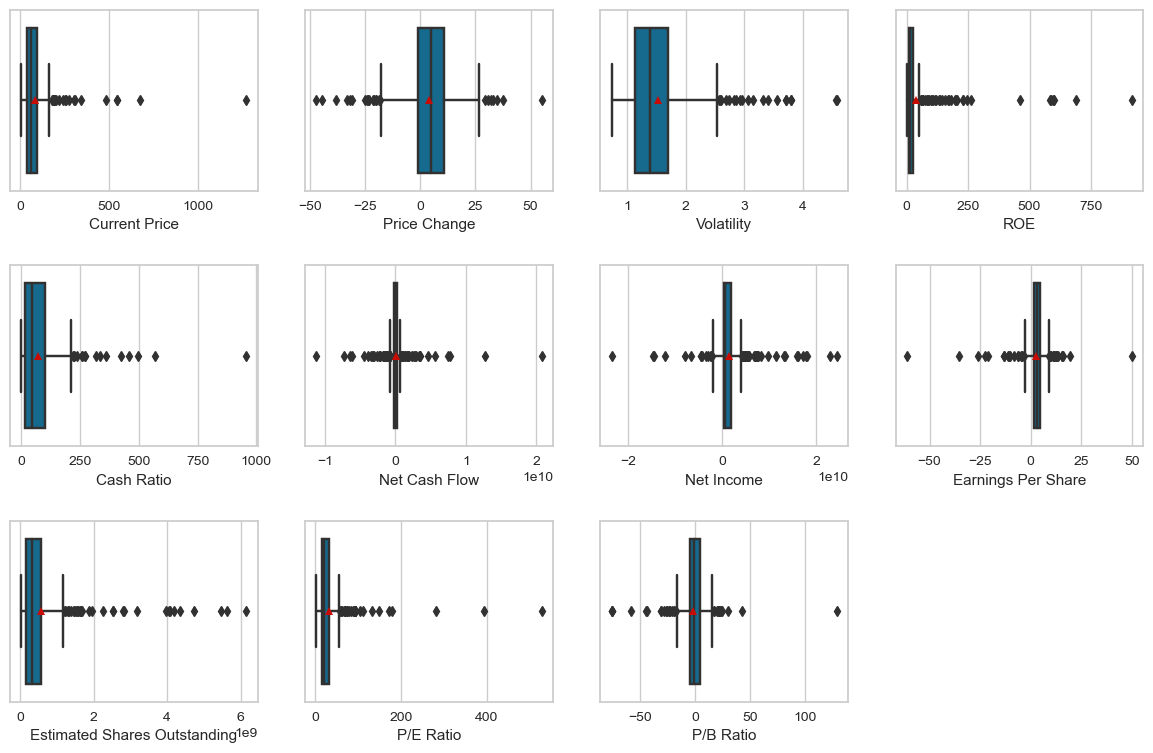

In [15]:
# outlier detection using boxplot
num_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12,8))

nrows = math.ceil(len(num_cols)/4)
for i, variable in enumerate(num_cols):
    plt.subplot(nrows, 4, i + 1)
    sns.boxplot(data=df, x=variable, showmeans=True)
    plt.tight_layout(pad=2)

plt.show();

#### Observations
- There are outliers for all numerical columns. The outliers look reasonable and we have no indication that they are questionable or erroneous. 

### Univariate Analysis

#### Let's investigate Price Change

count    340.000000
mean       4.078194
std       12.006338
min      -47.129693
25%       -0.939484
50%        4.819505
75%       10.695493
max       55.051683
Name: Price Change, dtype: float64


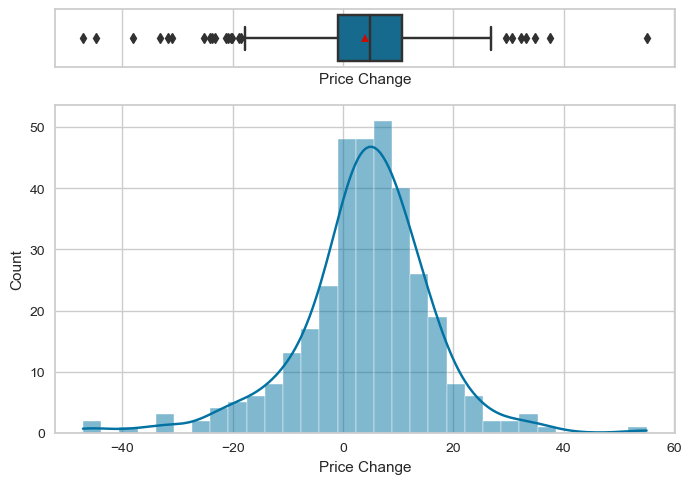

In [16]:
# Boxplot and Histplot for Price Change
describe_df = output_pretty_numeric_plots(df, 'Price Change')

#### Observations
- The minimum for Price Change is -47.12 while the maximum is 55.05
- The mean Price Change is 4.07 which is less than the median indicating a left skew.

#### Let's investigate Volatility

count    340.000000
mean       1.525976
std        0.591798
min        0.733163
25%        1.134878
50%        1.385593
75%        1.695549
max        4.580042
Name: Volatility, dtype: float64


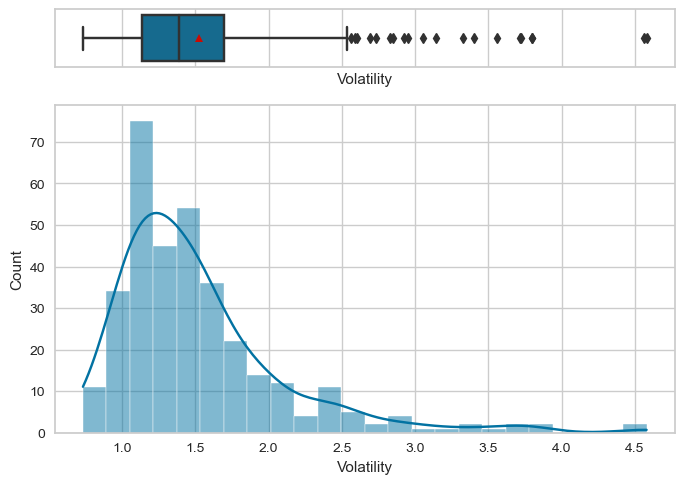

In [17]:
# Boxplot and Histplot for Volatility
output_pretty_numeric_plots(df, 'Volatility')

#### Observations
- The minimum for Volatility is .73 while the maximum is 4.5.
- The mean Volatility is 1.52 which is greater than the median indicating a right skew.

#### Let's investigate ROE

count    340.000000
mean      39.597059
std       96.547538
min        1.000000
25%        9.750000
50%       15.000000
75%       27.000000
max      917.000000
Name: ROE, dtype: float64


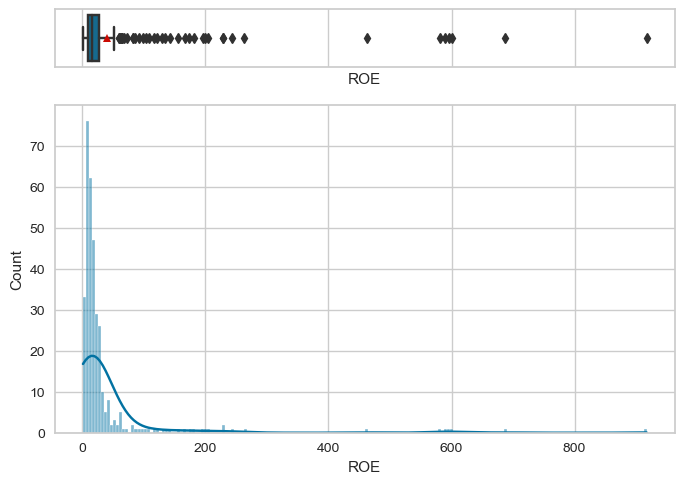

In [18]:
# Boxplot and Histplot for ROE
output_pretty_numeric_plots(df, 'ROE')

#### Observations
- The minimum for ROE is 1 while the maximum is 917.
- The mean ROE is 39.59 which is greater than the median indicating a right skew.

#### Let's investigate Cash Ratio

count    340.000000
mean      70.023529
std       90.421331
min        0.000000
25%       18.000000
50%       47.000000
75%       99.000000
max      958.000000
Name: Cash Ratio, dtype: float64


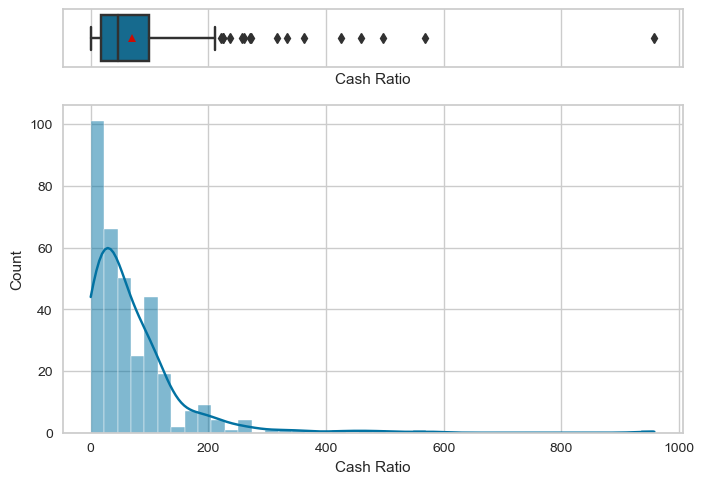

In [19]:
# Boxplot and Histplot for Cash Ratio
output_pretty_numeric_plots(df, 'Cash Ratio')

#### Observations
- The minimum for Cash Ratio is 0 while the maximum is 958.
- The mean Cash Ratio is 70.02 which is greater than the median indicating a right skew.

### Let's investigate  Net Cash Flow

count    3.400000e+02
mean     5.553762e+07
std      1.946365e+09
min     -1.120800e+10
25%     -1.939065e+08
50%      2.098000e+06
75%      1.698108e+08
max      2.076400e+10
Name: Net Cash Flow, dtype: float64


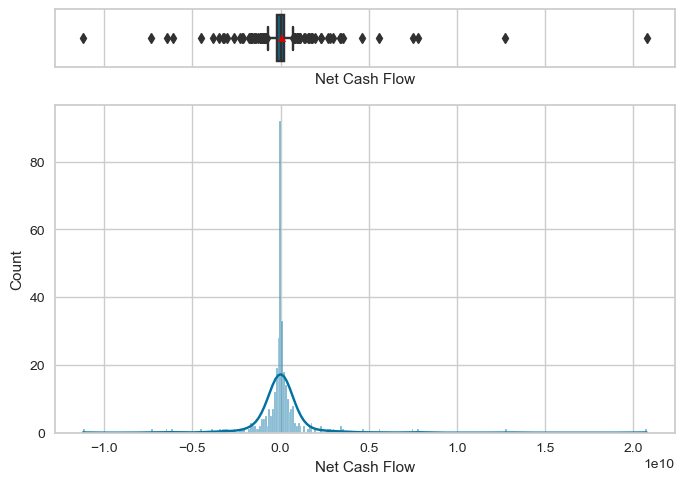

In [20]:
# Boxplot and Histplot for Net Cash Flow
output_pretty_numeric_plots(df, 'Net Cash Flow')

#### Observations
- The minimum for Net Cash Flow is -1.120800e+10 while the maximum is 2.076400e+10.
- The mean Net Cash Flow is 5.553762e+07 which is greater than the median indicating a right skew.

#### Let's investigate Net Income

count    3.400000e+02
mean     1.494385e+09
std      3.940150e+09
min     -2.352800e+10
25%      3.523012e+08
50%      7.073360e+08
75%      1.899000e+09
max      2.444200e+10
Name: Net Income, dtype: float64


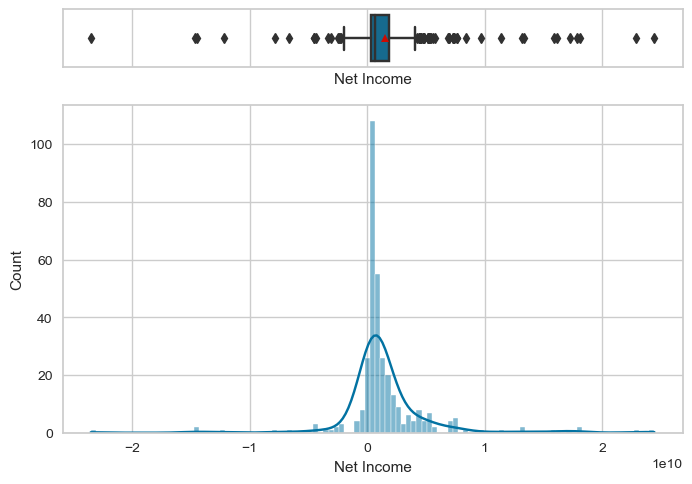

In [21]:
# Boxplot and Histplot for Net Income
output_pretty_numeric_plots(df, 'Net Income')

#### Observations
- The minimum for Net Income is -2.352800e+10 while the maximum is 2.444200e+10.
- The mean Net Income is 1.494385e+09 which is greater than the median indicating a right skew.

#### Let's investigate Earnings Per Share

count    340.000000
mean       2.776662
std        6.587779
min      -61.200000
25%        1.557500
50%        2.895000
75%        4.620000
max       50.090000
Name: Earnings Per Share, dtype: float64


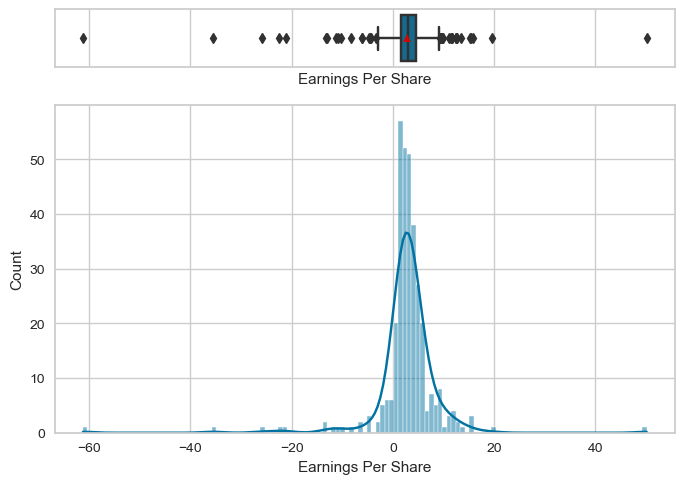

In [22]:
# Boxplot and Histplot for Earnings Per Share
output_pretty_numeric_plots(df, 'Earnings Per Share')

#### Observations
- The minimum for Earnings Per Share is -61.2 while the maximum is 50.09.
- The mean Earnings Per Share is 2.776662 which is less than the median indicating a left skew.

#### Let's investigate Estimated Shares Outstanding

count    3.400000e+02
mean     5.770283e+08
std      8.458496e+08
min      2.767216e+07
25%      1.588482e+08
50%      3.096751e+08
75%      5.731175e+08
max      6.159292e+09
Name: Estimated Shares Outstanding, dtype: float64


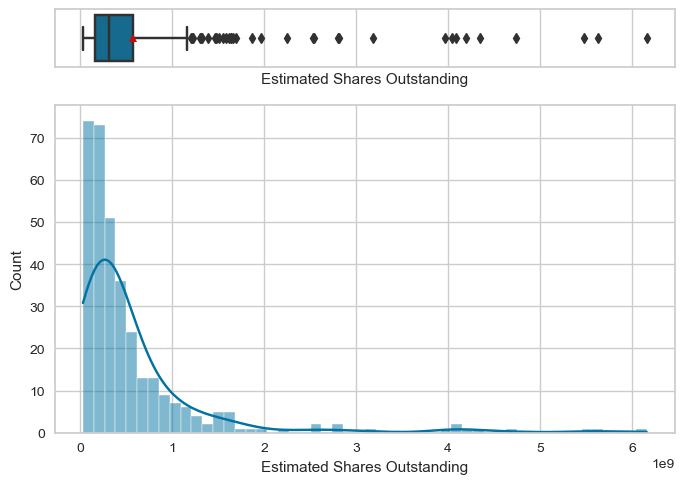

In [23]:
# Boxplot and Histplot for Estimated Shares Outstanding
output_pretty_numeric_plots(df, 'Estimated Shares Outstanding')

#### Observations
- The minimum for Estimated Shares Outstanding is 2.767216e+07 while the maximum is 6.159292e+09.
- The mean Estimated Shares Outstanding is 5.770283e+08 which is greater than the median indicating a right skew.

#### Let's investigate P/E Ratio

count    340.000000
mean      32.612563
std       44.348731
min        2.935451
25%       15.044653
50%       20.819876
75%       31.764755
max      528.039074
Name: P/E Ratio, dtype: float64


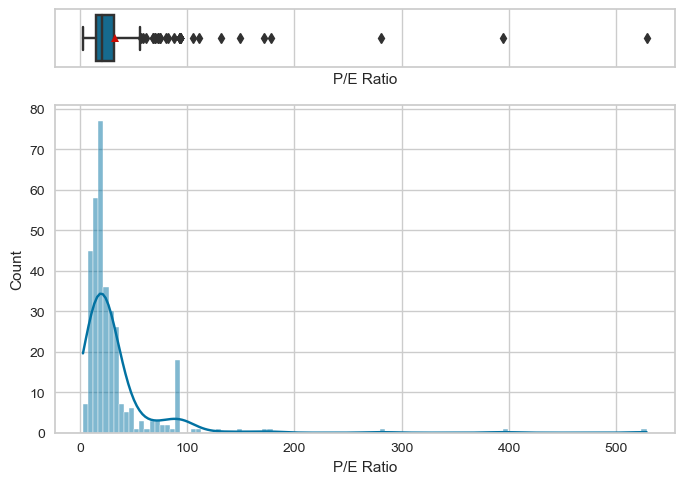

In [24]:
# Boxplot and Histplot for P/E Ratio
output_pretty_numeric_plots(df, 'P/E Ratio')

#### Observations
- The minimum for P/E Ratio 2.93 while the maximum is 528.03.
- The mean P/E Ratio is 32.612563 which is greater than the median indicating a right skew.

#### Let's investigate P/B Ratio

count    340.000000
mean      -1.718249
std       13.966912
min      -76.119077
25%       -4.352056
50%       -1.067170
75%        3.917066
max      129.064585
Name: P/B Ratio, dtype: float64


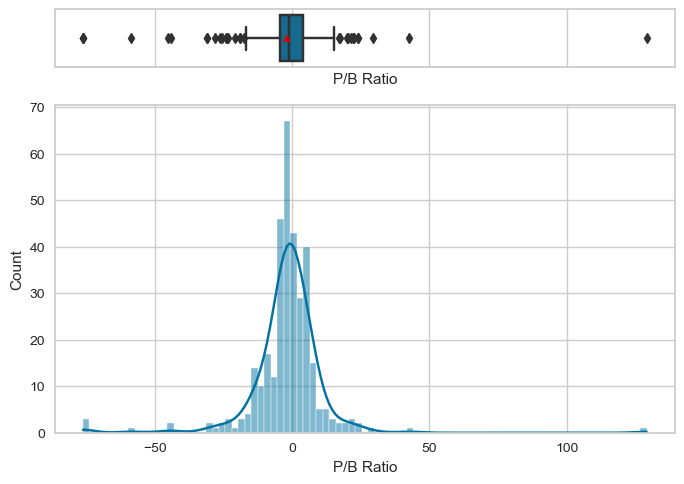

In [25]:
# Boxplot and Histplot for P/B Ratio
output_pretty_numeric_plots(df, 'P/B Ratio')

#### Observations
- The minimum for P/B Ratio -76.119077 while the maximum is 129.06.
- The mean P/B Ratio is -1.718249 which is less than the median indicating a left skew.

#### Let's investigate GICS Sector

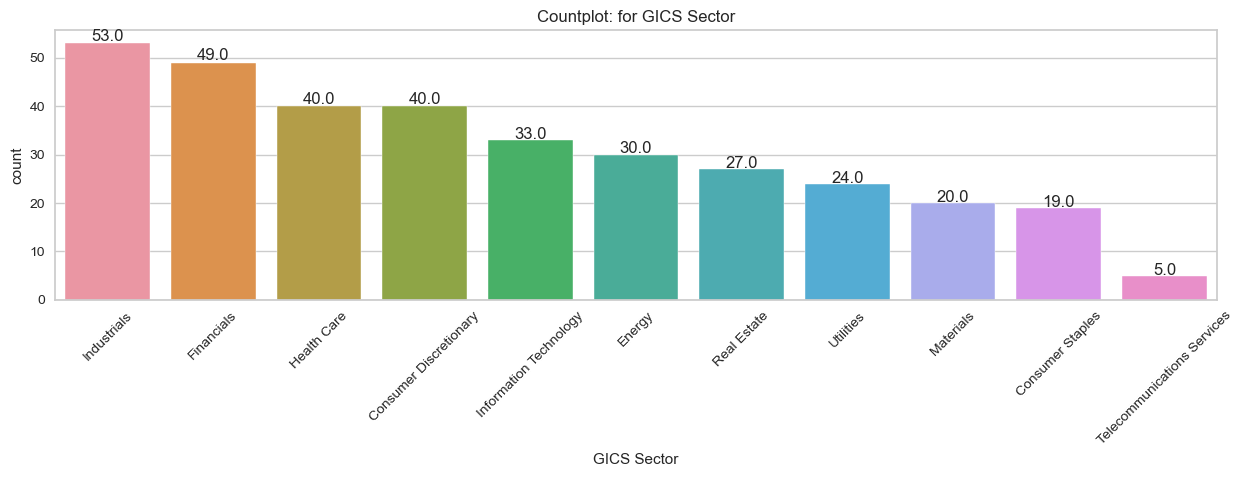

Industrials                    0.155882
Financials                     0.144118
Health Care                    0.117647
Consumer Discretionary         0.117647
Information Technology         0.097059
Energy                         0.088235
Real Estate                    0.079412
Utilities                      0.070588
Materials                      0.058824
Consumer Staples               0.055882
Telecommunications Services    0.014706
Name: GICS Sector, dtype: float64

In [26]:
# Countplot for GICS Sector
feature = 'GICS Sector'
output_pretty_countplot(df, feature, \
                        order=df[feature].value_counts().index)
df[feature].value_counts(normalize=True)

#### Observations
- The top GICS sector is Industrials which comprise 15.5% of the companies in the dataset.
- The top three GICS Sector's are Industrials, Finanicals and Health Care.
- The smallest GICS Sector is Telecommunication Services which comprises only 1.4% of the companies.

#### Let's investigate GICS Sub Industry

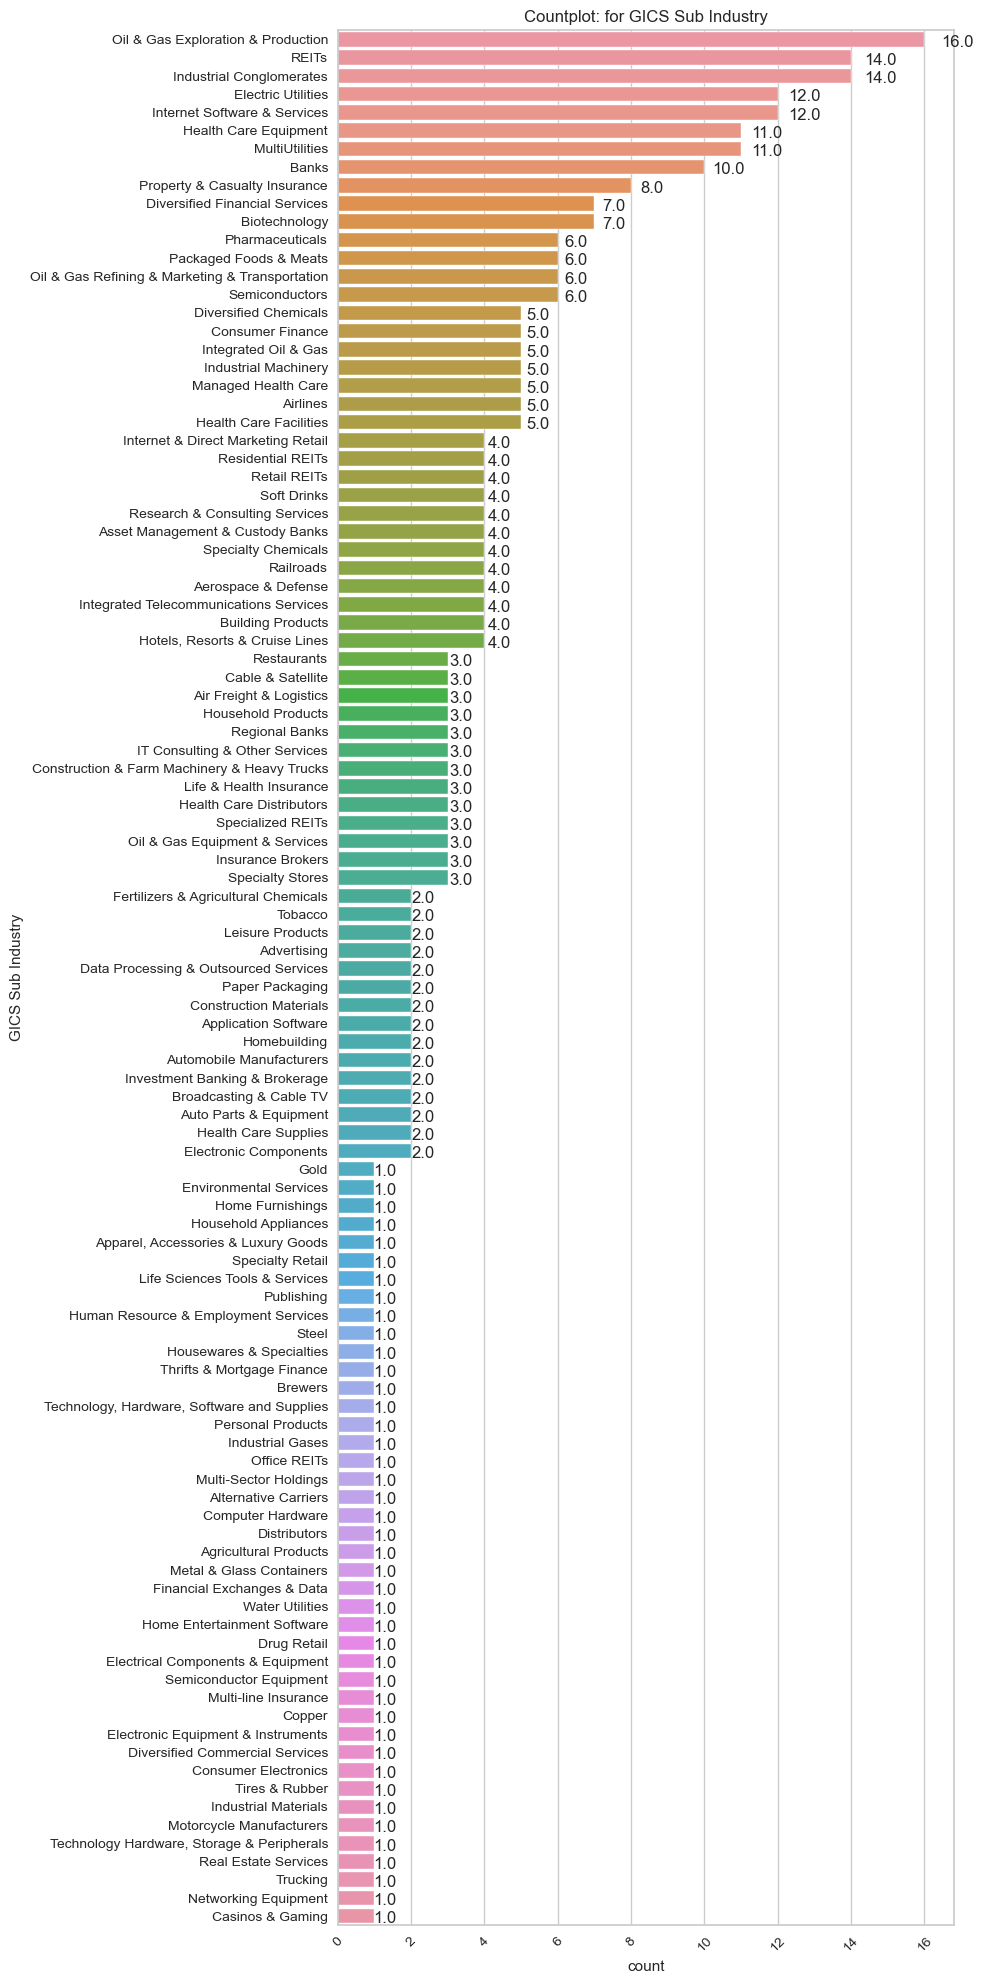

Oil & Gas Exploration & Production                 0.047059
REITs                                              0.041176
Industrial Conglomerates                           0.041176
Electric Utilities                                 0.035294
Internet Software & Services                       0.035294
Health Care Equipment                              0.032353
MultiUtilities                                     0.032353
Banks                                              0.029412
Property & Casualty Insurance                      0.023529
Diversified Financial Services                     0.020588
Biotechnology                                      0.020588
Pharmaceuticals                                    0.017647
Packaged Foods & Meats                             0.017647
Oil & Gas Refining & Marketing & Transportation    0.017647
Semiconductors                                     0.017647
Diversified Chemicals                              0.014706
Consumer Finance                        

In [27]:
# Countplot for GICS Sub Industry
feature = 'GICS Sub Industry'
output_pretty_countplot(df, feature, \
                        order=df[feature].value_counts().index,\
                       figsize=(10,20), re_orient=True)
df[feature].value_counts(normalize=True)

#### Observations
- The top GICS Sub Industry is Oil & Gas Exploration & Production which comprise 4.7% of the companies in the dataset.
- The top three GICS Sub Industries are Oil & Gas Exploration & Production, REITs                                          and Industrial Conglomerates.
- The smallest GICS Sub Industry is Casino and Gambling which comprises only .29% of the companies.

**Leading Questions**:

### 1. What does the distribution of stock prices look like?

count     340.000000
mean       80.862345
std        98.055086
min         4.500000
25%        38.555000
50%        59.705000
75%        92.880001
max      1274.949951
Name: Current Price, dtype: float64


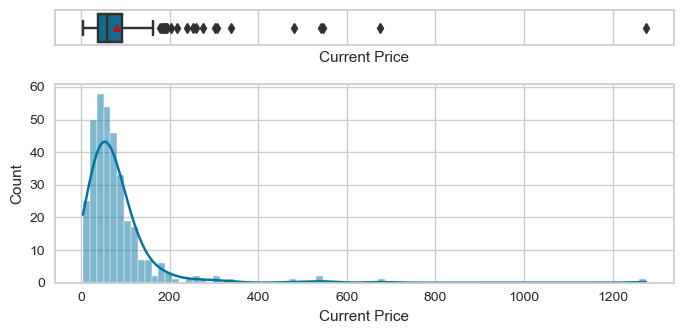

In [28]:
# Boxplot and Histplot for Current Price
output_pretty_numeric_plots(df, 'Current Price')

#### Observations
- The minimum Current Price for stocks is 4.5 while the maximum is 1274.94.
- The mean for Current Price is 80.86 which is greater than the median indicating the data is skewed right.

### 2. The stocks of which economic sector have seen the maximum price increase on average?

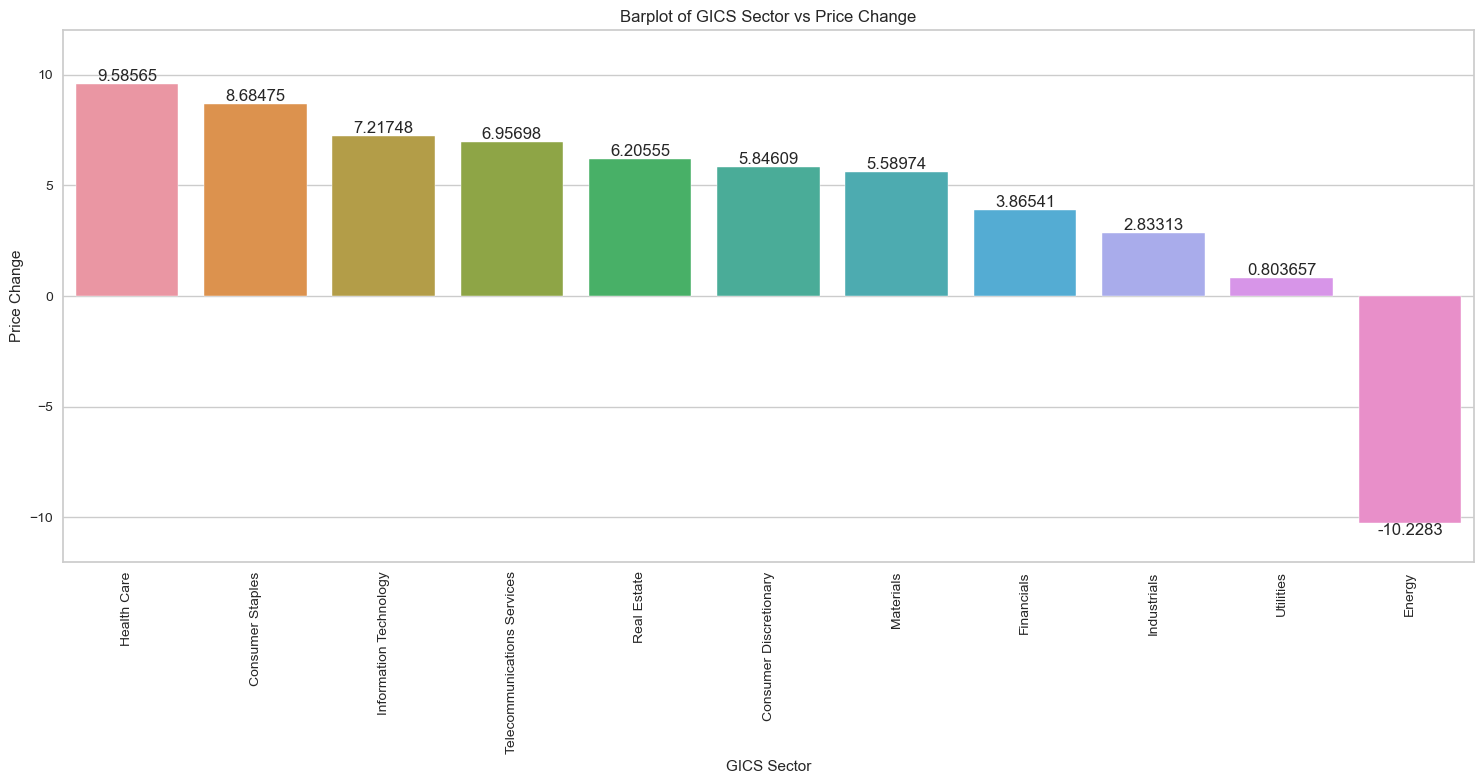

In [29]:
# Group by GICS Sector and find mean Price Change so we can sort
y_feature = 'Price Change'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(-12,12))

#### Observations
- The Health Care sector stocks have see the largest price change of 9.58. 
- The top three sectors in terms of positive price change are Health Care, Consumer Staples and Information Technology.
- Energy had the largest negative change of -10.22.

### 3. How are the different variables correlated with each other?

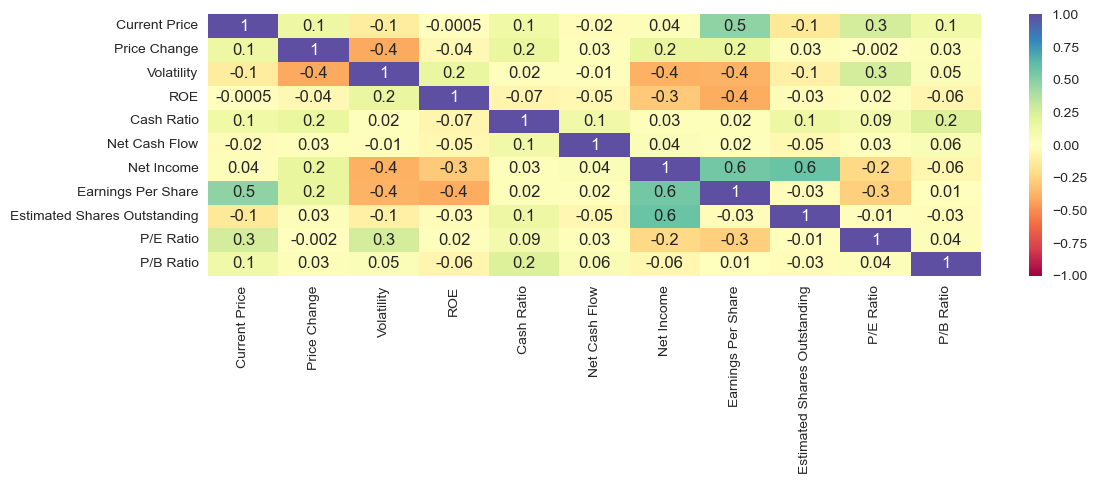

In [30]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".1g", cmap="Spectral")
plt.show()

#### Observations
- Earnings Per Share and Estimated Earnings Outstanding have a positive correlation with Net Income of .6.
- Earning Per Share and Current Price have a positive correlation of .5.
- Price Change and Volatility have a negative correlation of -.4.
- ROE and Earnings Per Share have a negative correlation of -.4.
- Net Income and Earnings Per Share have a negative correlation with Volatility of -.4.

### 4. Cash ratio provides a measure of a company's ability to cover its short-term obligations using only cash and cash equivalents. How does the average cash ratio vary across economic sectors?

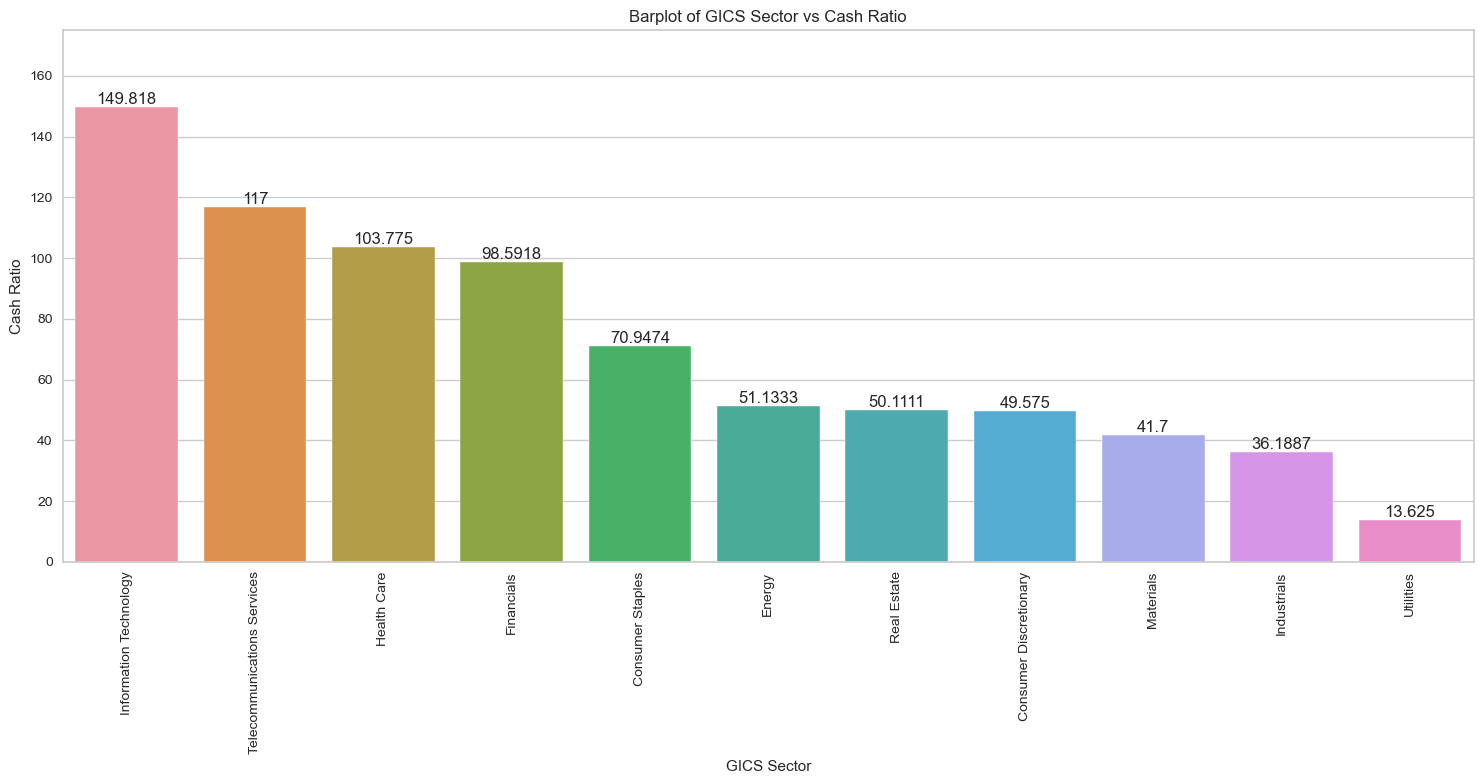

In [31]:
# Group by GICS Sector and find mean Cash Ratio so we can sort
y_feature = 'Cash Ratio'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(0,175))

#### Observations
- Information Technology has the highest Cash Ratio of 149.818.
- The top three sectors for Cash Ratio are Information Technology, Telecommunication Services and Health Care.
- The lowest sector for Cash Ratio is Utilities with 13.625.

### 5. P/E ratios can help determine the relative value of a company's shares as they signify the amount of money an investor is willing to invest in a single share of a company per dollar of its earnings. How does the P/E ratio vary, on average, across economic sectors?

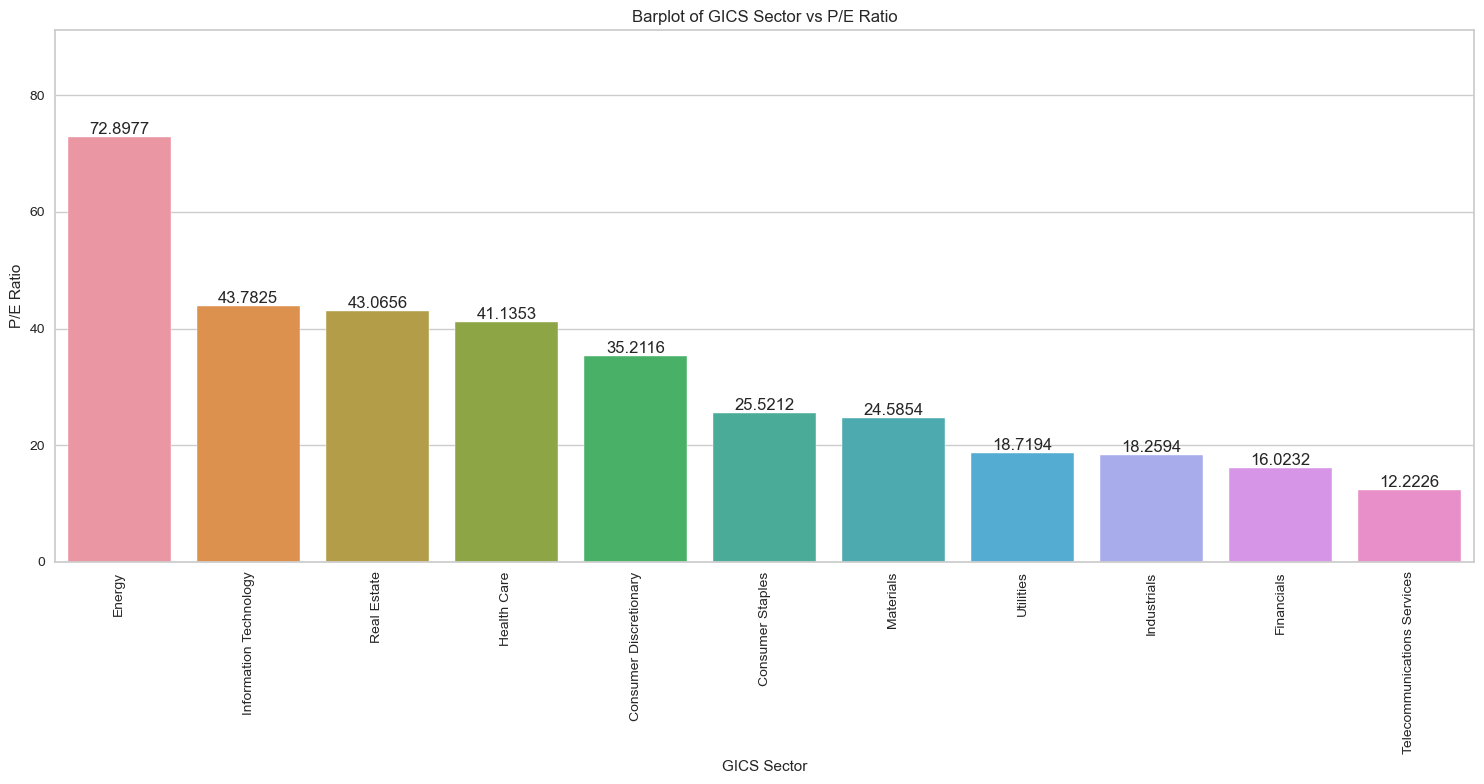

In [32]:
# Group by GICS Sector and find mean P/E Ratio so we can sort
y_feature = 'P/E Ratio'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index)

#### Observations
- Energy has the highest P/E Ratio of any sector with 72.8977.
- The top three sectors for P/E Ratio are Energy, Information Technology and Real Estate.
- The lowest Cash Ratio of any sector is Telecommunication Services with 12.22.

### Bivariate Analysis

### Let's investigate GICS Sector vs Current Price

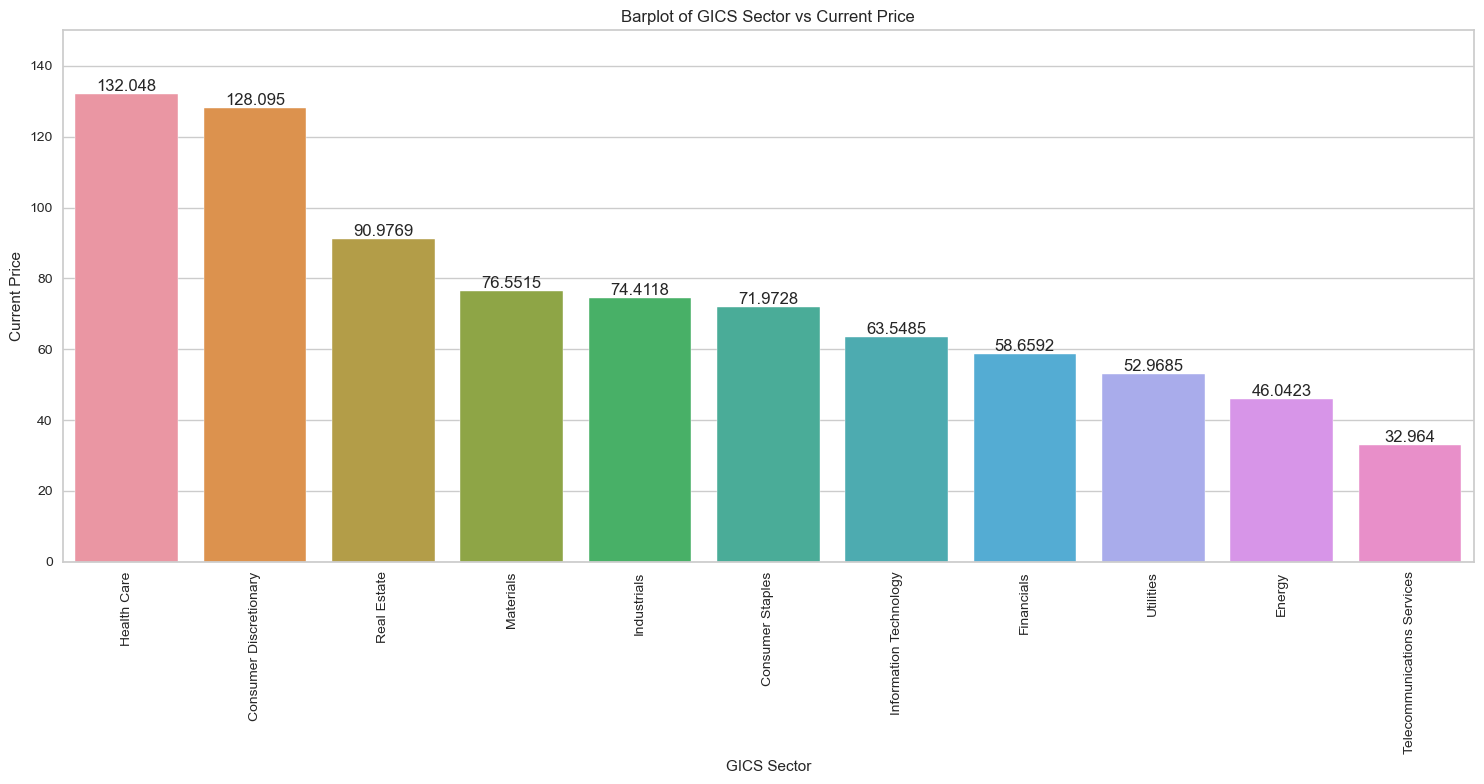

In [33]:
# Group by GICS Sector and find mean Current Price so we can sort
y_feature = 'Current Price'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(0,150))

#### Observations
- The sector with the highest mean price is the Health Care sector with 132.048.
- The top three sectors for price are Health Care, Consumer Discretionary and Real Estate.
- The sector with the lowest mean price is Telecommunication Services with 32.964.

### Let's investigate GICS Sector vs Volatility

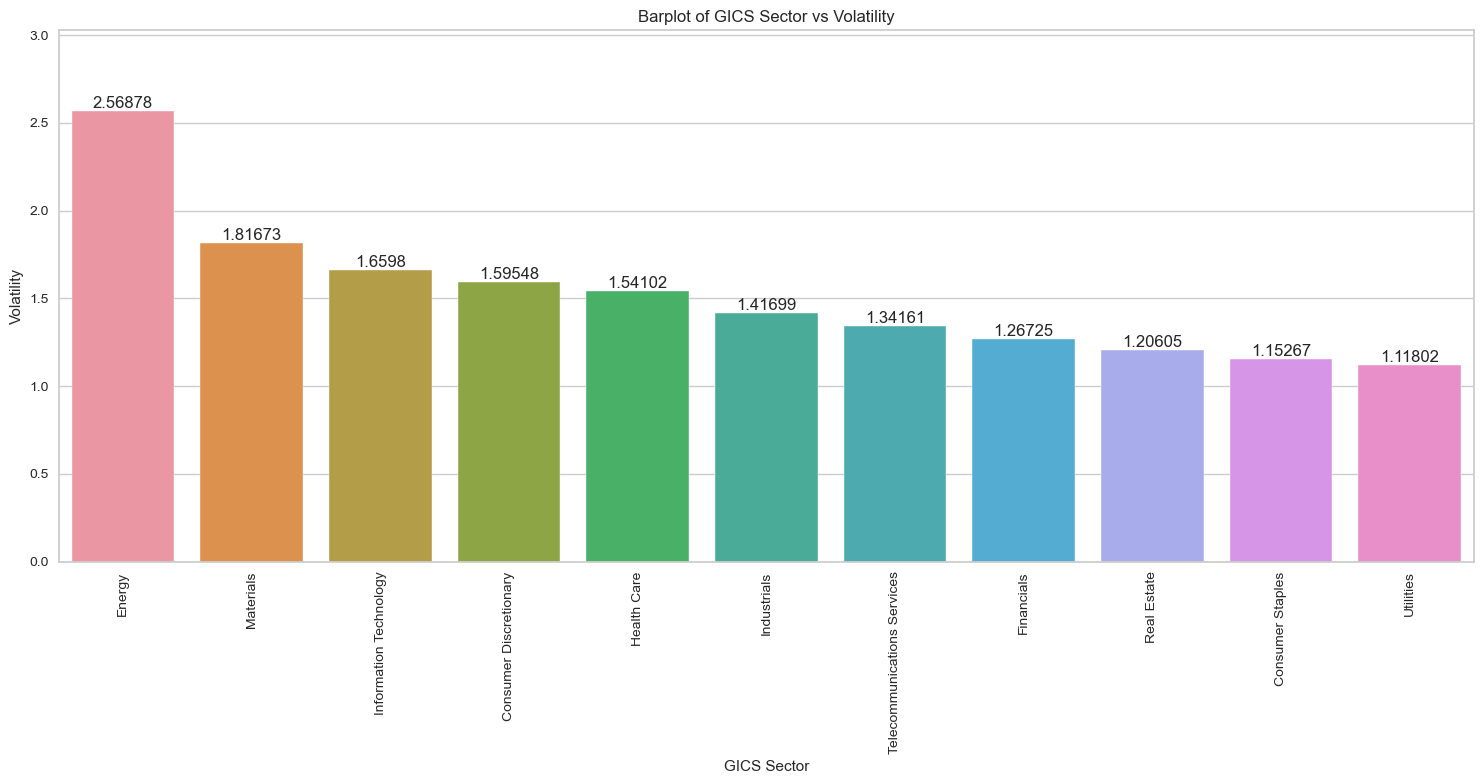

In [34]:
# Group by GICS Sector and find mean Volatility so we can sort
y_feature = 'Volatility'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index)

#### Observations
- The sector with the highest mean volatility is the Energy sector with 2.56.
- The top three sectors for volatility are Energy, Materials and Information Technology.
- The sector with the lowest volatility is Utilities with 1.118.

### Let's investigate GICS Sector vs ROE

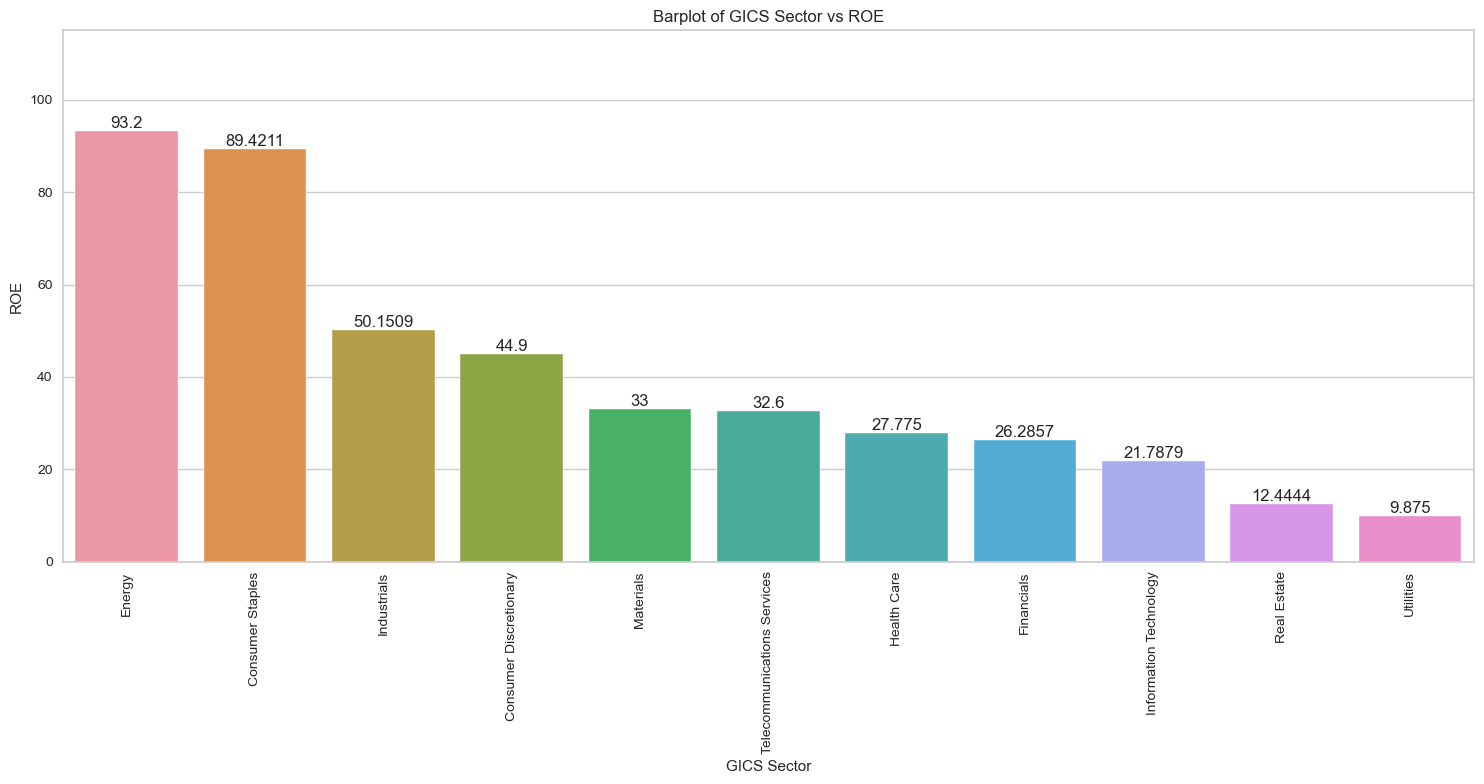

In [35]:
# Group by GICS Sector and find mean ROE so we can sort
y_feature = 'ROE'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index, y_lim=(0,115))

#### Observations
- The sector with the highest mean ROE is the Energy sector with 93.2.
- The top three sectors for ROE are Energy, Consumer Staples and Industrials.
- The sector with the lowest ROE is Utilities with 9.875.

### Let's investigate GICS Sector vs Net Cash Flow

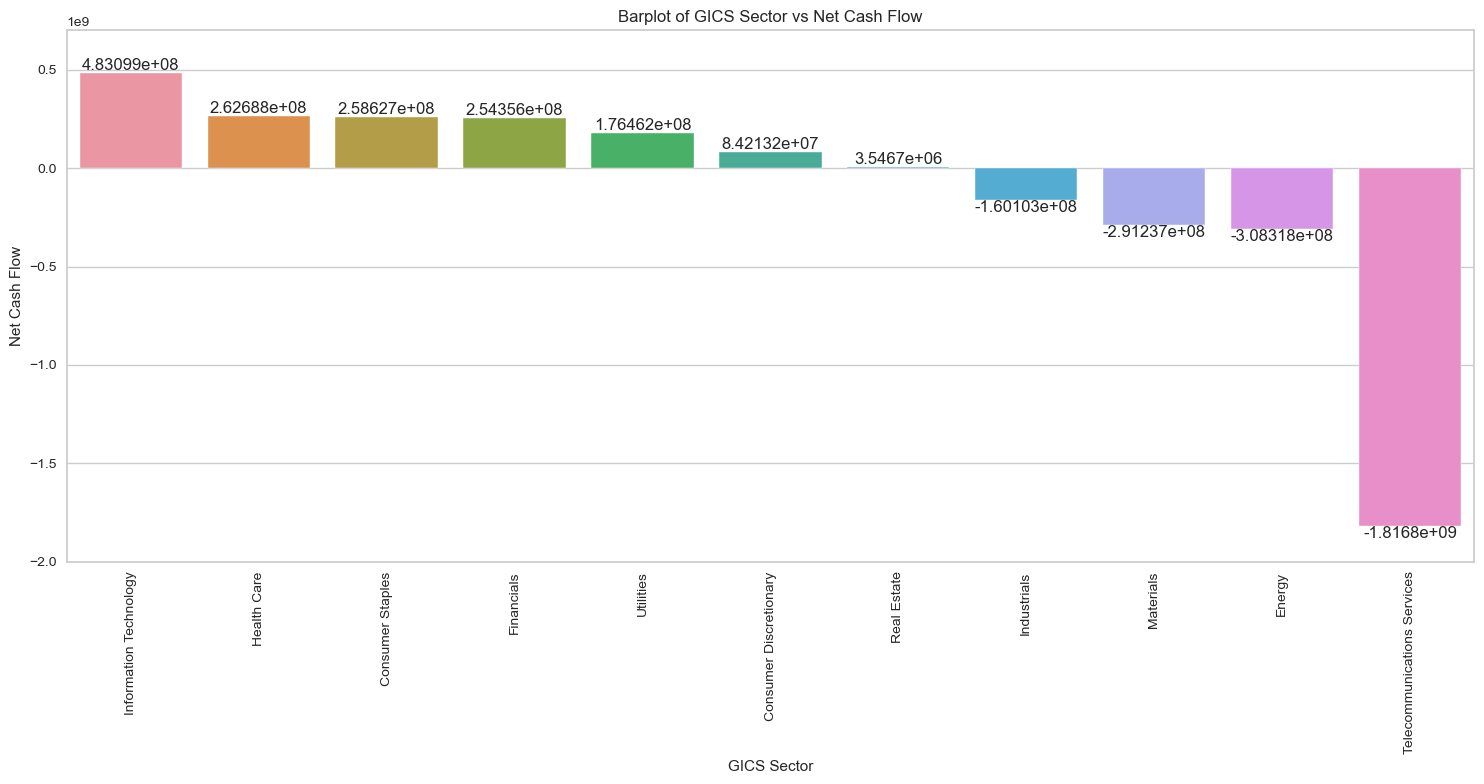

In [36]:
# Group by GICS Sector and find mean Net Cash Flow so we can sort
y_feature = 'Net Cash Flow'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(-2.0e+09,7.0e+08))

#### Observations
- The sector with the highest mean Net Cash Flow is the Information Technology sector with 4.83e+08.
- The top three sectors for Net Cash Flow are Information Technology, Health Care and Consumer Staples.
- The sector with the lowest Net Cash Flow is Telecommunication Services with -1.81e+09.

### Let's investigate GICS Sector vs Net Income

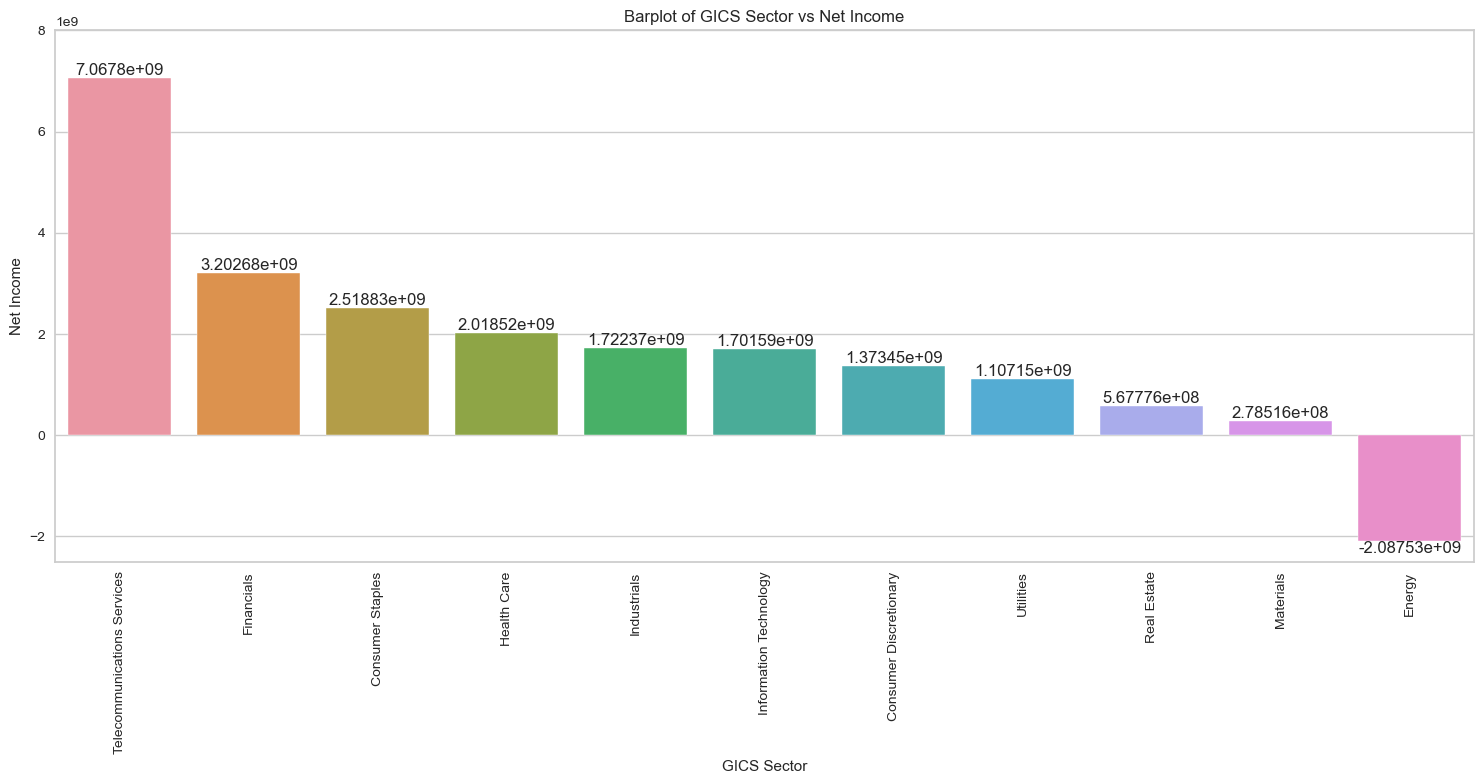

In [37]:
# Group by GICS Sector and find mean Net Income so we can sort
y_feature = 'Net Income'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(-2.5e+09,8.0e+09))

#### Observations
- The sector with the highest mean Net Income is the Telecommunication Services sector with 7.067e+09.
- The top three sectors for Net Income are Telecommunication Services, Financials and Consumer Staples.
- The sector with the lowest Net Income is Energy with -2.087+09.

### Let's investigate GICS Sector vs Earnings Per Share

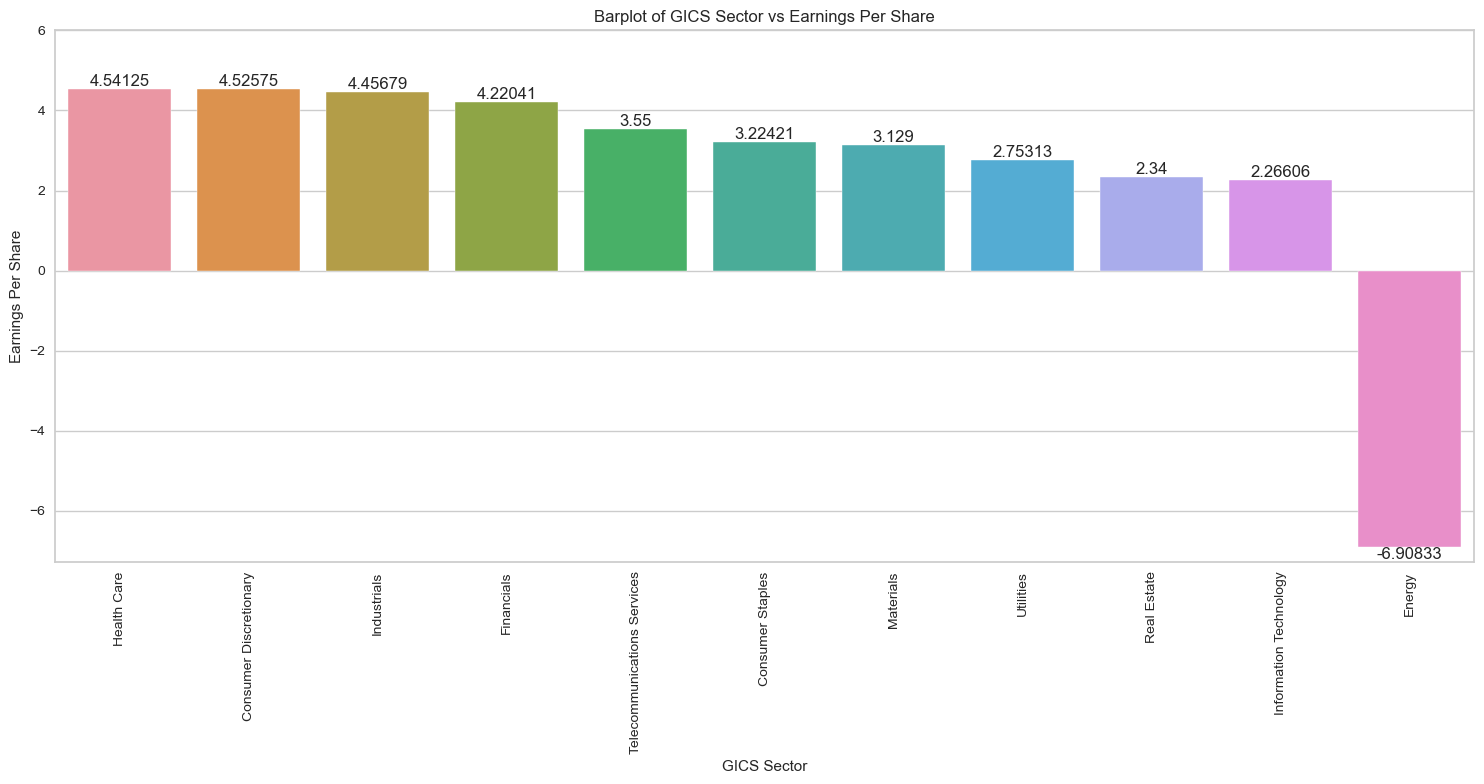

In [38]:
# Group by GICS Sector and find mean Earnings Per Share so we can sort
y_feature = 'Earnings Per Share'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(-7.27,6))

#### Observations
- The sector with the highest mean Earnings Per Share is the Health Care sector with 4.54.
- The top three sectors for Earnings Per Share are Health Care, Consumer Discretionary and Industrials.
- The sector with the lowest Earnings Per Share is Energy with -6.90.

### Let's investigate GICS Sector vs P/B Ratio

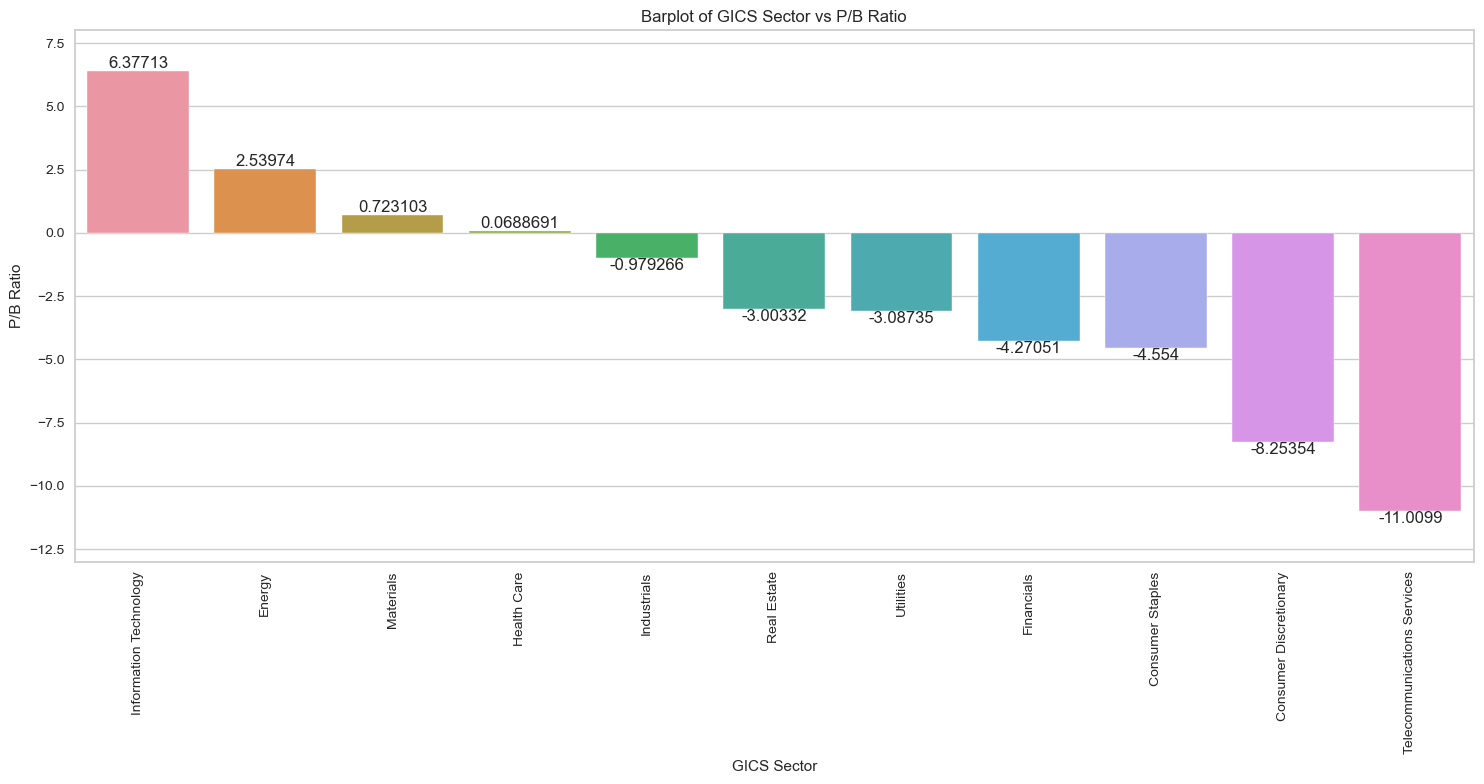

In [39]:
# Group by GICS Sector and find mean P/B Ratio so we can sort
y_feature = 'P/B Ratio'
sort_index = df.groupby('GICS Sector')[y_feature].mean().reset_index()\
                                        .sort_values(by=y_feature,ascending=False)['GICS Sector']
output_pretty_barplot(df, x='GICS Sector', y=y_feature, figsize=(15,8),
                     order=sort_index,y_lim=(-13,8))

#### Observations
- The sector with the highest mean P/B Ratio is the Information Technology sector with 6.37.
- The top three sectors for P/B Ratio are Information Technology, Energy and Materials.
- The sector with the lowest P/B Ratio is Telecommunication Services with -11.00.

### Let's investigate GICS Sector by all metrics

In [79]:
data.groupby('GICS Sector').mean()\
        .style.highlight_max(color="lightgreen", axis=0) \
                .highlight_min(color="#cd4f39", axis=0)

#### Observations
- The Consumer Discretionary sector has a negative average P/B Ratio and has the fourth highest average ROE and Volatility of all sectors.
- The Consumer Staples sector has a negative average P/B Ratio, has the third highest average Net Income and Net Cash Flow and the second highest average ROE of all the sectors.
- The Energy sector has the highest average Volatility, ROE and P/E Ratio along with the lowest average Price Change, Net Income and Earnings Per Share of all the sectors. 
- The Financials sector has a negative average P/B Ratio along with the fourth highest average Net Cash Flow/Earnings Per Share and the second highest average Net Income of all the sectors.
- The Health Care sector has the highest average Current Price, Price Change and Earnings Per Share of all the sectors.
- The Industrials sector has a negative P/B Ratio and Net Cash Flow and the third highest average ROE/Earnings Per Share of all the sectors.
- The Information Technology sector has the highest average Cash Ratio, Net Cash Flow and P/B Ratio of all the sectors.
- The Materials sector has a negative average Net Cash Flow and the lowest average Estimated Shares Outstanding.
- The Real Estate sector has a negative average P/B Ratio and the third highest average Current Price of all the sectors.
- The Telecommunications Services sector has the highest average Net Income/Estimated Shares Outstanding and the lowest average Current Price, Net Cash Flow, P/E Ratio and P/B Ratio of all the sectors.
- The Utilities sector has a negative average P/B Ratio and the lowest average Volatility, ROE and Cash Ratio of all the sectors.

## Data Preprocessing
- We are going to generate a preprocessed dataset with the base data from stock_data.csv
- We will also generate a preprocessed dataset that has GICS Sector one hot encoded.
- We will compare and contrast the performance of the two datasets using various clustering algorithms

#### GICS Sector one hot encoded dataset

In [41]:
df = pd.get_dummies(df, columns=['GICS Sector'])
num_col = df.select_dtypes(include=np.number).columns.tolist()

print('{} number columns for GICS Sector one hot encoded dataset'.format(len(num_col)))

# scaling the dataset before clustering
scaler = StandardScaler()

subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

22 number columns for GICS Sector one hot encoded dataset


#### Base stock_data.csv dataset

In [42]:
df_no_dummies = data.copy()
num_col = df_no_dummies.select_dtypes(include=np.number).columns.tolist()

print('{} number columns for base dataset'.format(len(num_col)))

# scaling the dataset before clustering
scaler = StandardScaler()

subset_no_dummies = df_no_dummies[num_col].copy()
subset_scaled_no_dummies = scaler.fit_transform(subset_no_dummies)

11 number columns for base dataset


In [43]:
# creating a dataframe of the scaled columns for the GICS Sector one hot encoded dataset
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled_df.head()

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0      -0.393341      0.493950    0.272749  0.989601   -0.210698   
1      -0.220837      0.355439    1.137045  0.937737    0.077269   
2      -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3       0.133567      0.825696   -0.284802 -0.317379    1.218059   
4      -0.260874     -0.492636    0.296470 -0.265515    2.237018   

   Net Cash Flow  Net Income  Earnings Per Share  \
0      -0.339355    1.554415            1.309399   
1      -0.002335    0.927628            0.056755   
2       0.454058    0.744371            0.024831   
3      -0.152497   -0.219816           -0.230563   
4       0.133564   -0.202703           -0.374982   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  \
0                      0.107863  -0.652487  -0.506653   
1                      1.250274  -0.311769  -0.504205   
2                      1.098021  -0.391502   0.094941   
3                     -0.091622   0.947148   0.424333   
4                      1.978399   3.293307   0.199196   

   GICS Sector_Consumer Discretionary  GICS Sector_Consumer Staples  \
0                           -0.365148                      -0.24329   
1                           -0.365148                      -0.24329   
2                           -0.365148                      -0.24329   
3                           -0.365148                      -0.24329   
4                           -0.365148                      -0.24329   

   GICS Sector_Energy  GICS Sector_Financials  GICS Sector_Health Care  \
0           -0.311086               -0.410347                -0.365148   
1           -0.311086               -0.410347                 2.738613   
2           -0.311086               -0.410347                 2.738613   
3           -0.311086               -0.410347                -0.365148   
4           -0.311086               -0.410347                -0.365148   

   GICS Sector_Industrials  GICS Sector_Information Technology  \
0                 2.327036                           -0.327860   
1                -0.429731                           -0.327860   
2                -0.429731                           -0.327860   
3                -0.429731                            3.050087   
4                -0.429731                            3.050087   

   GICS Sector_Materials  GICS Sector_Real Estate  \
0                  -0.25                -0.293704   
1                  -0.25                -0.293704   
2                  -0.25                -0.293704   
3                  -0.25                -0.293704   
4                  -0.25                -0.293704   

   GICS Sector_Telecommunications Services  GICS Sector_Utilities  
0                                -0.122169              -0.275589  
1                                -0.122169              -0.275589  
2                                -0.122169              -0.275589  
3                                -0.122169              -0.275589  
4                                -0.122169              -0.275589

In [44]:
# creating a dataframe of the scaled columns for the base stock_data.csv dataset
subset_scaled_no_dummies_df = pd.DataFrame(subset_scaled_no_dummies, columns=subset_no_dummies.columns)
subset_scaled_no_dummies_df.head()

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0      -0.393341      0.493950    0.272749  0.989601   -0.210698   
1      -0.220837      0.355439    1.137045  0.937737    0.077269   
2      -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3       0.133567      0.825696   -0.284802 -0.317379    1.218059   
4      -0.260874     -0.492636    0.296470 -0.265515    2.237018   

   Net Cash Flow  Net Income  Earnings Per Share  \
0      -0.339355    1.554415            1.309399   
1      -0.002335    0.927628            0.056755   
2       0.454058    0.744371            0.024831   
3      -0.152497   -0.219816           -0.230563   
4       0.133564   -0.202703           -0.374982   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                      0.107863  -0.652487  -0.506653  
1                      1.250274  -0.311769  -0.504205  
2                      1.098021  -0.391502   0.094941  
3                     -0.091622   0.947148   0.424333  
4                      1.978399   3.293307   0.199196

In [45]:
# checking the mean and standard deviation for GICS Sector one hot encoded dataset
np.mean(subset_scaled), np.std(subset_scaled)

(1.4248851652943186e-18, 1.0)

In [46]:
# checking the mean and standard deviation for base dataset
np.mean(subset_scaled_no_dummies), np.std(subset_scaled_no_dummies)

(-1.852350714882614e-17, 1.0)

## EDA

- It is a good idea to explore the data once again after manipulating it.

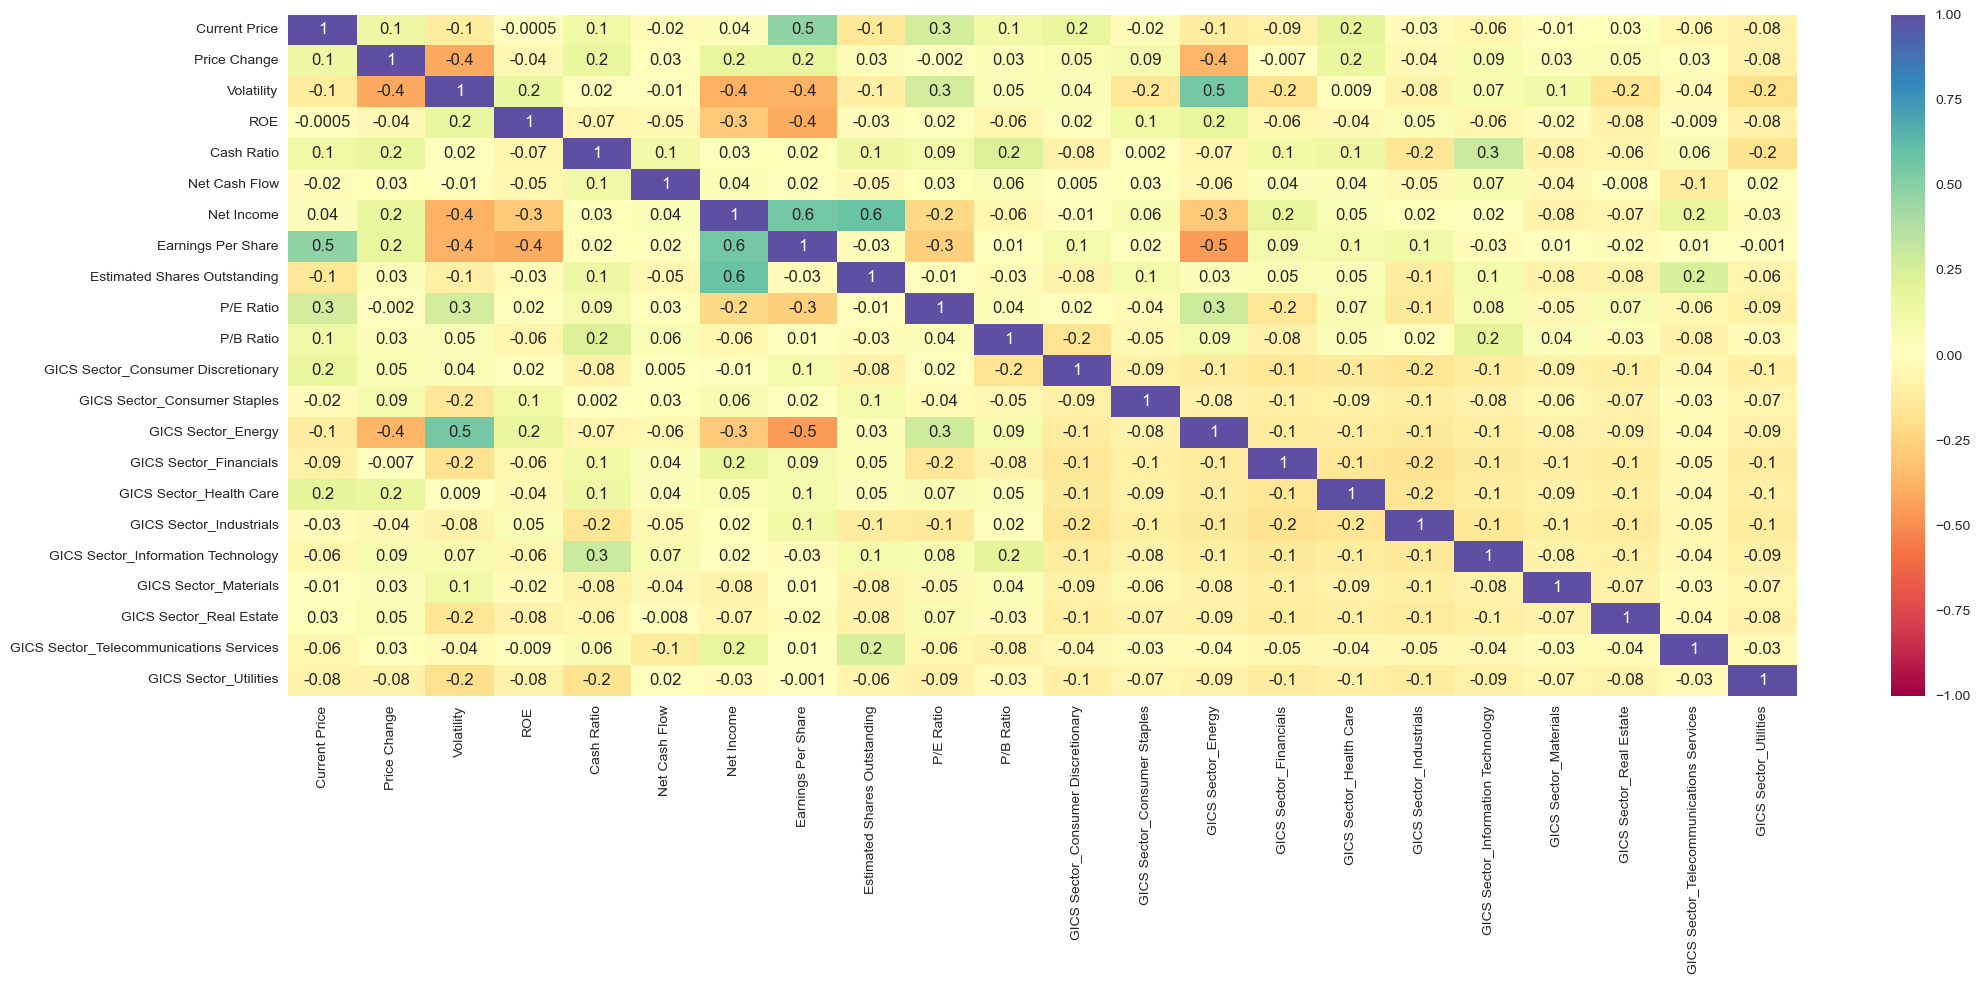

In [47]:
plt.figure(figsize=(22,10))
sns.heatmap(
    subset_scaled_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".1g", cmap="Spectral"
)
plt.show()

#### Observations
- Net Income and Estimated Shares Outstanding have a slightly positive correlation of 0.589310.
- Net Income and Earnings Per Share have a slightly positive correlation of 0.557752.
- Volatility and GICS Sector_Energy have a slightly positive correlation of 0.548968.
- Current Price and Earnings Per Share have a slightly positive correlation of 0.479604.
- ROE and Earnings Per Share have a slightly negative correlation of -0.405291.
- Price Change and Volatility have a slightly negative correlation of -0.408281.
- Earnings Per Share and GICS Sector_Energy have a slightly negative correlation of -0.458015.

## K-means Clustering

In [48]:
k_means_df = subset_scaled_df.copy()
k_means_no_dummies_df = subset_scaled_no_dummies_df.copy()

In [49]:
k_means_df.head()

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0      -0.393341      0.493950    0.272749  0.989601   -0.210698   
1      -0.220837      0.355439    1.137045  0.937737    0.077269   
2      -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3       0.133567      0.825696   -0.284802 -0.317379    1.218059   
4      -0.260874     -0.492636    0.296470 -0.265515    2.237018   

   Net Cash Flow  Net Income  Earnings Per Share  \
0      -0.339355    1.554415            1.309399   
1      -0.002335    0.927628            0.056755   
2       0.454058    0.744371            0.024831   
3      -0.152497   -0.219816           -0.230563   
4       0.133564   -0.202703           -0.374982   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  \
0                      0.107863  -0.652487  -0.506653   
1                      1.250274  -0.311769  -0.504205   
2                      1.098021  -0.391502   0.094941   
3                     -0.091622   0.947148   0.424333   
4                      1.978399   3.293307   0.199196   

   GICS Sector_Consumer Discretionary  GICS Sector_Consumer Staples  \
0                           -0.365148                      -0.24329   
1                           -0.365148                      -0.24329   
2                           -0.365148                      -0.24329   
3                           -0.365148                      -0.24329   
4                           -0.365148                      -0.24329   

   GICS Sector_Energy  GICS Sector_Financials  GICS Sector_Health Care  \
0           -0.311086               -0.410347                -0.365148   
1           -0.311086               -0.410347                 2.738613   
2           -0.311086               -0.410347                 2.738613   
3           -0.311086               -0.410347                -0.365148   
4           -0.311086               -0.410347                -0.365148   

   GICS Sector_Industrials  GICS Sector_Information Technology  \
0                 2.327036                           -0.327860   
1                -0.429731                           -0.327860   
2                -0.429731                           -0.327860   
3                -0.429731                            3.050087   
4                -0.429731                            3.050087   

   GICS Sector_Materials  GICS Sector_Real Estate  \
0                  -0.25                -0.293704   
1                  -0.25                -0.293704   
2                  -0.25                -0.293704   
3                  -0.25                -0.293704   
4                  -0.25                -0.293704   

   GICS Sector_Telecommunications Services  GICS Sector_Utilities  
0                                -0.122169              -0.275589  
1                                -0.122169              -0.275589  
2                                -0.122169              -0.275589  
3                                -0.122169              -0.275589  
4                                -0.122169              -0.275589

In [50]:
k_means_no_dummies_df.head()

Current Price  Price Change  Volatility       ROE  Cash Ratio  \
0      -0.393341      0.493950    0.272749  0.989601   -0.210698   
1      -0.220837      0.355439    1.137045  0.937737    0.077269   
2      -0.367195      0.602479   -0.427007 -0.192905   -0.033488   
3       0.133567      0.825696   -0.284802 -0.317379    1.218059   
4      -0.260874     -0.492636    0.296470 -0.265515    2.237018   

   Net Cash Flow  Net Income  Earnings Per Share  \
0      -0.339355    1.554415            1.309399   
1      -0.002335    0.927628            0.056755   
2       0.454058    0.744371            0.024831   
3      -0.152497   -0.219816           -0.230563   
4       0.133564   -0.202703           -0.374982   

   Estimated Shares Outstanding  P/E Ratio  P/B Ratio  
0                      0.107863  -0.652487  -0.506653  
1                      1.250274  -0.311769  -0.504205  
2                      1.098021  -0.391502   0.094941  
3                     -0.091622   0.947148   0.424333  
4                      1.978399   3.293307   0.199196

In [51]:
# Range of k values
low = 1
high = 15

### Checking Elbow Plot

Number of Clusters: 1 	Average Distortion: 4.309136064598443
Number of Clusters: 2 	Average Distortion: 4.099672258148711
Number of Clusters: 3 	Average Distortion: 3.931634587652164
Number of Clusters: 4 	Average Distortion: 3.740303600956558
Number of Clusters: 5 	Average Distortion: 3.5504568623387533
Number of Clusters: 6 	Average Distortion: 3.282164162929954
Number of Clusters: 7 	Average Distortion: 3.1043717890772835
Number of Clusters: 8 	Average Distortion: 2.8584510033245145
Number of Clusters: 9 	Average Distortion: 2.668138677950117
Number of Clusters: 10 	Average Distortion: 2.554770848847537
Number of Clusters: 11 	Average Distortion: 2.327370608753177
Number of Clusters: 12 	Average Distortion: 2.282848859953133
Number of Clusters: 13 	Average Distortion: 2.2222739731310686
Number of Clusters: 14 	Average Distortion: 2.161726623993936


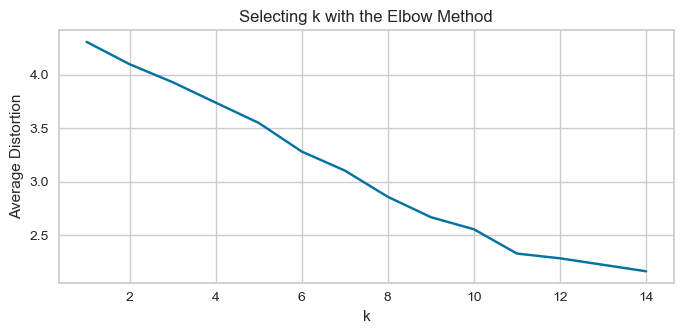

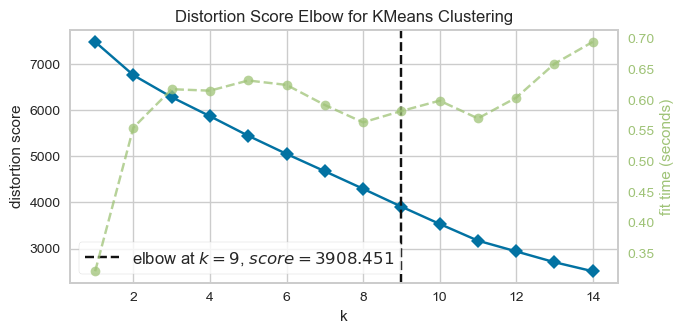

In [52]:
# Create an elbow plot for the GICS Sector one hot encoded dataset
create_elbow_plots(low, high, k_means_df)

#### Observations
- The elbow plot for dataset with GICS Sector one hot encoding shows an average distortion of 3908.45 and an elbow point with a k at 9.
- A k of 9 took about ~.6 seconds to train.

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2659465936501304
Number of Clusters: 4 	Average Distortion: 2.175554082632614
Number of Clusters: 5 	Average Distortion: 2.1070623312524175
Number of Clusters: 6 	Average Distortion: 2.0537507716340393
Number of Clusters: 7 	Average Distortion: 2.01490000287908
Number of Clusters: 8 	Average Distortion: 1.9744635725476796
Number of Clusters: 9 	Average Distortion: 1.9247285037268589
Number of Clusters: 10 	Average Distortion: 1.8568654952870578
Number of Clusters: 11 	Average Distortion: 1.7968205488339435
Number of Clusters: 12 	Average Distortion: 1.7600661850809725
Number of Clusters: 13 	Average Distortion: 1.7155844988748217
Number of Clusters: 14 	Average Distortion: 1.6636893724388284


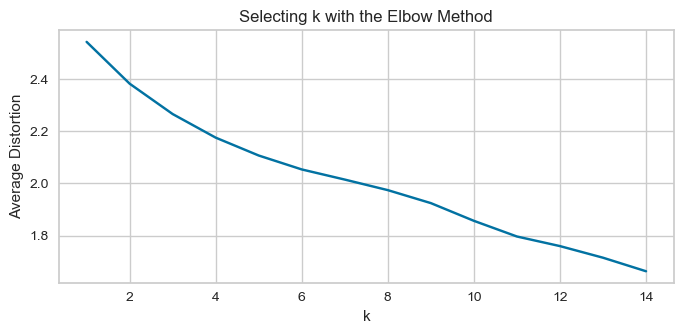

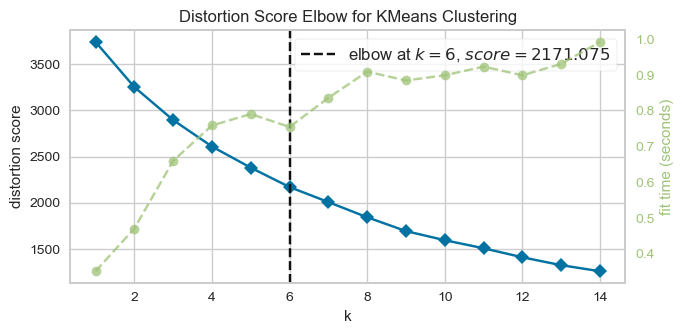

In [53]:
# Create an elbow plot for the base dataset
create_elbow_plots(low, high, k_means_no_dummies_df)

#### Observations
- The elbow plot for the base dataset set shows an average distortion of 2171.07 and an elbow point with a k at 6.
- The elbow plot for the base dataset has more of a curve than the GICS Sector one hot encoded dataset.
- A k of 6 took about ~.78 seconds to train.

### Let's check the silhouette scores

For n_clusters = 2, the silhouette score is 0.29169563330733833)
For n_clusters = 3, the silhouette score is 0.16157814270096815)
For n_clusters = 4, the silhouette score is 0.17165498153952538)
For n_clusters = 5, the silhouette score is 0.2048521443946393)
For n_clusters = 6, the silhouette score is 0.19079327511923072)
For n_clusters = 7, the silhouette score is 0.2673162088392251)
For n_clusters = 8, the silhouette score is 0.3173311676316478)
For n_clusters = 9, the silhouette score is 0.35982754752050505)
For n_clusters = 10, the silhouette score is 0.382115087702044)
For n_clusters = 11, the silhouette score is 0.41342634331703876)
For n_clusters = 12, the silhouette score is 0.4257403880109606)
For n_clusters = 13, the silhouette score is 0.43561458186158736)
For n_clusters = 14, the silhouette score is 0.4476735764359203)


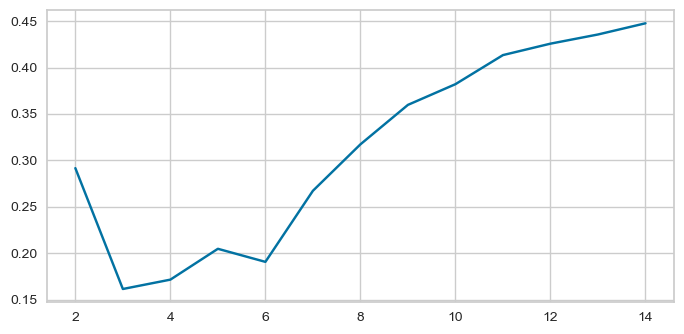

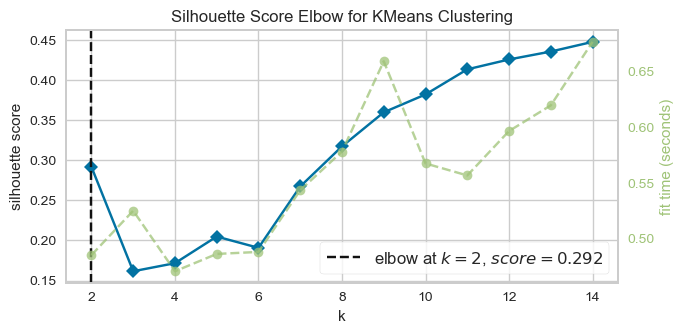

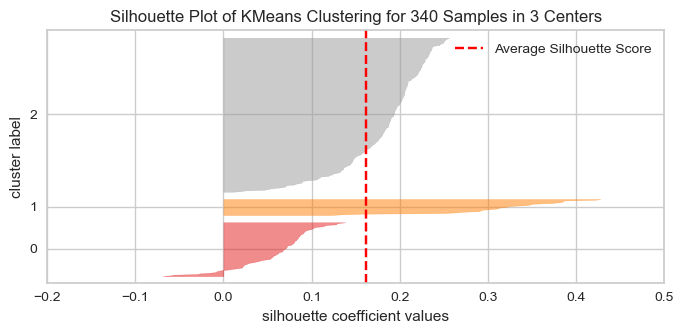

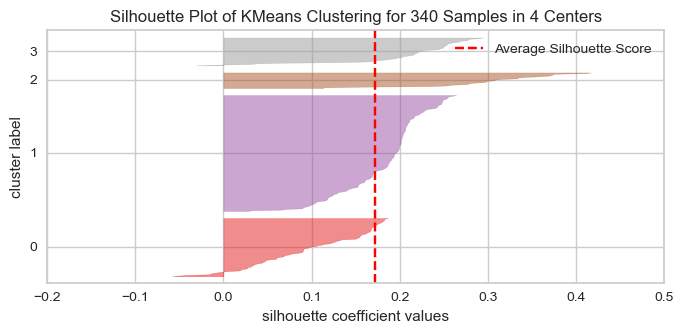

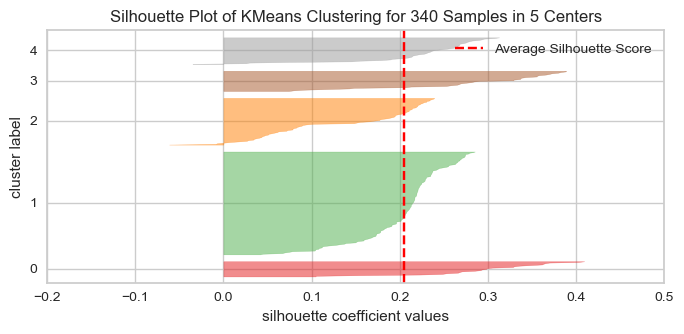

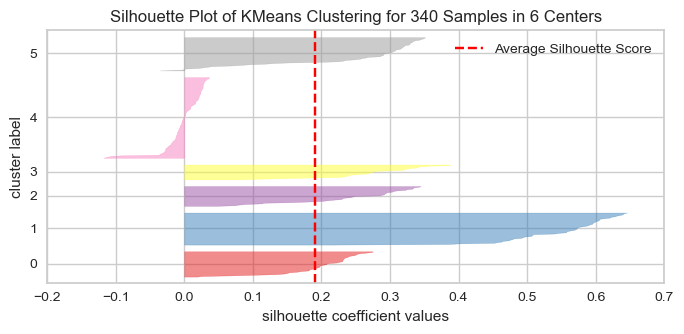

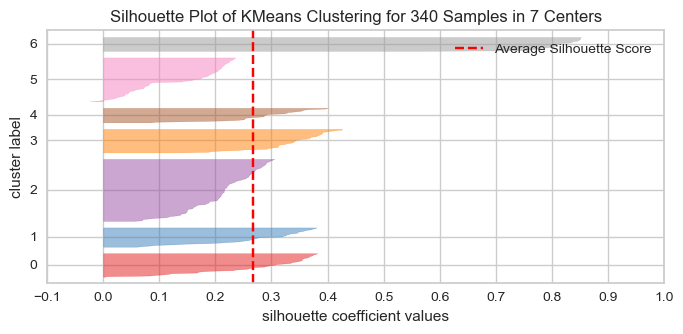

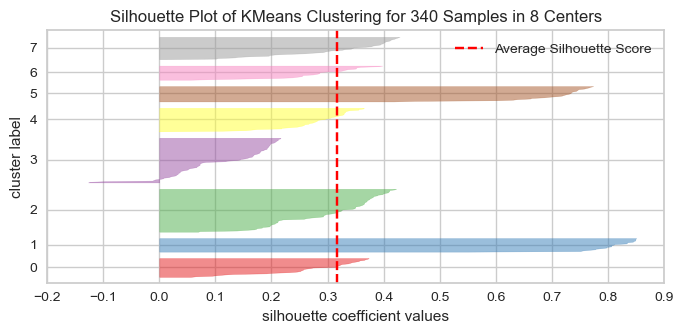

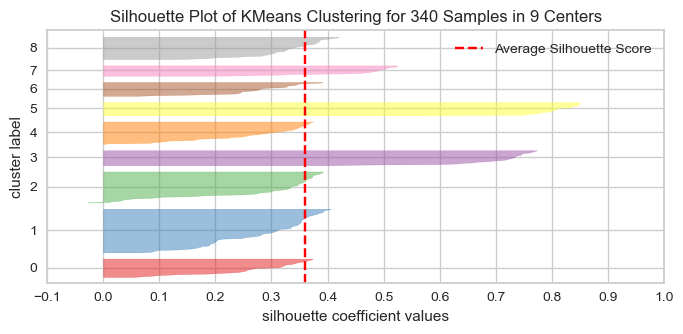

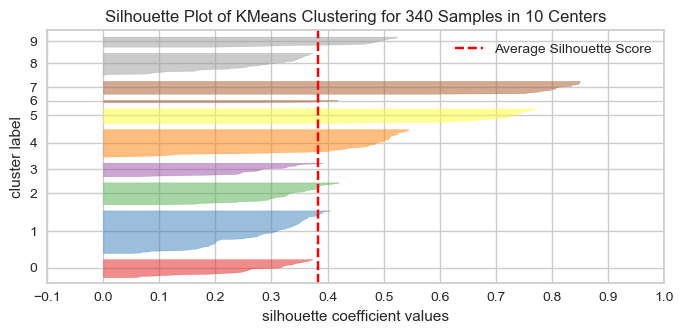

In [54]:
create_silhouette_plots(low+1,high, k_means_df)

#### Observations
- Looking at the silhouette scores for the GICS Sector one hot encoded dataset 9 and 10 clusters seem to be the most promising. 
- The clusters for a k of 10 are uniform with an average score of around ~.38, however not all of them meet or exceed the average silhouette score. 
- For a k of 9 all clusters are uniform with an average score of ~.36 and they all meet or exceed the average silhouette score.
- At around a k of 6 there is a sharp upturn in silhouette score from 0.19 to 0.267 for a k of 7 to .31 for a k of 8.
- A k of 9 took about ~.62 seconds to train.

For n_clusters = 2, the silhouette score is 0.43969639509980457)
For n_clusters = 3, the silhouette score is 0.4576529285895266)
For n_clusters = 4, the silhouette score is 0.45434371948348606)
For n_clusters = 5, the silhouette score is 0.4193637873563064)
For n_clusters = 6, the silhouette score is 0.4118459845534201)
For n_clusters = 7, the silhouette score is 0.4069637749833425)
For n_clusters = 8, the silhouette score is 0.4155198540218143)
For n_clusters = 9, the silhouette score is 0.40205424663377165)
For n_clusters = 10, the silhouette score is 0.1600886385396189)
For n_clusters = 11, the silhouette score is 0.1583367543624162)
For n_clusters = 12, the silhouette score is 0.154227253319708)
For n_clusters = 13, the silhouette score is 0.16991875542021476)
For n_clusters = 14, the silhouette score is 0.14037910509079243)


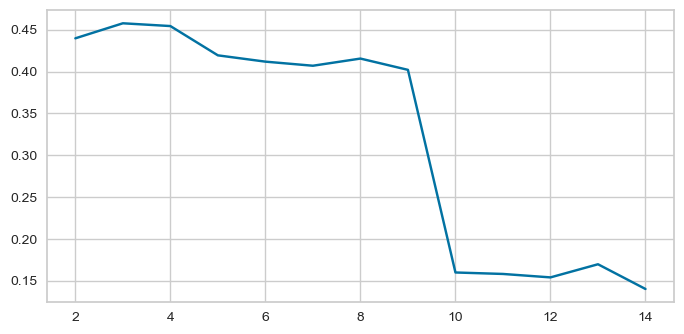

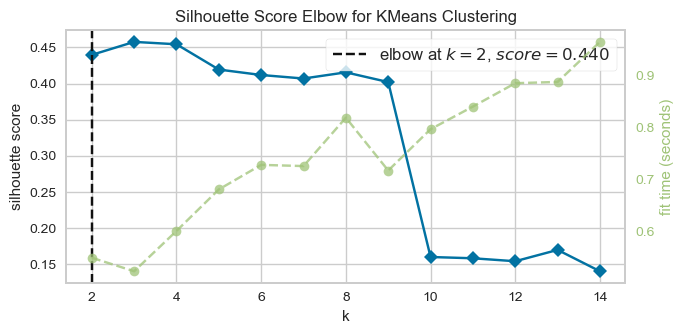

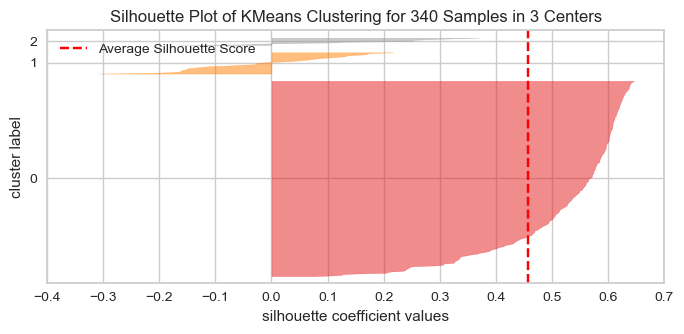

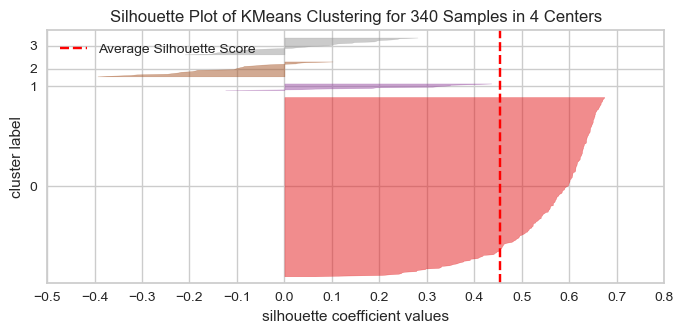

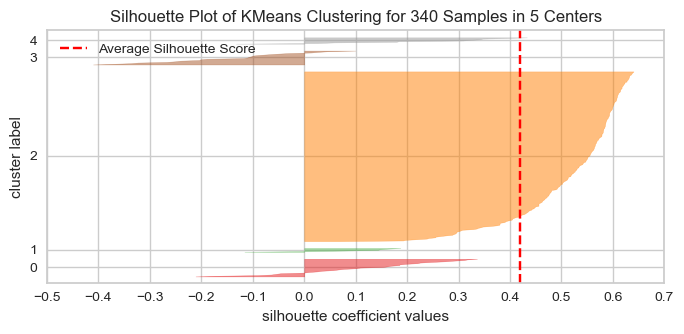

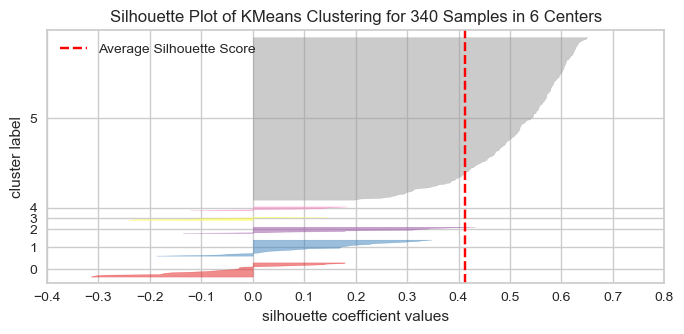

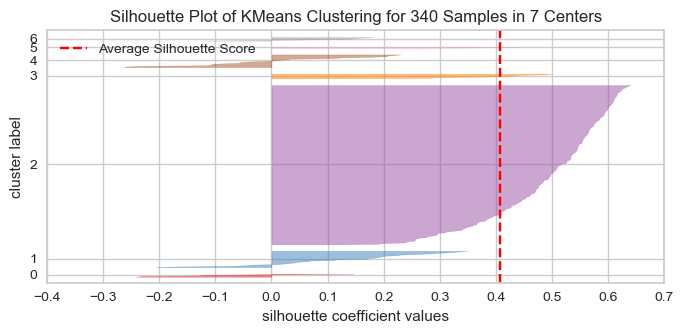

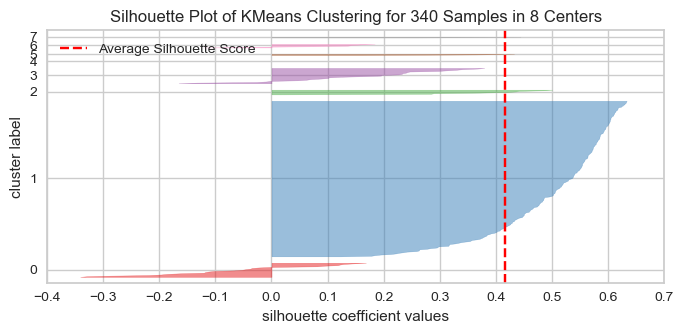

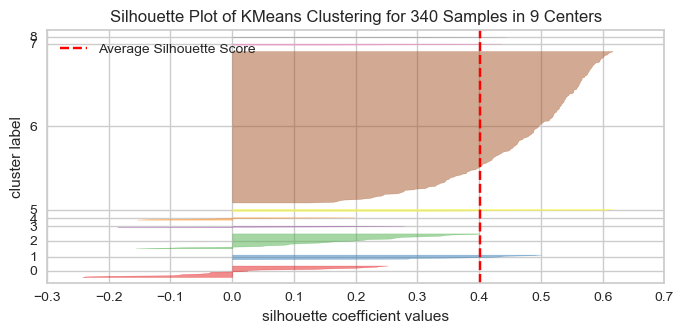

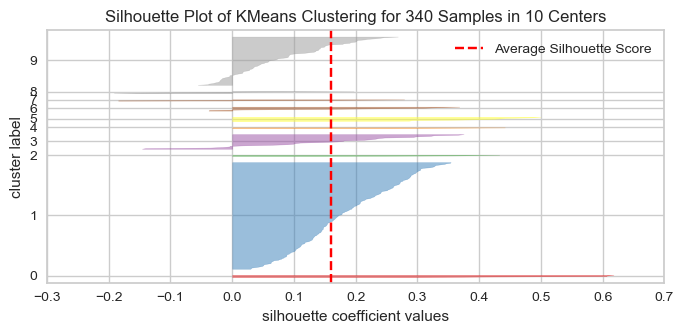

In [55]:
create_silhouette_plots(low+1,high, k_means_no_dummies_df)

#### Observations
- In all cases for the base dataset the clusters are not uniform and do not collectively exceed the average silhouette score. In fact in all cases some clusters show a split of positive and negative silhouette scores within the same cluster. This behavior indicates not all members in that cluster are in the correct cluster.  
- There is a precipitous drop in silhouette scores from a k of 9 to a k of 10 (~.4 to .16).
- The best k for the base dataset is 10 which shows better cluster uniformity, but with a much lower average silhouette score of .16 and a mix of clusters with both positive and negative scores.
- A k of 10 took about ~.78 seconds to train.

### Creating Final Model

In [56]:
# final K-means model the GICS Sector one hot encoded dataset
kmeans = KMeans(n_clusters=9, n_init=100, max_iter=500, init='k-means++', random_state=1)
kmeans.fit(k_means_df)

KMeans(max_iter=500, n_clusters=9, n_init=100, random_state=1)

In [57]:
# final K-means model for the base dataset
kmeans2 = KMeans(n_clusters=10, n_init=100, max_iter=500, init='k-means++', random_state=1)
kmeans2.fit(k_means_no_dummies_df)

KMeans(max_iter=500, n_clusters=10, n_init=100, random_state=1)

In [58]:
# creating a copy of the original data
df1 = df.copy()
df1['GICS Sector'] = data['GICS Sector']

# creating a copy of the original data
df1_no_dummies = data.copy()

# Do tsne feature reduction for visualization
tsne_kmeans = TSNE(n_components=2, random_state=1).fit_transform(k_means_df)
tsne_kmeans_df = pd.DataFrame(tsne_kmeans, columns=['Component 1', 'Component 2'])
tsne_kmeans_df['KM_segments'] = kmeans.labels_

# Do tsne feature reduction for visualization
tsne_kmeans_no_dummies = TSNE(n_components=2, random_state=1).fit_transform(k_means_no_dummies_df)
tsne_kmeans_no_dummies_df = pd.DataFrame(tsne_kmeans_no_dummies, columns=['Component 1', 'Component 2'])
tsne_kmeans_no_dummies_df['KM_segments'] = kmeans2.labels_

# adding kmeans cluster labels to the original and scaled dataframe
k_means_df['KM_segments'] = kmeans.labels_
k_means_no_dummies_df['KM_segments'] = kmeans2.labels_

df1['KM_segments'] = kmeans.labels_
df1_no_dummies['KM_segments'] = kmeans2.labels_

#### Visualize the kmeans clusters

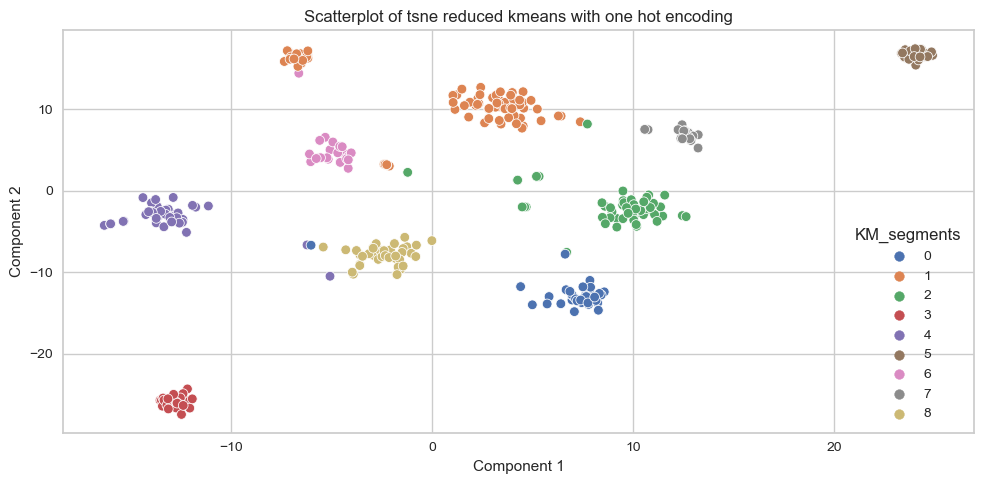

In [59]:
# Visualize the K-means model the GICS Sector one hot encoded dataset
output_pretty_scatterplot(tsne_kmeans_df, 'Component 1', 'Component 2', hue='KM_segments',\
                          title='Scatterplot of tsne reduced kmeans with one hot encoding',palette='deep')

#### Observations
- The GICS Sector one hot encoded dataset shows a nice separation of the 9 clusters.
- There are some cases where members of certain clusters have outliers that are extremely close to or penetrating other clusters.

> Cluster 2 and Cluster 0, 1

> Cluster 4 and Cluster 8

> Cluster 6 and Cluster 1

- Cluster 1 has a distant sub-cluster that could possibly be a cluster on its own.
- Cluster 1 appears to be the largest cluster.

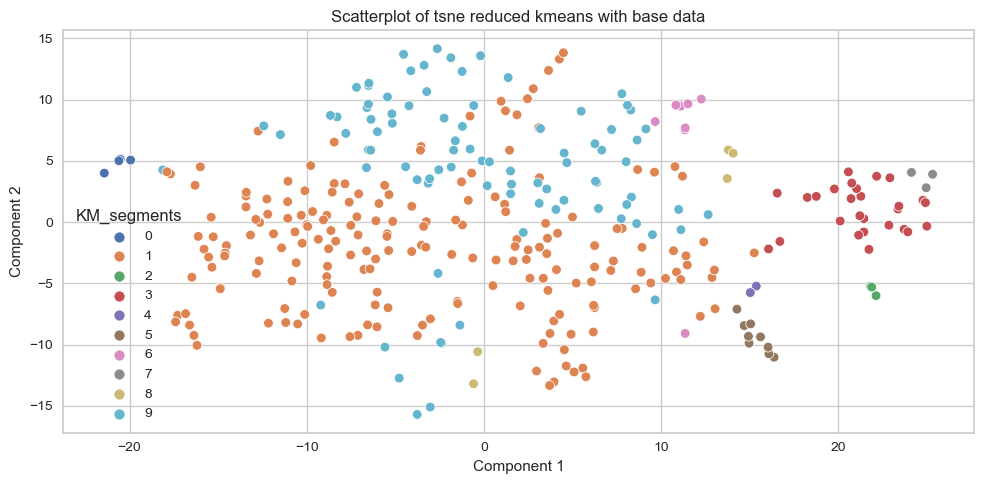

In [60]:
# Visualize the the K-means model for the base dataset 
output_pretty_scatterplot(tsne_kmeans_no_dummies_df, 'Component 1', 'Component 2', hue='KM_segments',\
                          title='Scatterplot of tsne reduced kmeans with base data', palette='deep')

#### Observations
- The base dataset shows a limited separation of its 10 clusters. 
- The clusters are mostly not uniform and there are outliers along with several extremely small clusters. 
- Cluster 1 appears to be the largest cluster.

### Cluster Profiling

In cluster 1, there are 77 total companies shown below:
['American Airlines Group' 'Albemarle Corp' 'Alaska Air Group Inc'
 'Allegion' 'AMETEK Inc' 'Arconic Inc' 'Boeing Company' 'Ball Corp'
 'Caterpillar Inc.' 'CF Industries Holdings Inc'
 'C. H. Robinson Worldwide' 'Cummins Inc.' 'CSX Corp.' 'Chevron Corp.'
 'Delta Air Lines' 'Du Pont (E.I.)' 'Deere & Co.' 'Danaher Corp.'
 'Dun & Bradstreet' 'Dover Corp.' 'Ecolab Inc.' 'Equifax Inc.'
 'Eastman Chemical' 'Eaton Corporation' "Expeditors Int'l" 'Fastenal Co'
 'Fortune Brands Home & Security' 'Fluor Corp.' 'Flowserve Corporation'
 'FMC Corporation' 'General Dynamics' 'Grainger (W.W.) Inc.'
 "Honeywell Int'l Inc." 'Intl Flavors & Fragrances' 'International Paper'
 'Illinois Tool Works' 'J. B. Hunt Transport Services'
 'Jacobs Engineering Group' 'Kansas City Southern' 'Leggett & Platt'
 'L-3 Communications Holdings' 'Lockheed Martin Corp.'
 'Southwest Airlines' 'LyondellBasell' 'Masco Corp.'
 'Martin Marietta Materials' '3M Company' 'The M

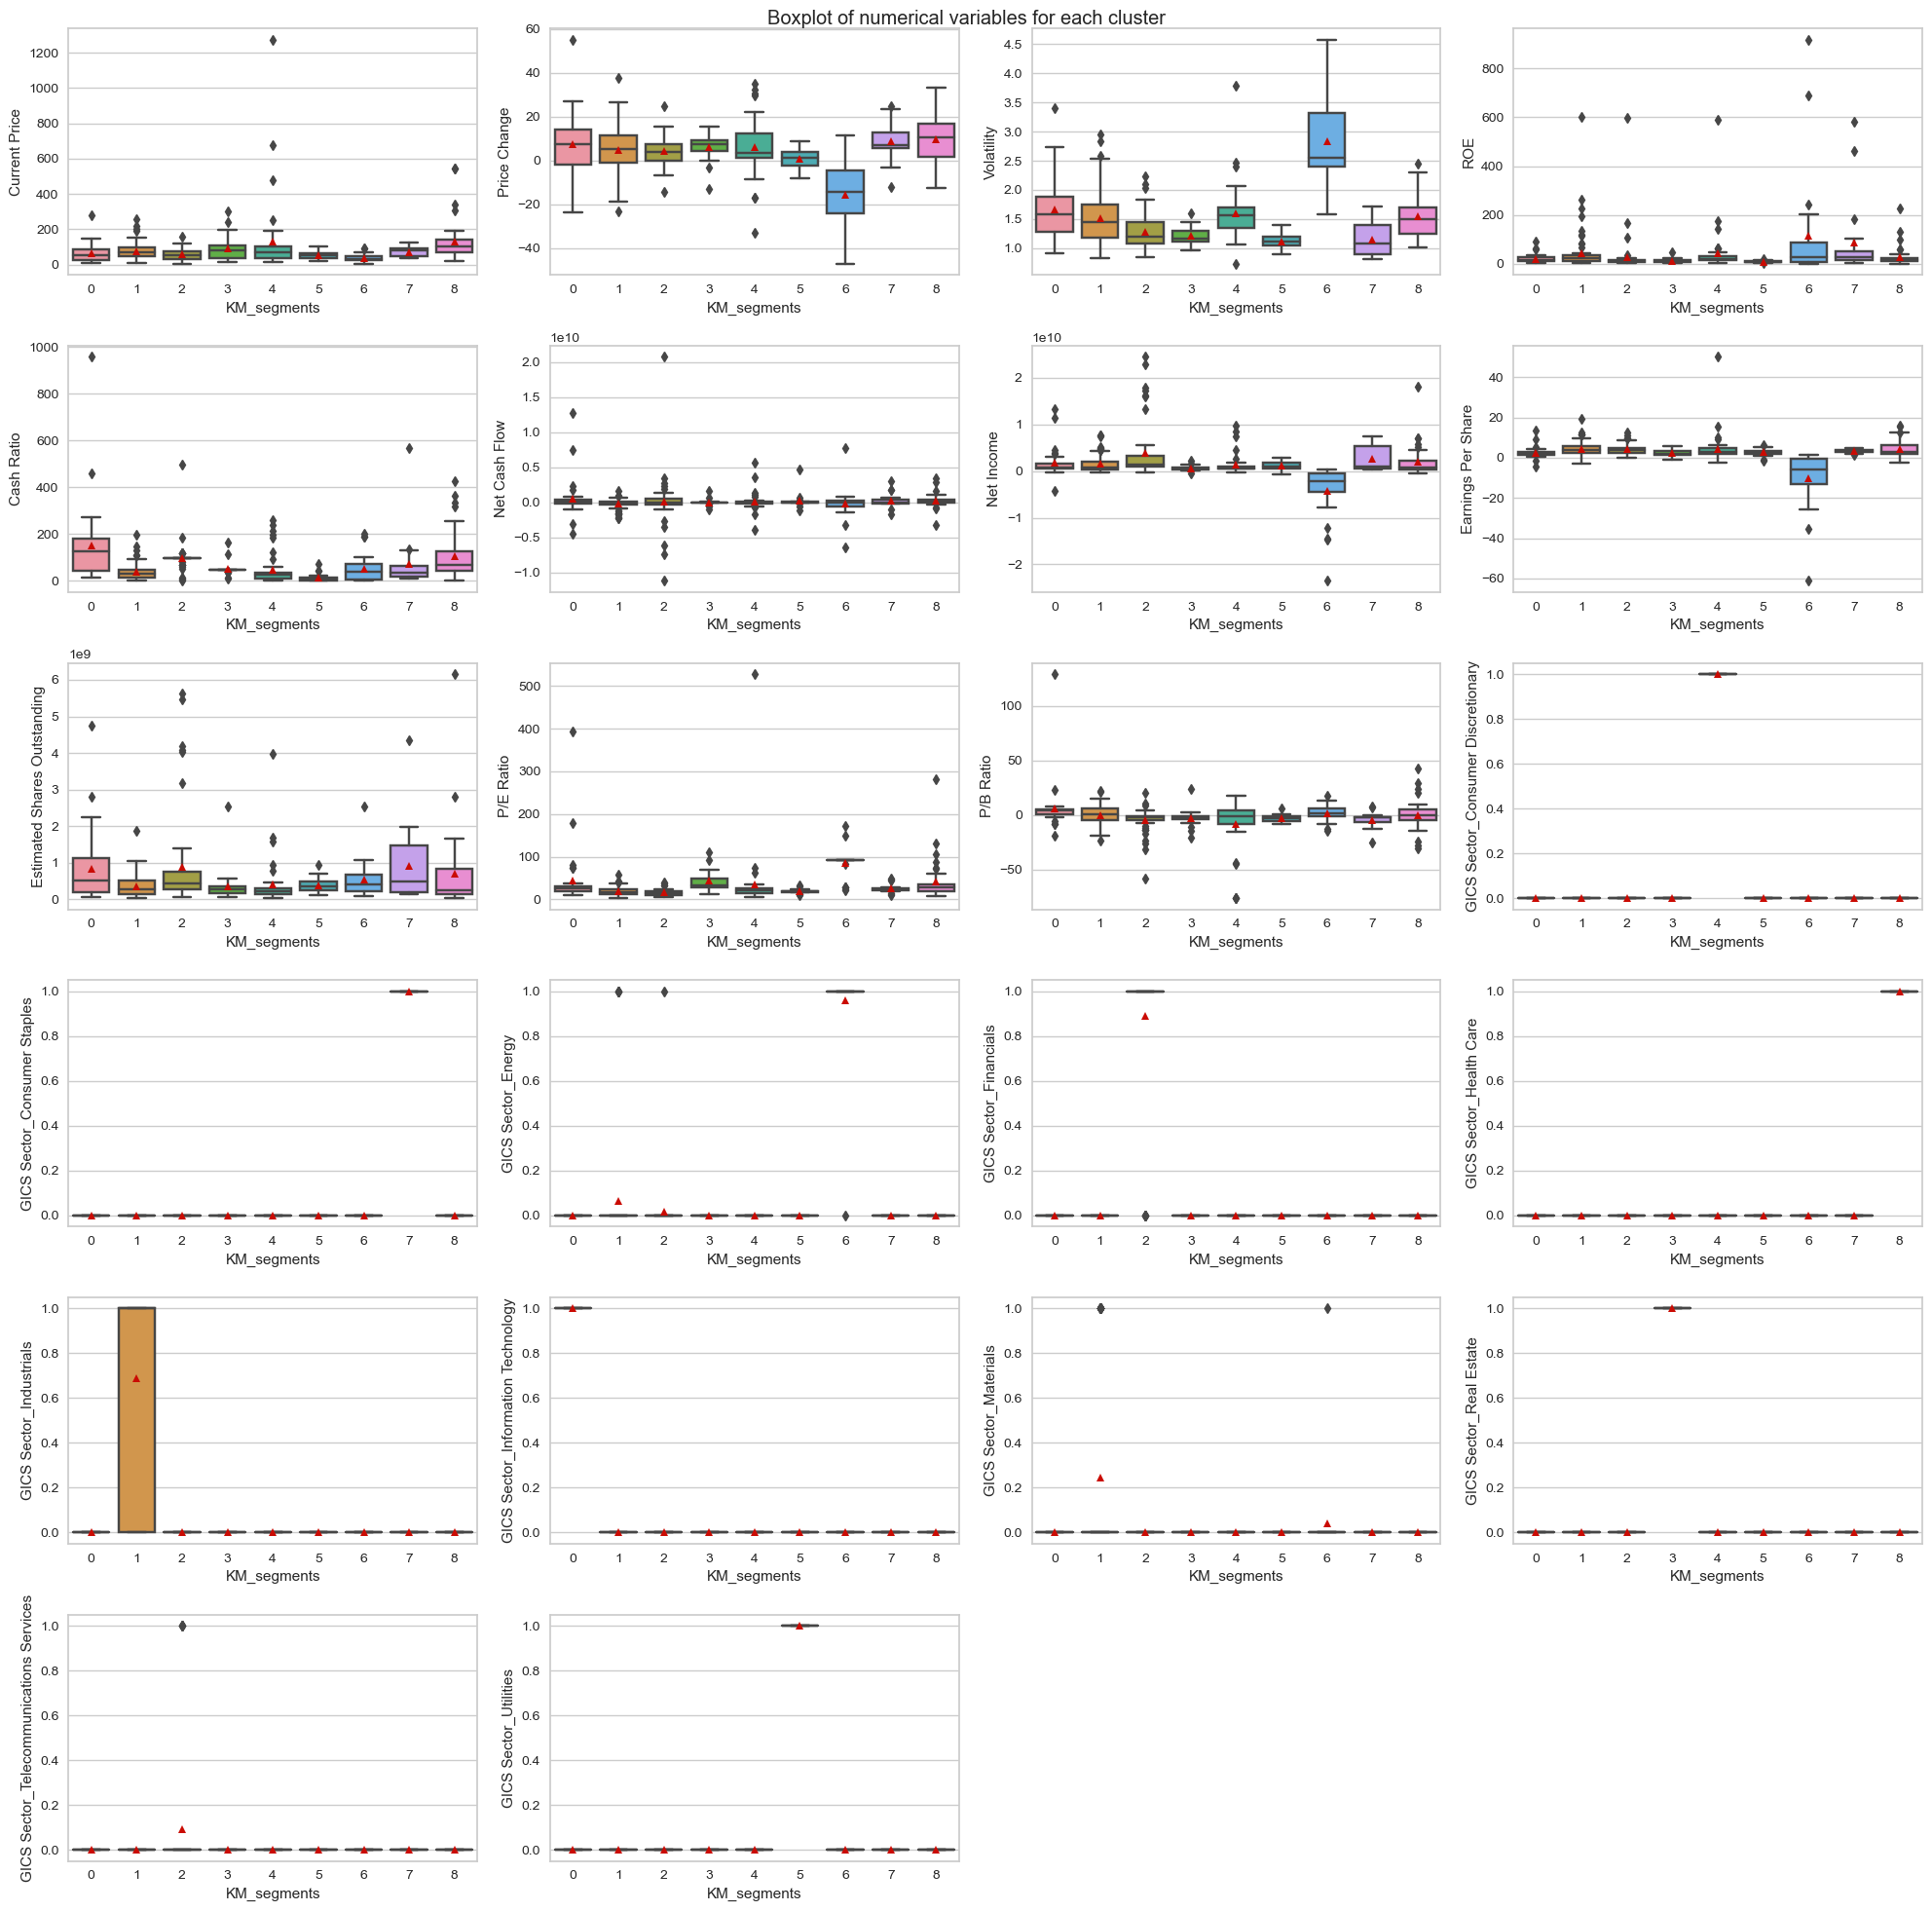

In [61]:
# Cluster profiling the the K-means model for the GISC Sector one hot encoded dataset 
km_cluster_profile = cluster_profiling(df1, "KM_segments")
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0) \
                        .highlight_min(color="#cd4f39", axis=0)

#### Observations
- The GICS Sector one hot encoded dataset shows a nice separation of the 9 clusters.
- There are some cases where members of certain clusters have outliers that are extremely close to or penetrating other clusters.

> Cluster 2 and Cluster 0, 1

> Cluster 4 and Cluster 8

> Cluster 6 and Cluster 1

- Cluster 1 has a distant sub-cluster that could possibly be a cluster on its own.
- Cluster 1 appears to be the largest cluster.
- The Energy sector is split between Cluster 1, 2 and 6 with the largest concentration in Cluster 6.
- The Materials sector is split between Cluster 1 and 6 with the largest concentration in Cluster 1.


- **Cluster 0**
> - Contains companies from the Information Technology sector exclusively.
> - This cluster contains the highest average Cash Ratio, Net Cash Flow and P/B Ratio for companies.
> - This cluster contains 9.7% of the companies.

- **Cluster 1**
> - Contains companies from the Energy, Industrials and Materials sectors.
> - This cluster contains the lowest average Net Cash Flow for companies.
> - This cluster contains a negative P/B Ratio.
> - This cluster contains 22.64% of the companies.

- **Cluster 2**
> - Contains companies from the Energy, Financials and Telecommunications Services sectors.
> - This cluster contains the highest average Net Income along with the lowest P/E Ratio for companies. 
> - This cluster contains a negative P/B Ratio.
> - This cluster contains 16.17% of the companies.
			
- **Cluster 3**
> - Contains companies from the Real Estate sector exclusively.
> - This cluster has the lowest average Estimated Shares Outstanding which could be indicative of closely held companies. 
> - This cluster contains a negative P/B Ratio.
> - This cluster contains 7.94% of the companies.

- **Cluster 4**
> - Contains companies from the Consumer Discretionary sector exclusively.
> - This cluster has the lowest average P/B Ratio (negative) which may indicate the market has overvalued these companies.
> - This cluster contains 11.76% of the companies.

- **Cluster 5**
> - Contains companies from the Utilities sector exclusively.
> - This cluster contains companies with the lowest average volatility, ROE and Cash Ratio. 
> - This cluster contains a negative P/B Ratio.
> - This cluster contains 7.05% of the companies.

- **Cluster 6**
> - Contains companies from the Energy and Materials sectors.
> - This cluster contains the highest average Volatility, ROE and P/E Ratio for companies.
> - This cluster contain the lowest average Current Price, Price Change (negative), Net Income (negative) and Earnings Per Share. 
> - This cluster contains a negative Net Cash Flow.
> - This cluster contains 7.35% of the companies.
			
- **Cluster 7**
> - Contains companies from the Consumer Staples sector exclusively.
> - This cluster contains the highest average Estimated Shares outstanding for companies.
> - This cluster contains a negative P/B Ratio.
> - This cluster contains 5.58% of the companies.

- **Cluster 8**
> - Contains companies from the Health Care sector exclusively.
> - This cluster contains the highest average Current Price, Price Change and Earnings Per Share of companies.
> - This cluster contains 11.76% of the companies.

In cluster 1, there are 191 total companies shown below:
['American Airlines Group' 'Archer-Daniels-Midland Co' 'Ameren Corp'
 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Alaska Air Group Inc' 'Allstate Corp' 'AMETEK Inc'
 'Affiliated Managers Group Inc' 'Ameriprise Financial'
 'American Tower Corp A' 'AutoNation Inc' 'Anthem Inc.' 'Aon plc'
 'Amphenol Corp' 'AvalonBay Communities, Inc.'
 'American Water Works Company Inc' 'American Express Co'
 'BB&T Corporation' 'Bard (C.R.) Inc.' 'The Bank of New York Mellon Corp.'
 'BorgWarner' 'Boston Properties' 'Caterpillar Inc.' 'Chubb Limited'
 'CBRE Group' 'Crown Castle International Corp.' 'Carnival Corp.'
 'CF Industries Holdings Inc' 'Church & Dwight' 'C. H. Robinson Worldwide'
 'CIGNA Corp.' 'Cincinnati Financial' 'Comerica Inc.' 'CME Group Inc.'
 'Cummins Inc.' 'CMS Energy' 'CenterPoint Energy' 'Capital On

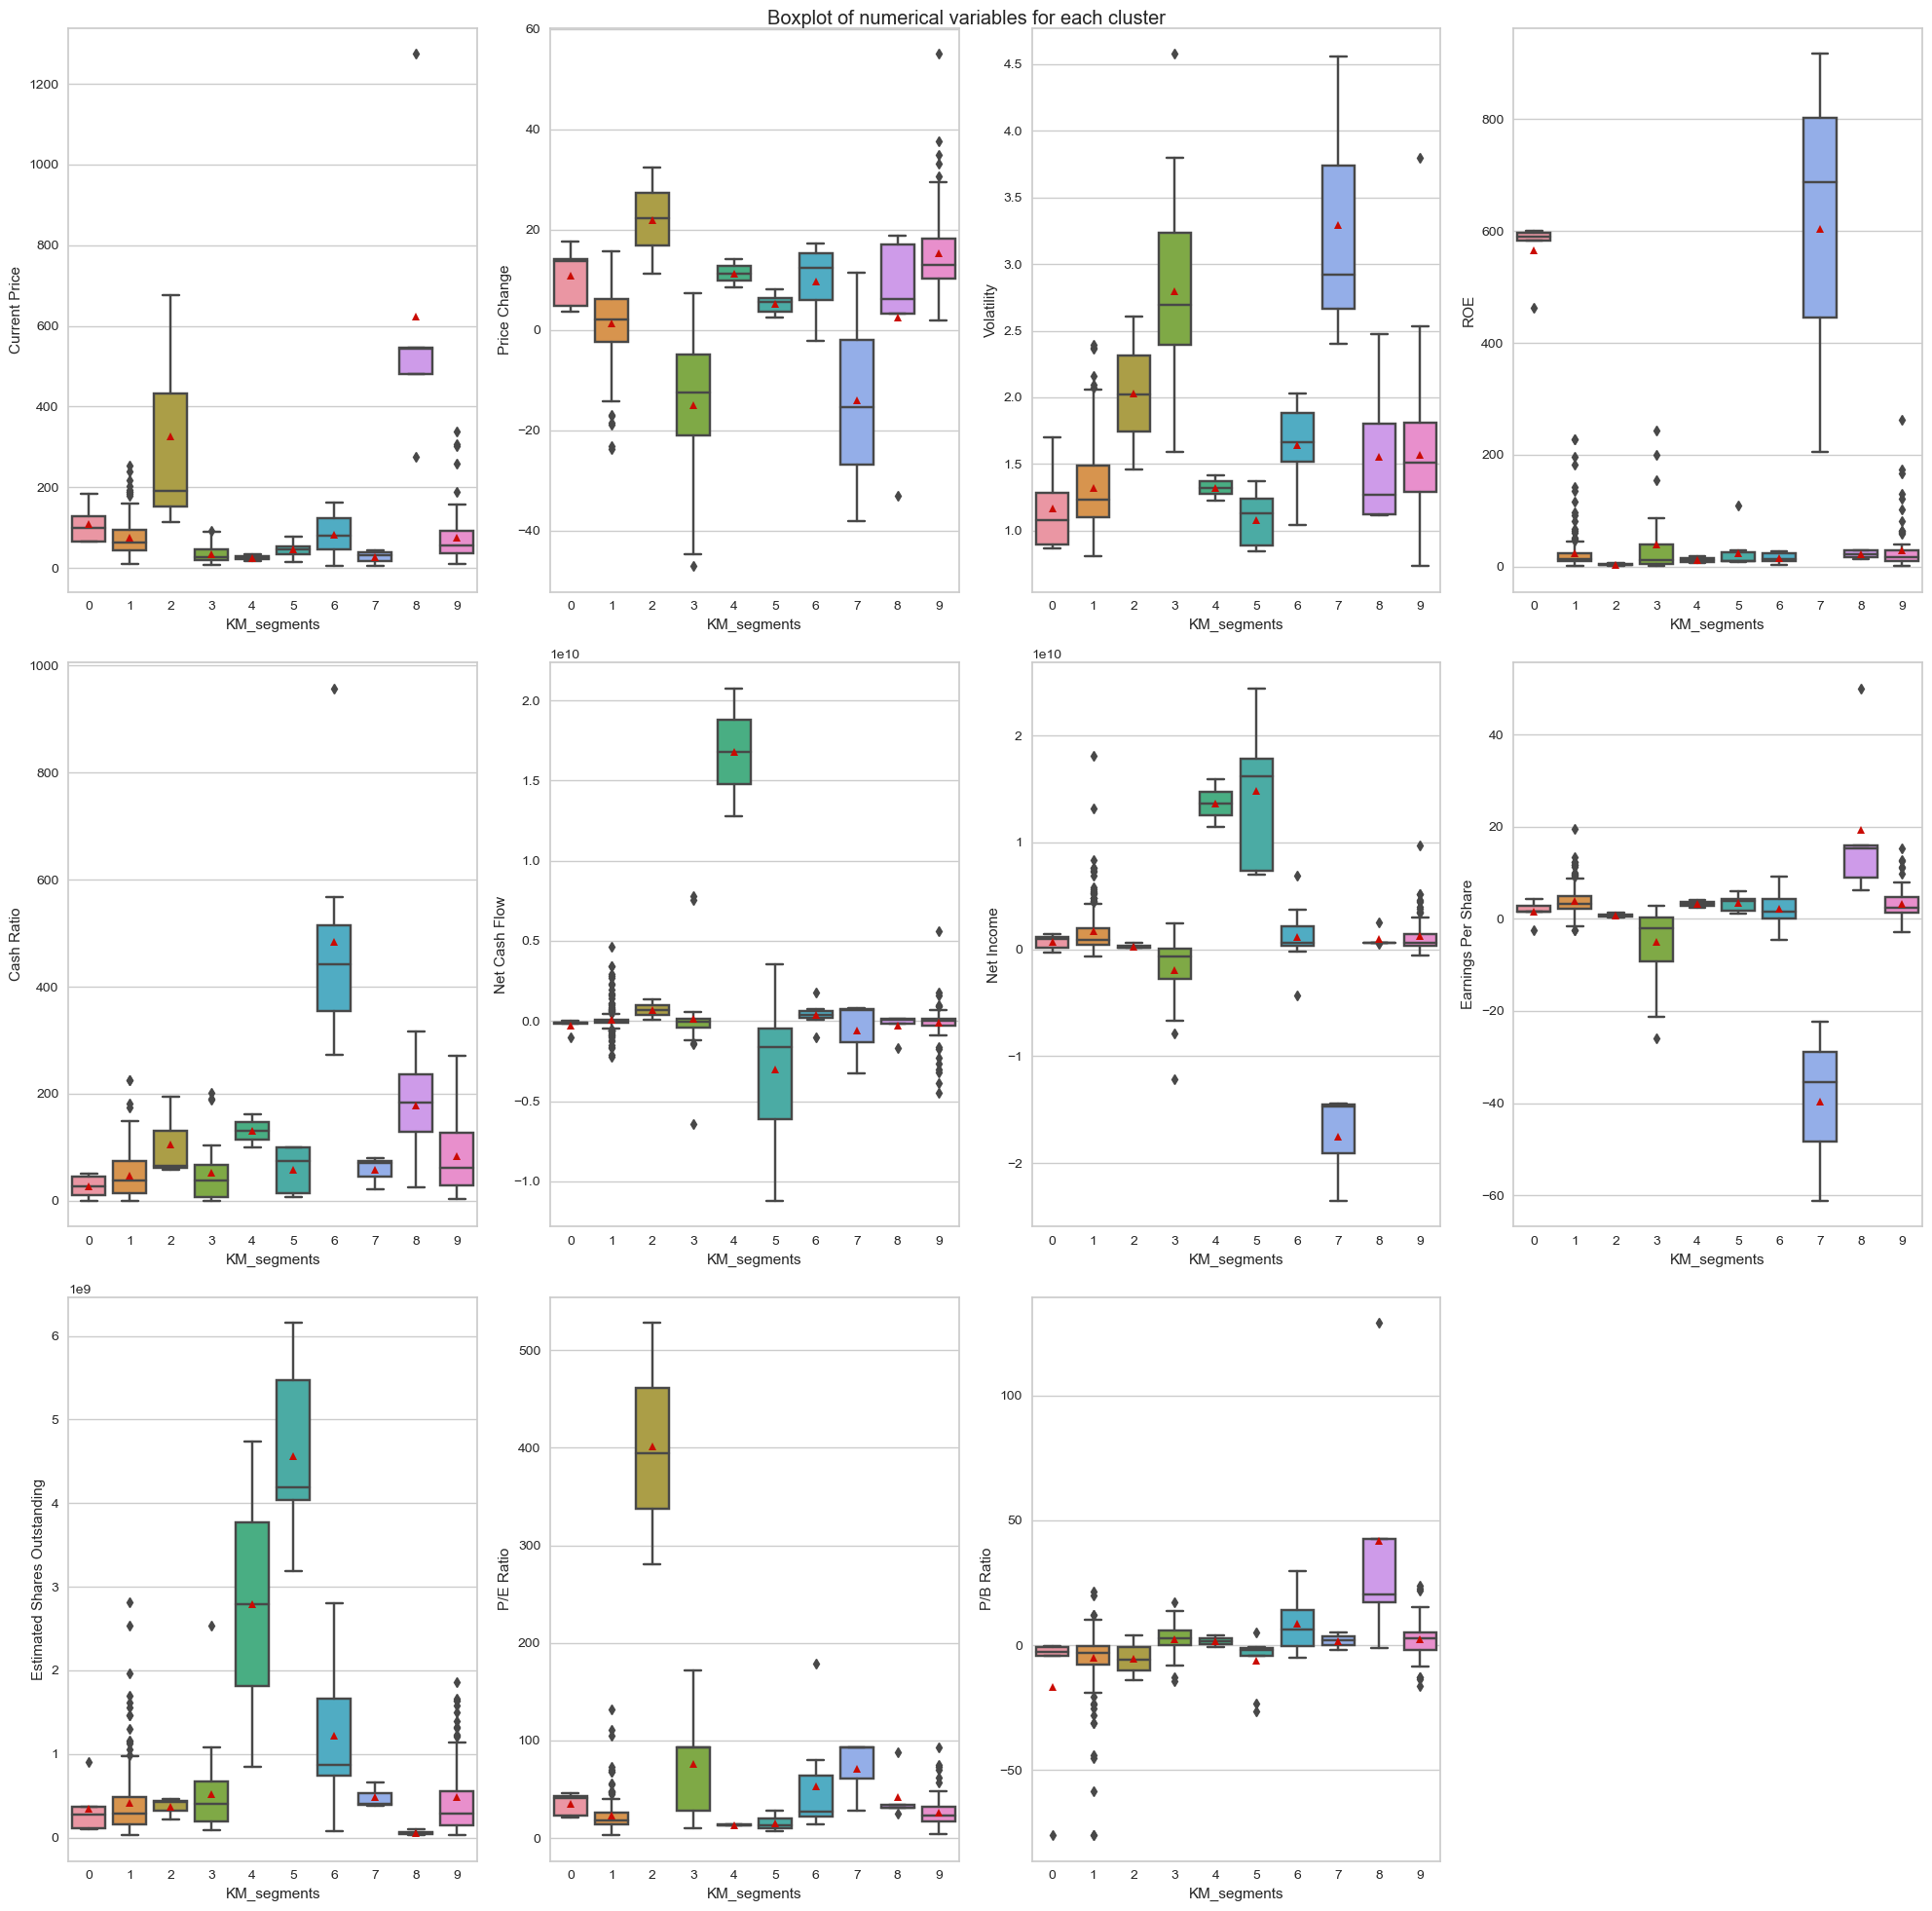

In [62]:
# Cluster profiling the the K-means model for base dataset 
km_cluster_profile_no_dummies = cluster_profiling(df1_no_dummies, "KM_segments")
km_cluster_profile_no_dummies.style.highlight_max(color="lightgreen", axis=0) \
                                    .highlight_min(color="#cd4f39", axis=0)

#### Observations
- The base dataset shows a limited separation of its 10 clusters. 
- The clusters are not uniform and there are outliers along with several extremely small clusters. 
- Cluster 1 is the largest cluster and is significantly larger than all other clusters. 


- **Cluster 0**
> - This cluster contains companies from the Consumer Discretionary,Consumer Staples,Financials and Industrials sectors.
> - The companies in this cluster have the lowest average Cash Ratio and P/B Ratio.
> - This cluster contains 1.47% of the companies.

- **Cluster 1**
> - This cluster contains companies from the Consumer Discretionary, Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services and Utilities sectors.
> - The companies in this cluster have a negative P/B Ratio.
> - This cluster contains 56.17% of the companies.

- **Cluster 2**
> - This cluster contains companies from the Consumer Discretionary, Health Care and the Information Technology sectors.
> - The companies in this cluster have the highest average Price Change/P/E Ratio and the lowest average ROE.
> - This cluster contains .882% of the companies.

- **Cluster 3**
> - This cluster contains companies from the Energy,Industrials,Information Technology and the Materials sectors.
> - The companies in this cluster have the lowest average Price Change (negative) and negative Net Income and Earnings Per Share.
> - This cluster contains 7.94% of the companies.

- **Cluster 4**
> - This cluster contains companies from the Financials and the Information Technology sectors.
> - The companies in this cluster have the highest average Net Cash Flow and the lowest average Current Price and P/E Ratio.
> - This cluster contains .588% of the companies.

- **Cluster 5**
> - This cluster contains companies from the Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care and the Telecommunications Services sectors.
> - The companies in this cluster have the highest average Net Income/Estimated Shares Outstanding and the lowest average Volatility and Net Cash Flow (negative)
> - This cluster contains 2.64% of the companies.

- **Cluster 6**
> - This cluster contains companies from the Consumer Staples,Health Care,Information Technology and the Telecommunications Services sectors.
> - The companies in this cluster have the highest average Cash Ratio.
> - This cluster contains 2.35% of the companies.

- **Cluster 7**
> - This cluster contains companies from the Energy sector.
> - The companies in this cluster have the highest average Volatility/ROE and the lowest average Net Income/Earnings Per Share (both negative).
> - This cluster contains .882% of the companies.

- **Cluster 8**
> - This cluster contains companies from the Consumer Discretionary, Health Care and the Information Technology sectors.
> - The companies in this cluster have the highest average Current Price/Earnings Per Share/PB Ratio and the lowest average Estimated Shares Outstanding. 
> - This cluster contains 1.47% of the companies.

- **Cluster 9**
> - This cluster contains companies from the Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials, Real Estate and the Telecommunications Services sectors.
> - The companies in this cluster have negative Net Cash Flow.
> - This cluster contains 25.58% of the companies.

### Kmeans model selection
- The GICS Sector one encoded clustering has several clusters that have only one GICS Sector. The base dataset clustering does not. 
- The most sectors that the GICS Sector one encoded clustering has is three for the base dataset clustering the max is eleven.

- I choose the the GICS Sector one hot encoded KMeans model because:
> - The clusters are distinct as opposed to the base dataset KMeans.
> - The clusters have a higher average silhouette score than the base dataset KMeans.
> - All the clusters meet or exceed the average silhouette score unlike the base dataset KMeans. 
> - The clusters are uniform in size unlike the base dataset KMeans.

## Hierarchical Clustering

### Computing Cophenetic Correlation

In [63]:
hc_df = subset_scaled_df.copy()
hc_no_dummies_df = subset_scaled_no_dummies_df.copy()

In [64]:
# Calculate cophenetic correlation for the GICS Sector one hot encoded dataset.
calculate_cophenetic_correlation(hc_df)

Cophenetic correlation for Euclidean distance and single linkage is 0.8446298852788628.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7375902712125267.
Cophenetic correlation for Euclidean distance and average linkage is 0.9229834600468654.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9308508564293562.
Cophenetic correlation for Euclidean distance and ward linkage is 0.4965031973977876.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8520207320398556.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7428972274515234.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7851737371469867.
Cophenetic correlation for Chebyshev distance and average linkage is 0.898954856514473.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.877742340393013.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8729512168171691.
Cophenetic correlation

In [65]:
# Calculate cophenetic correlation for the base dataset.
calculate_cophenetic_correlation(hc_no_dummies_df)

Cophenetic correlation for Euclidean distance and single linkage is 0.9232271494002922.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7873280186580672.
Cophenetic correlation for Euclidean distance and average linkage is 0.9422540609560814.
Cophenetic correlation for Euclidean distance and centroid linkage is 0.9314012446828154.
Cophenetic correlation for Euclidean distance and ward linkage is 0.7101180299865353.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8693784298129404.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9062538164750717.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.598891419111242.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9338265528030499.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9127355892367.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.925919553052459.
Cophenetic correlation fo

#### Observations
- The optimal cophenetic correlation score for the GICS Sector one hot encoded dataset is with with Euclidean distance and centroid linkage.
- The optimal cophenetic correlation score for the base dataset is with with Euclidean distance and average linkage.

### Checking Dendrograms

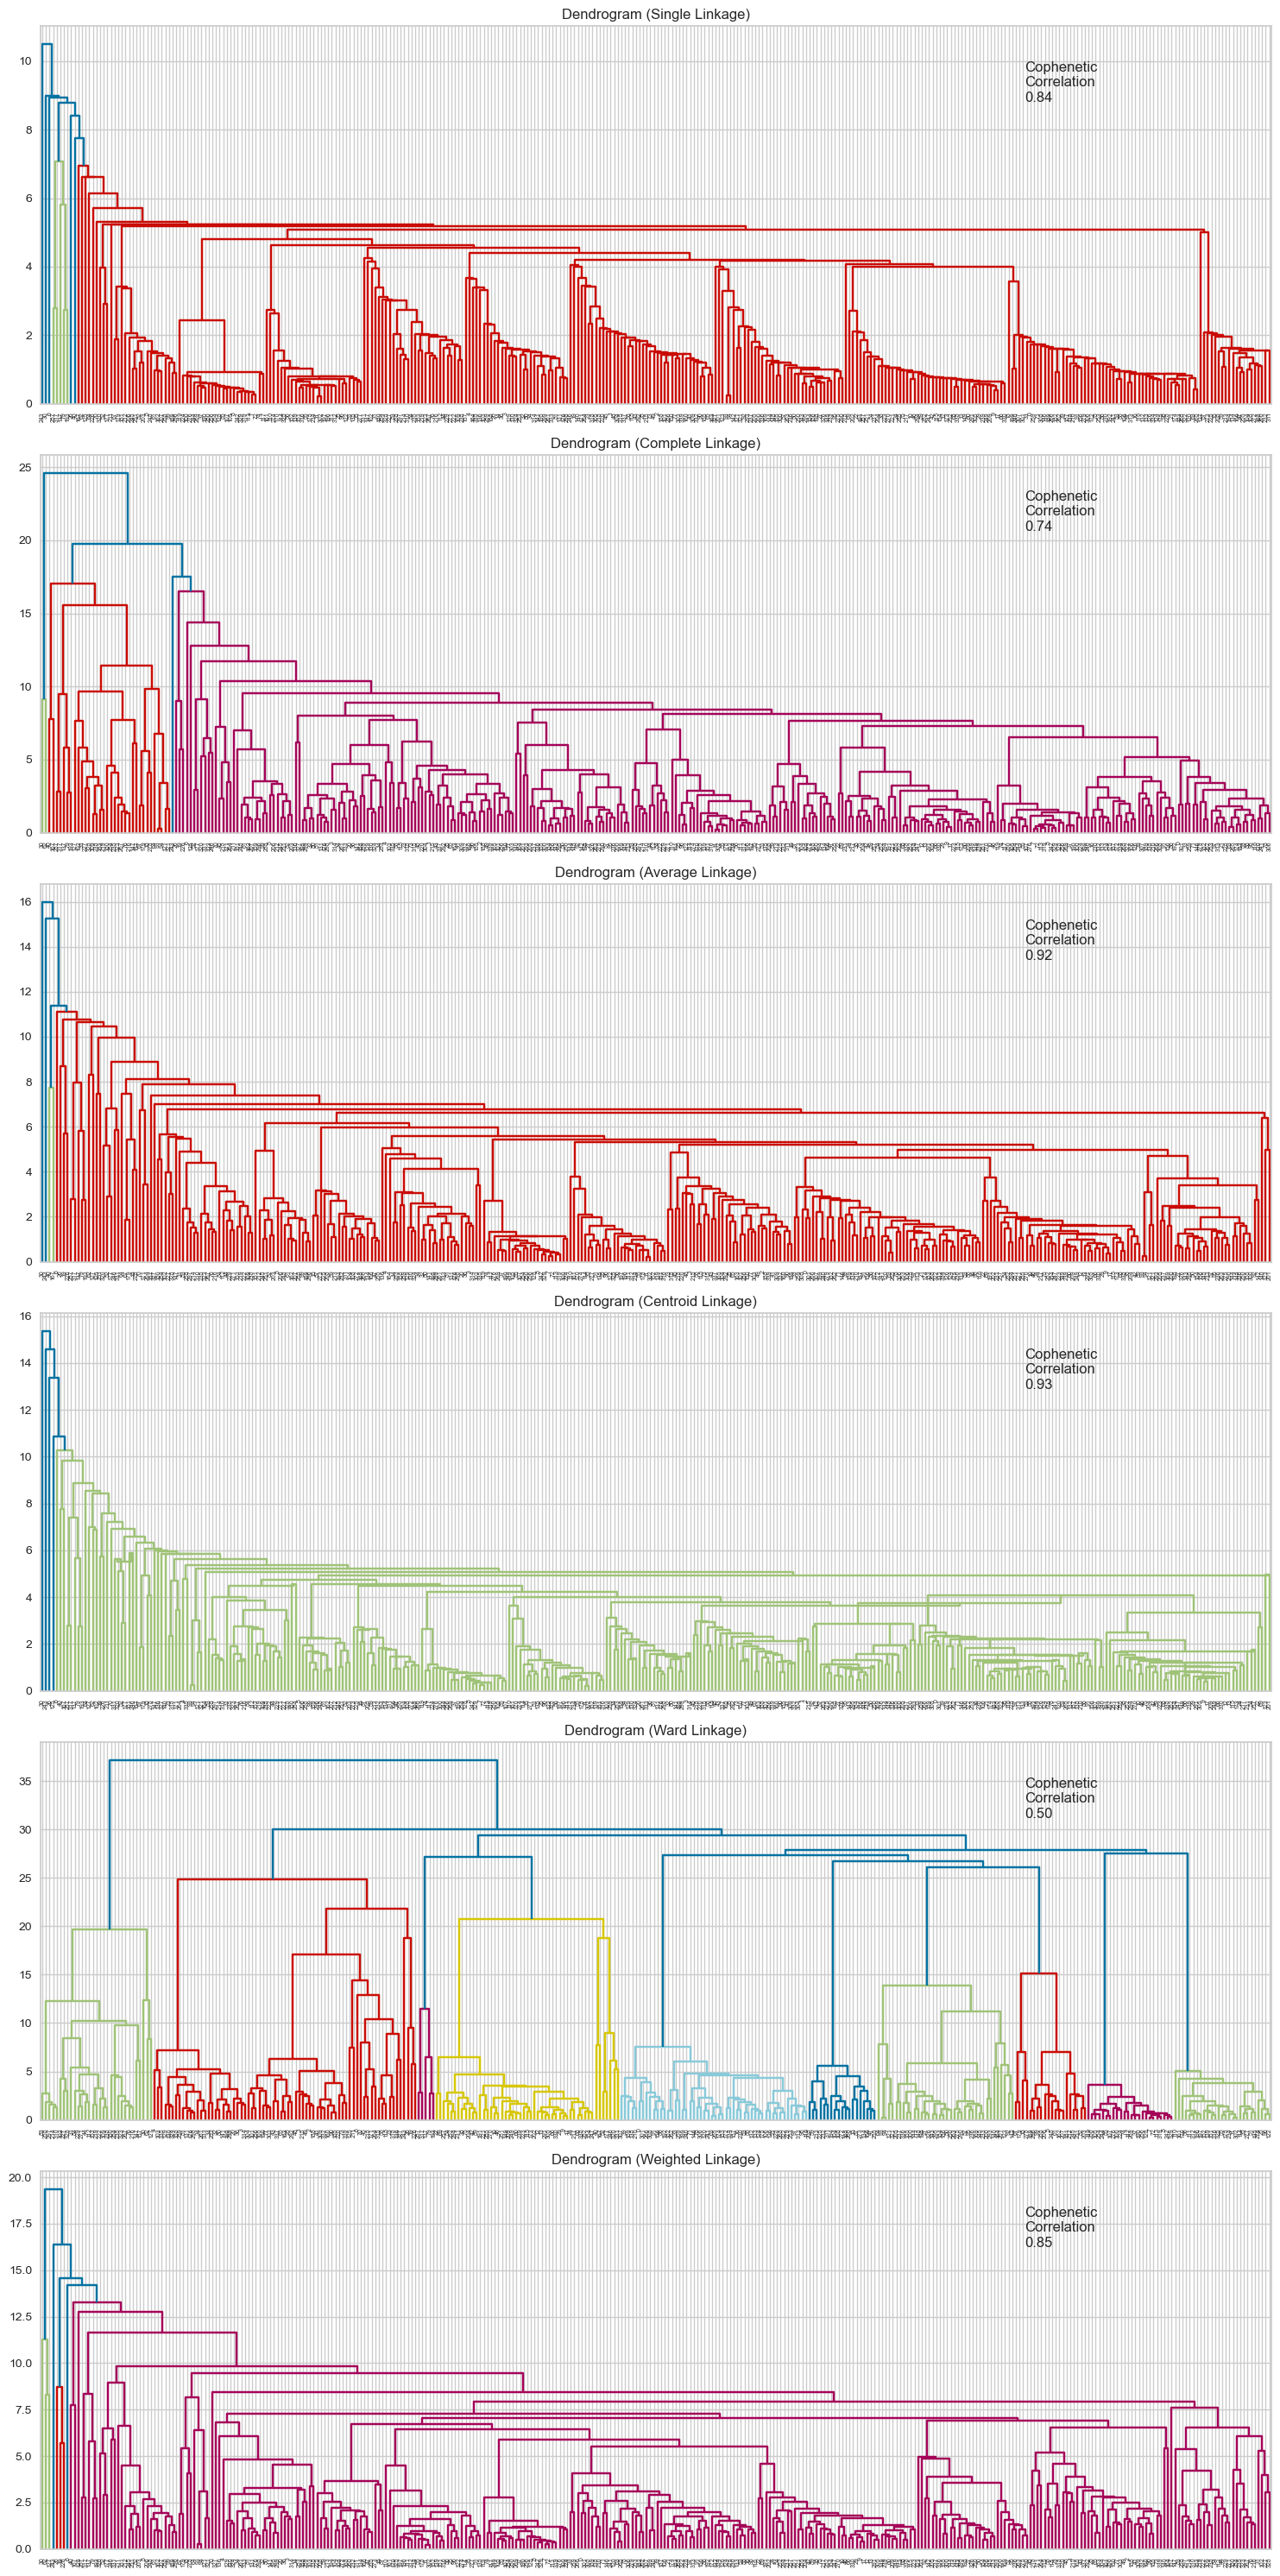

In [66]:
# Output dendrograms for GICS Sector one hot encoded dataset
compare, compare_cols = output_dendrograms(hc_df)

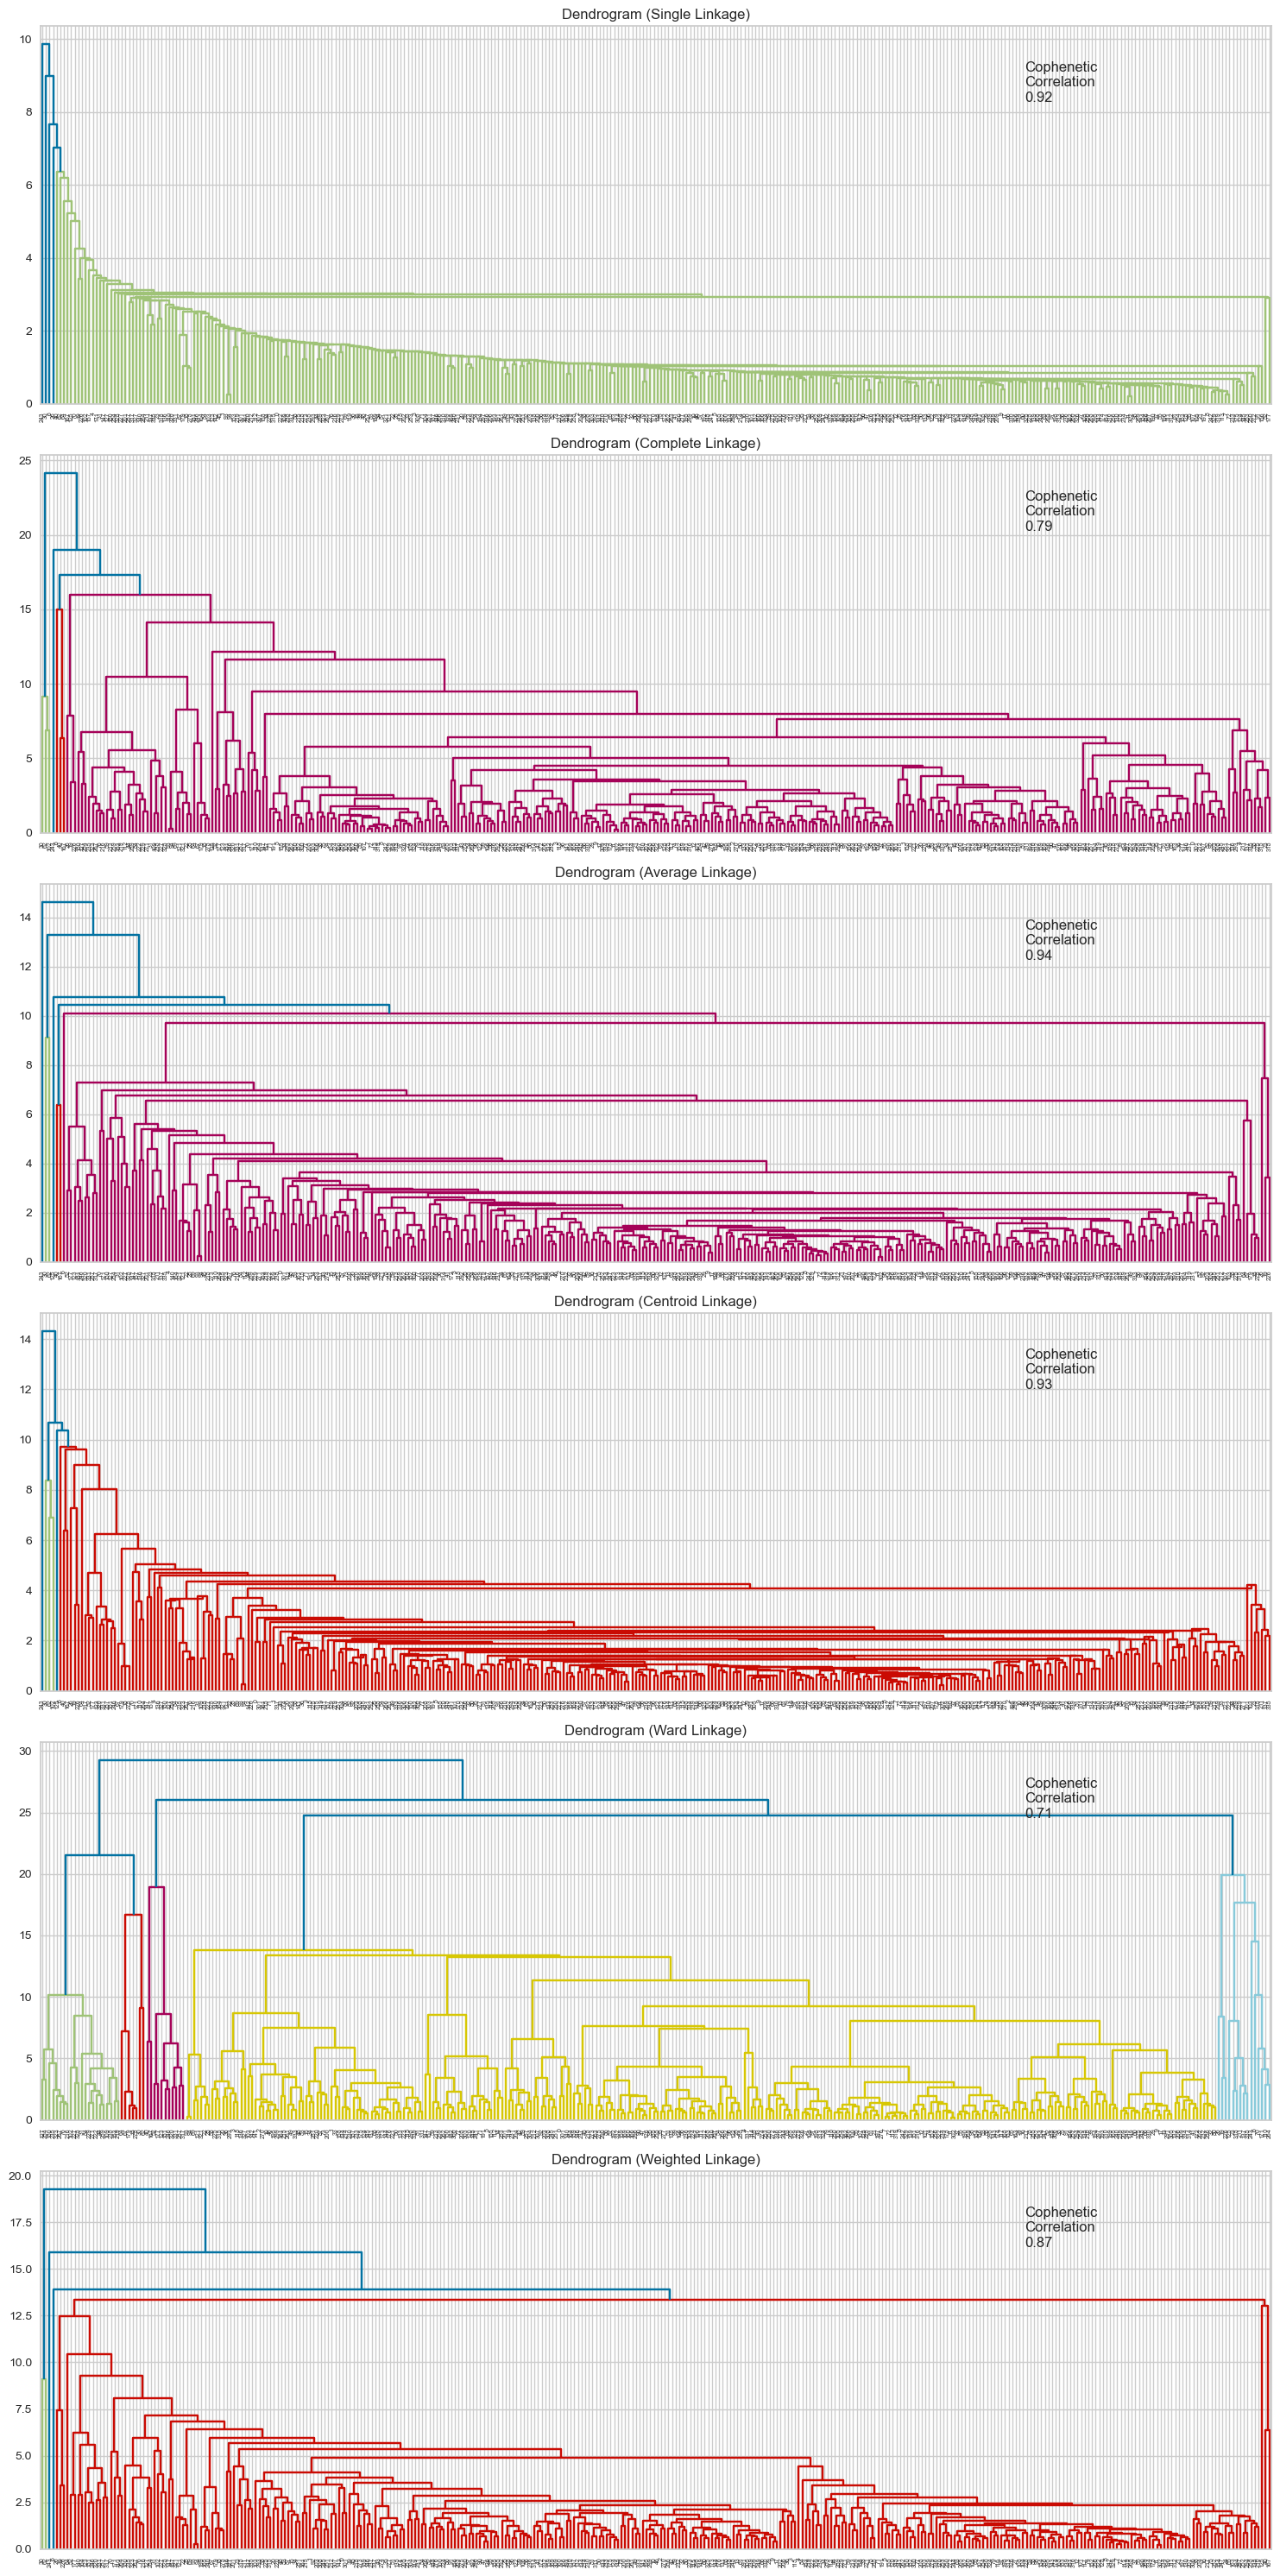

In [67]:
# Output dendrograms for base dataset
compare_no_dummies, compare_no_dummies_cols = output_dendrograms(hc_no_dummies_df)

In [68]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc.sort_values(by='Cophenetic Coefficient', ascending=False)

Linkage  Cophenetic Coefficient
3  centroid                0.930851
2   average                0.922983
5  weighted                0.852021
0    single                0.844630
1  complete                0.737590
4      ward                0.496503

In [69]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc_no_dummies = pd.DataFrame(compare_no_dummies, columns=compare_no_dummies_cols)
df_cc_no_dummies = df_cc_no_dummies.sort_values(by="Cophenetic Coefficient")
df_cc_no_dummies.sort_values(by='Cophenetic Coefficient', ascending=False)

Linkage  Cophenetic Coefficient
2   average                0.942254
3  centroid                0.931401
0    single                0.923227
5  weighted                0.869378
1  complete                0.787328
4      ward                0.710118

#### Observations
- From the dendrograms for the GICS Sector one hot encoded dataset the best cut appears to be around 7. 
- The optimal cophenetic correlation score for the GICS Sector one hot encoded dataset is with with Euclidean distance and centroid linkage.
- We will use average linkage since centroid is not supported by AgglomerativeClustering.


- From the dendrograms for the GICS Sector one hot encoded dataset the best cut appears to be around 8.
- The optimal cophenetic correlation score for the base dataset is with with Euclidean distance and average linkage.

### Creating model using sklearn

In [70]:
# Fit an AgglomerativeClustering model for the GICS Sector one hot encoded dataset.
HCmodel = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='average')
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=7)

In [71]:
# Fit an AgglomerativeClustering model for the base dataset.
HCmodel_no_dummies = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='average')
HCmodel_no_dummies.fit(hc_no_dummies_df)

AgglomerativeClustering(linkage='average', n_clusters=8)

In [72]:
# creating a copy of the original data with dummies
df2 = df.copy()
df2['GICS Sector'] = data['GICS Sector']

# Do tsne feature reduction for visualization
tsne_hc = TSNE(n_components=2, random_state=1).fit_transform(hc_df)
tsne_hc_df = pd.DataFrame(tsne_hc, columns=['Component 1', 'Component 2'])
tsne_hc_df['HC_segments'] = HCmodel.labels_

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_

In [73]:
# creating a copy of the original untouched data
df2_no_dummies = data.copy()

# Do tsne feature reduction for visualization
tsne_hc_no_dummies = TSNE(n_components=2, random_state=1).fit_transform(hc_no_dummies_df)
tsne_hc_no_dummies_df = pd.DataFrame(tsne_hc_no_dummies, columns=['Component 1', 'Component 2'])
tsne_hc_no_dummies_df['HC_segments'] = HCmodel_no_dummies.labels_

# adding hierarchical cluster labels to the original and scaled dataframes
hc_no_dummies_df["HC_segments"] = HCmodel_no_dummies.labels_
df2_no_dummies["HC_segments"] = HCmodel_no_dummies.labels_

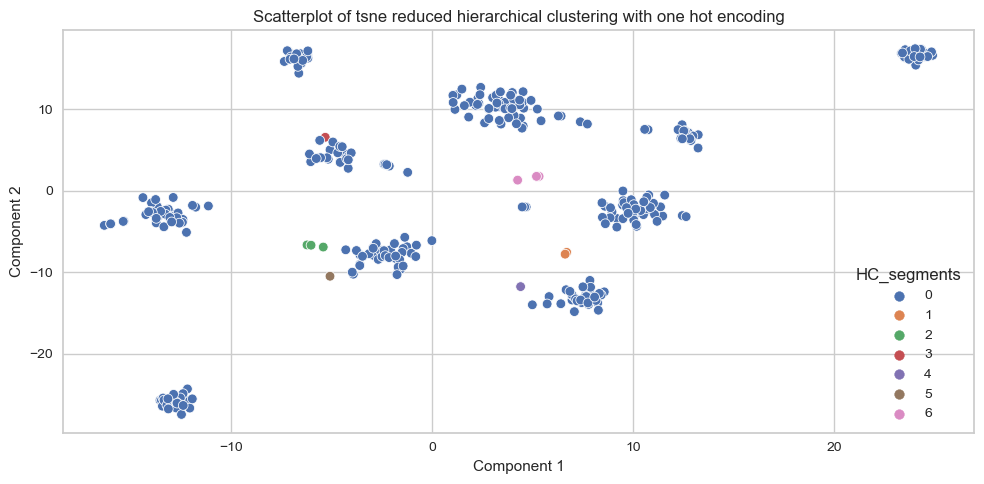

In [74]:
# Scatterplot the tsne reduced hierarchical clustering with one hot encoding
output_pretty_scatterplot(tsne_hc_df, 'Component 1', 'Component 2', hue='HC_segments',\
                          title='Scatterplot of tsne reduced hierarchical clustering with one hot encoding', palette='deep')

#### Observations
- The are distinctions between the clusters in the scatterplot.
- Cluster 0 is by far the largest cluster and is significantly bigger than all other clusters. 
- Cluster 0 contains several subclusters that are spread out through the scatterplot. 
- Clusters 3, 4 and 5 only have one member.
- The clusters are not uniform in size.

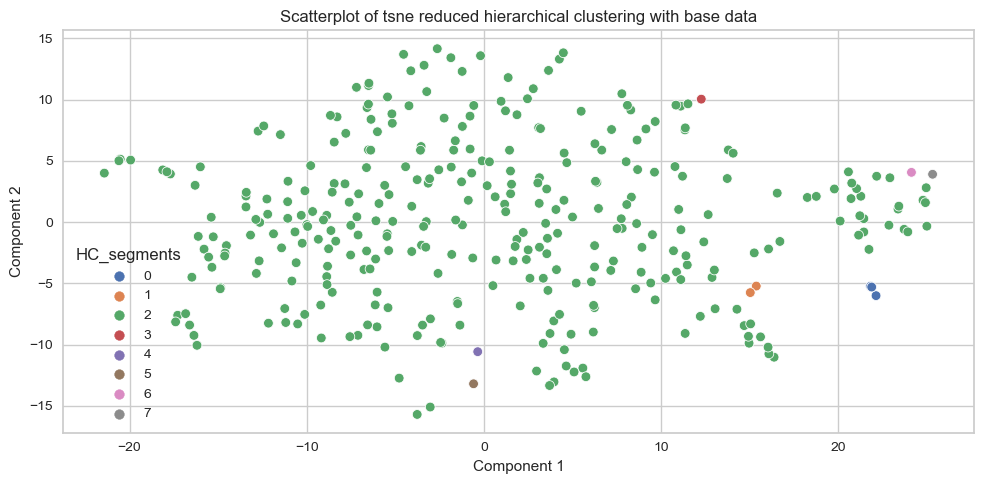

In [75]:
# Scatterplot tsne reduced hierarchical clustering with base data
output_pretty_scatterplot(tsne_hc_no_dummies_df, 'Component 1', 'Component 2', hue='HC_segments',\
                          title='Scatterplot of tsne reduced hierarchical clustering with base data', palette='deep')

#### Observations
- There is not really a clear distinction between the clusters in the scatterplot.
- The clusters are not uniform in size.
- Cluster 2 is the largest cluster and is significantly bigger than all other clusters. 
- Clusters 3-7 have one member.

### Cluster Profiling

In cluster 0, there are 327 total companies shown below:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co'
 'Ameren Corp' 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'Allegion'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Amgen Inc' 'Ameriprise Financial' 'American Tower Corp A'
 'AutoNation Inc' 'Anthem Inc.' 'Aon plc' 'Anadarko Petroleum Corp'
 'Amphenol Corp' 'Arconic Inc' 'Activision Blizzard'
 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Baxter International Inc.' 'BB&T Corporation' 'Bard (C.R.) Inc.'
 'Baker Hughes Inc' 'BIOGEN IDEC Inc.' 'The Bank of New York Mellon Corp.'
 'Ball Corp' 'Bristol-Myers Squibb' 'Boston 

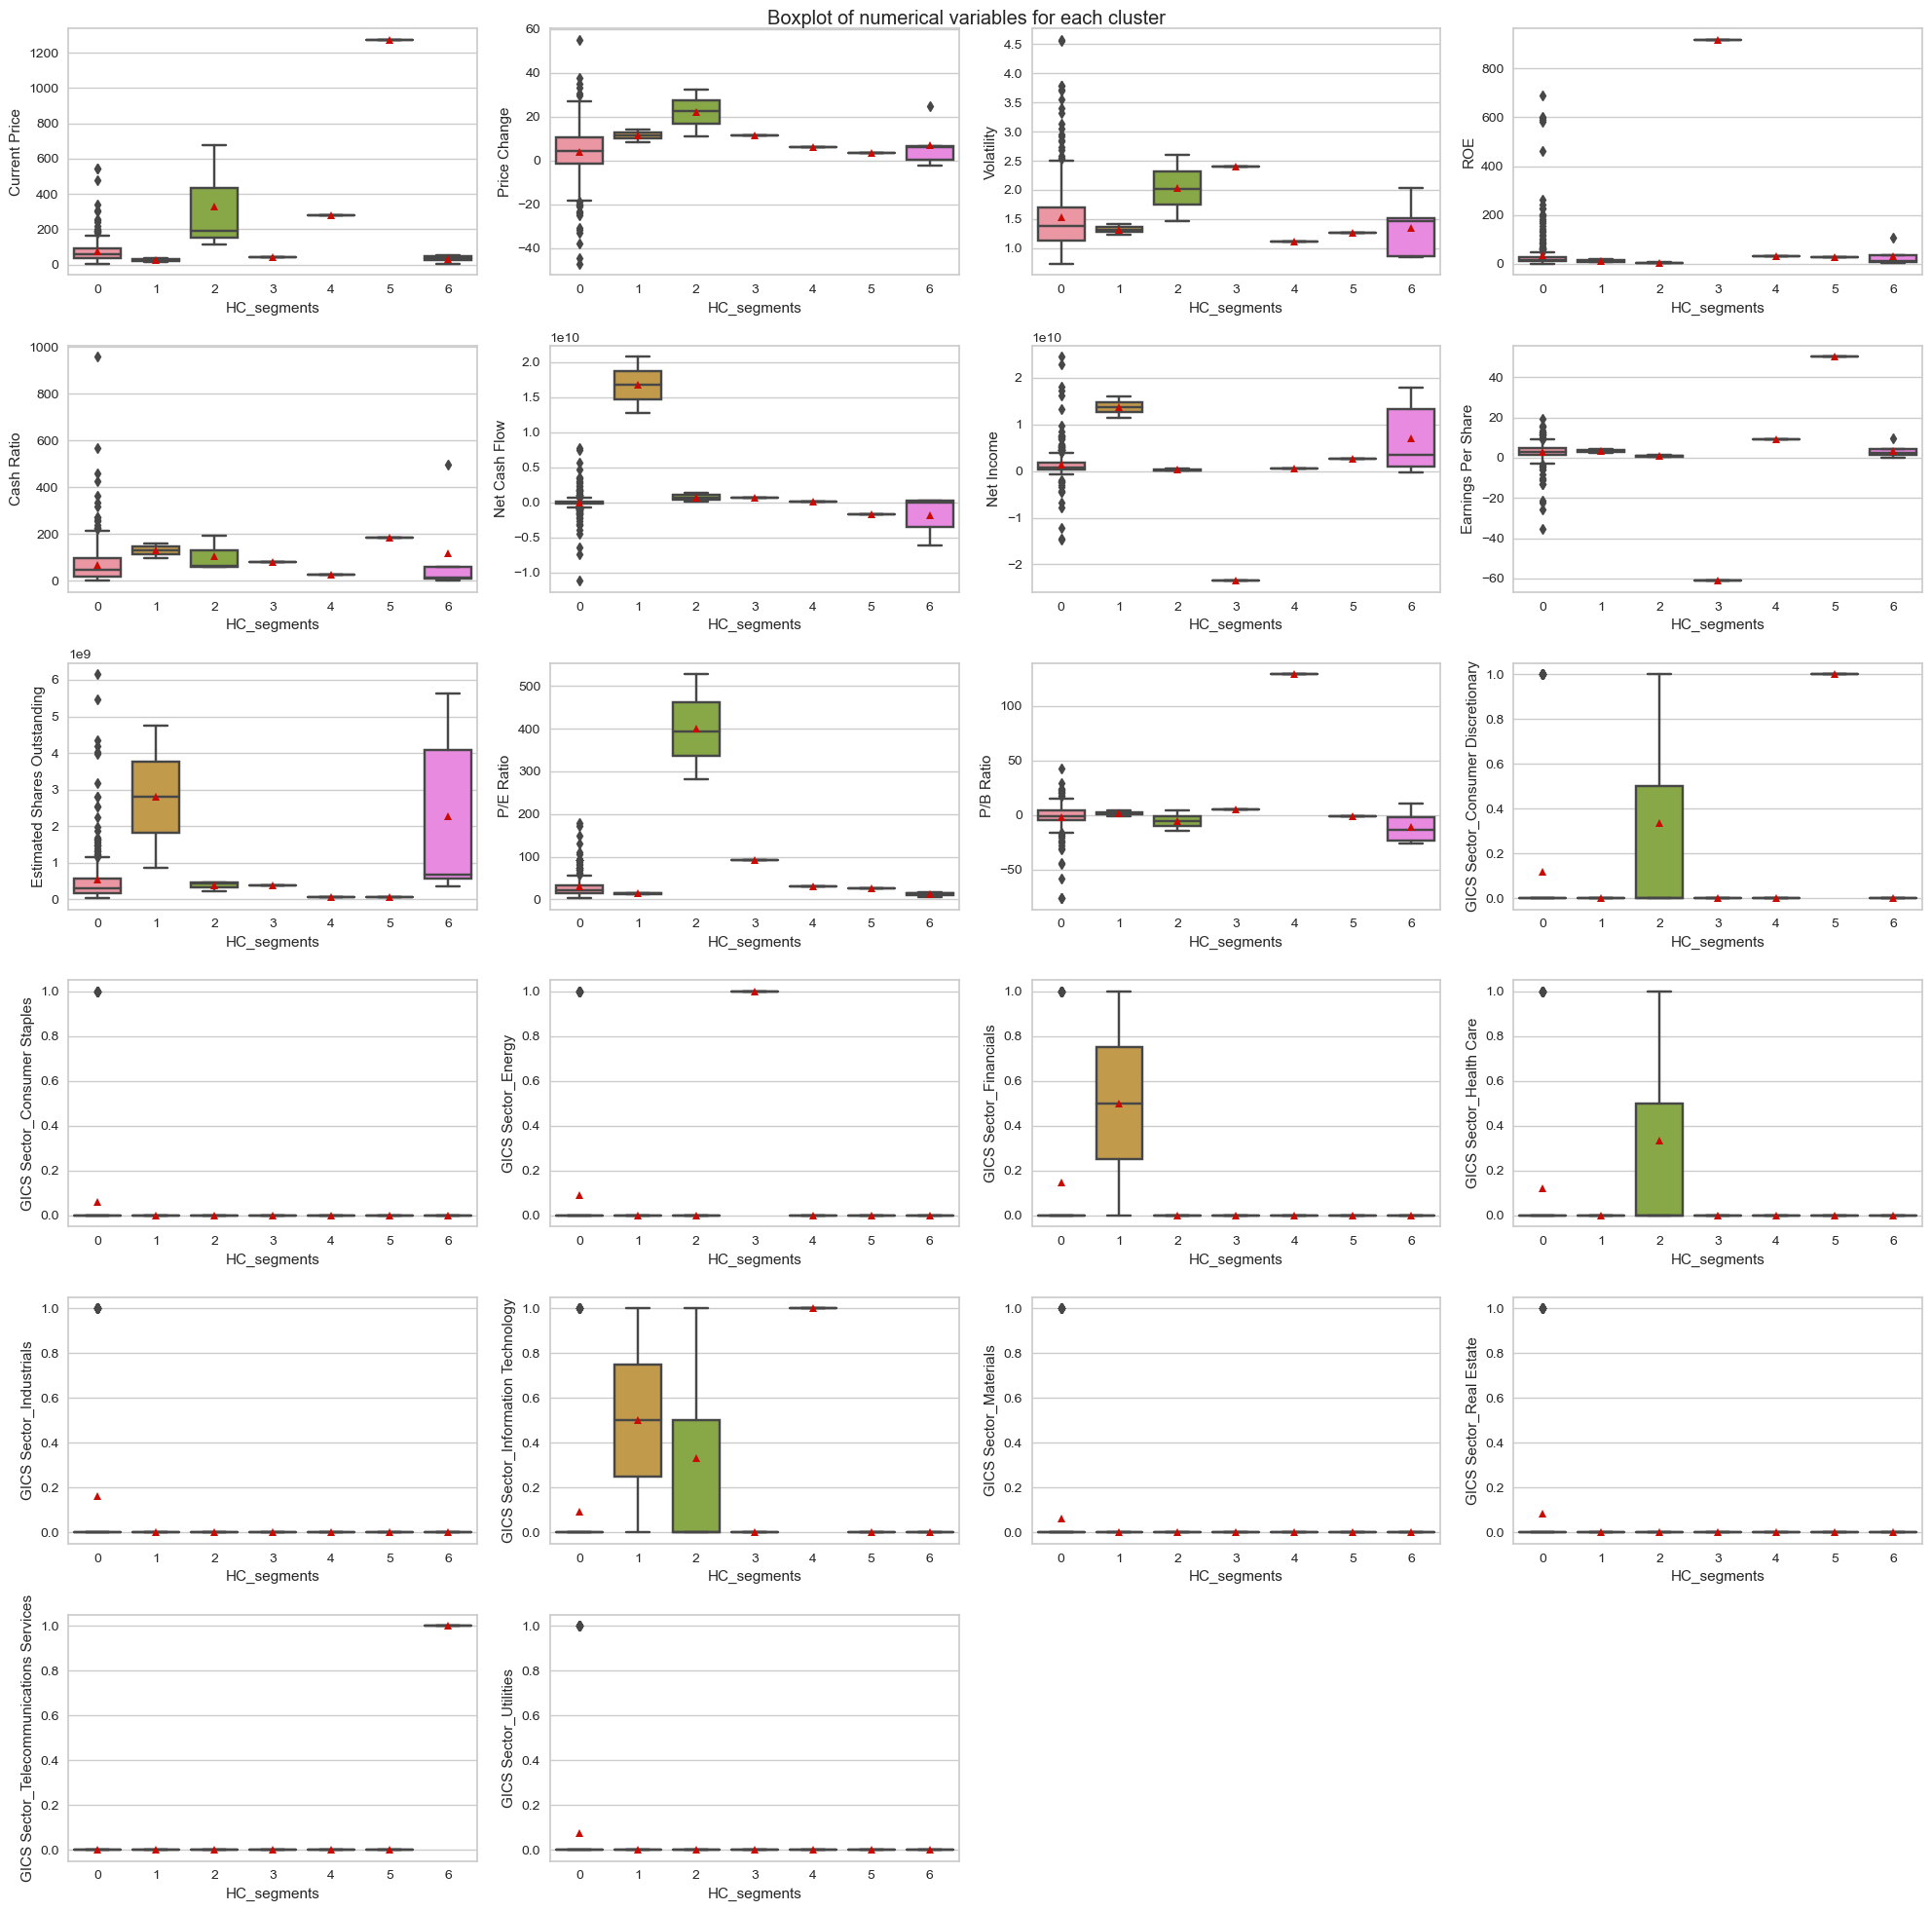

In [76]:
# Cluster profiling for the GICS Sector one hot encoded dataset for hierarchical clustering
hc_cluster_profile = cluster_profiling(df2, "HC_segments")
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0) \
                        .highlight_min(color="#cd4f39", axis=0)

#### Observations
- There are seven clusters in this model.
- The are distinctions between the clusters in the scatterplot.
- Cluster 0 is by far the largest cluster and is significantly bigger than all other clusters. 
- Cluster 0 contains several subclusters that are spread out through the scatterplot. 
- Clusters 3, 4 and 5 only have one member. 

- **Cluster 0**
> - This cluster contains companies from the Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate and Utilities sectors.
> - This cluster has an average Net Cash Flow and P/B Ratio that are negative.
> - This cluster contains 96.17% of the companies.

- **Cluster 1**
> - This cluster contains companies from the Financials and Information Technology sectors.
> - This cluster contains the lowest average Current Price and the highest average Net Cash Flow, Net Income and Estimated Shares Outstanding.
> - This cluster contains .588% of the companies.

- **Cluster 2**
> - This cluster contains companies from the Consumer Discretionary, Health Care and Information Technology sectors.
> - This cluster has the highest average Price Change and P/E Ratio with the lowest average ROE along with a negative P/B Ratio.
> - This cluster contains .882% of the companies.

- **Cluster 3**
> - This cluster contains companies from Energy sector.
> - This cluster has the highest average Volatility and ROE and the lowest average Net Income and Earnings Per Share.
> - This cluster contains .294% of the companies.

- **Cluster 4**
> - This cluster contains companies from the Information Technology sector.
> - This cluster has the lowest average Volatility and Cash Ratio and the highest average P/B Ratio.
> - This cluster contains .294% of the companies.

- **Cluster 5**
> - This cluster contains companies from the Consumer Discretionary sector.
> - This cluster has the highest average Current Price, Cash Ratio and Earnings Per Share along with the lowest average Price Change and Estimated Shares Outstanding.
> - This cluster contains .294% of the companies.

- **Cluster 6**
> - This cluster contains companies from the Telecommunication Services sector.
> - This cluster has the lowest average Net Cash Flow, P/E Ratio and P/B Ratio (negative)
> - This cluster contains 1.47% of the companies.

In cluster 2, there are 330 total companies shown below:
['American Airlines Group' 'AbbVie' 'Abbott Laboratories'
 'Adobe Systems Inc' 'Analog Devices, Inc.' 'Archer-Daniels-Midland Co'
 'Ameren Corp' 'American Electric Power' 'AFLAC Inc'
 'American International Group, Inc.' 'Apartment Investment & Mgmt'
 'Assurant Inc' 'Arthur J. Gallagher & Co.' 'Akamai Technologies Inc'
 'Albemarle Corp' 'Alaska Air Group Inc' 'Allstate Corp' 'Allegion'
 'Applied Materials Inc' 'AMETEK Inc' 'Affiliated Managers Group Inc'
 'Amgen Inc' 'Ameriprise Financial' 'American Tower Corp A'
 'AutoNation Inc' 'Anthem Inc.' 'Aon plc' 'Anadarko Petroleum Corp'
 'Amphenol Corp' 'Arconic Inc' 'Activision Blizzard'
 'AvalonBay Communities, Inc.' 'Broadcom'
 'American Water Works Company Inc' 'American Express Co' 'Boeing Company'
 'Baxter International Inc.' 'BB&T Corporation' 'Bard (C.R.) Inc.'
 'Baker Hughes Inc' 'BIOGEN IDEC Inc.' 'The Bank of New York Mellon Corp.'
 'Ball Corp' 'Bristol-Myers Squibb' 'Boston 

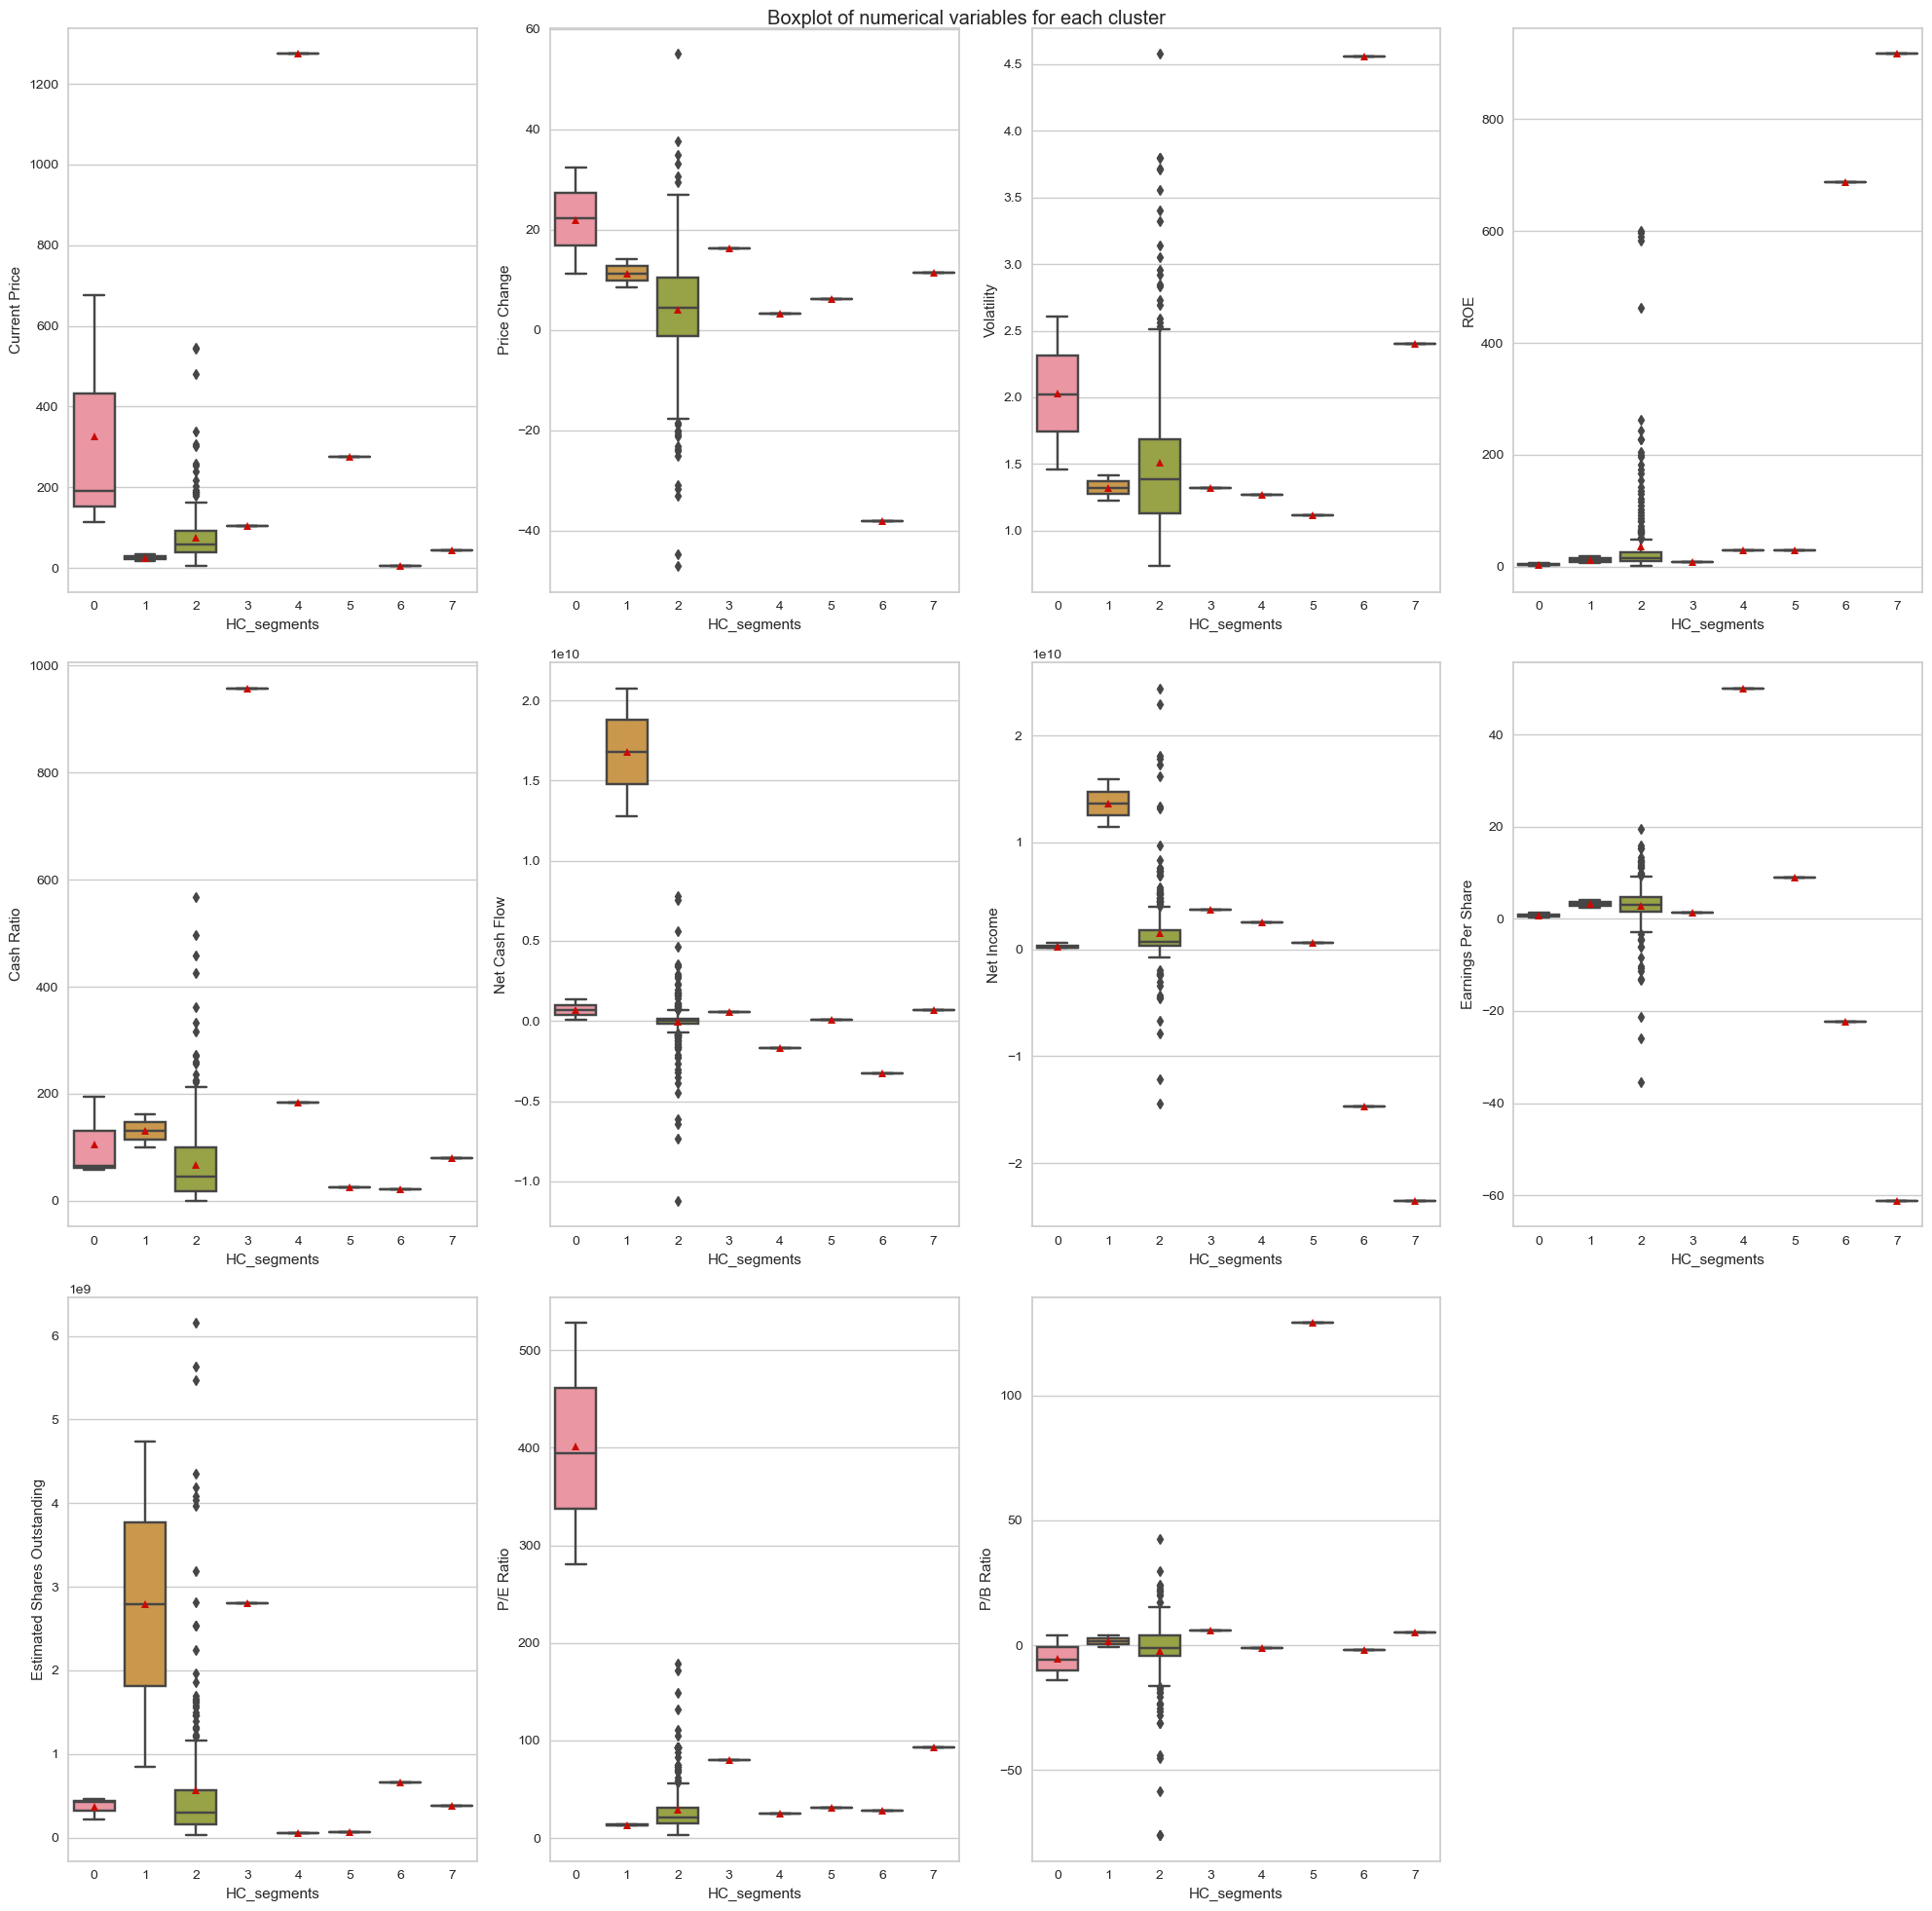

In [77]:
# Cluster profiling for the base dataset for hierarchical clustering
hc_cluster_profile_no_dummies = cluster_profiling(df2_no_dummies, "HC_segments")
hc_cluster_profile_no_dummies.style.highlight_max(color="lightgreen", axis=0) \
                                    .highlight_min(color="#cd4f39", axis=0)

#### Observations
- There are eight clusters in this model.
- There is not really a clear distinction between the clusters from the scatterplot.
- The clusters are not uniform in size.
- Cluster 2 is the largest cluster and is significantly bigger than all other clusters. 
- Clusters 3, 4, 5, 6 and 7 only have one member.
- There are several clusters that repeat the same GICS Sector and that is the only member of the cluster (e.g. Cluster 6/7 both have Energy and Cluster 3/5 both have Information Technology exclusively.)


- **Cluster 0**
> - This cluster contains companies from the Consumer Discretionary,Health Care and Information Technology sectors.
> - This cluster has the highest average Price Change and P/E Ratio and the lowest average ROE and P/B Ratio. 
> - This cluster contains .882% of the companies.

- **Cluster 1**
> - This cluster contains companies from the Financials and Information Technology sectors.
> - This cluster has the highest average Net Cash Flow and Net Income and the lowest average P/E Ratio.
> - This cluster contains .588% of the companies.

- **Cluster 2**
> - This cluster contains companies from the Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services and Utilities sectors.
> - This cluster has negative Net Cash Flow and P/B Ratio.
> - This cluster contains 97.05% of the companies.

- **Cluster 3**
> - This cluster contains companies from the Information Technology sector.
> - This cluster contains the highest average Cash Ratio and Estimated Shares Outstanding.
> - This cluster contains .294% of the companies.

- **Cluster 4**
> - This cluster contains companies from the Consumer Discretionary sector.
> - This cluster has the highest average Current Price and Earnings Per Share and the lowest average Estimated Shares Outstanding along with a negative P/B Ratio.
> - This cluster contains .294% of the companies.

- **Cluster 5**
> - This cluster contains companies from the Information Technology sector.
> - This cluster has the highest average P/B Ratio and the lowest average volatility.
> - This cluster contains .294% of the companies.

- **Cluster 6**
> - This cluster contains companies from the Energy sector.
> - This cluster has the highest average Volatility and the lowest average Current Price, Price Change (negative), Cash Ratio and Net Cash Flow along with a negative P/B Ratio.
> - This cluster contains .294% of the companies.

- **Cluster 7**
> - This cluster contains companies from the Energy sector.
> - This cluster has the highest average ROE and the lowest average Net Income (negative) and Earnings Per Share (negative).
> - This cluster contains .294% of the companies.

### Hierarchical model selection
- Neither of the Hierarchical Clustering models are optimal.
- Both models have clusters that contain Energy, Information Technology and Energy exclusively as members.


- Of the two suboptimal models I choose the the GICS Sector one hot encoded Hierarchical Clustering model because:
> - The clusters are distinct as opposed to the base dataset Hierarchical Clustering.
> - The Cophenetic Coefficients are about the same for the two models.
> - The GICS Sector one hot encoded Hierarchical Clustering model has fewer clusters with a single member. 

## K-means vs Hierarchical Clustering

You compare several things, like:
- Which clustering technique took less time for execution?
- Which clustering technique gave you more distinct clusters, or are they the same?
- How many observations are there in the similar clusters of both algorithms?
- How many clusters are obtained as the appropriate number of clusters from both algorithms?

You can also mention any differences or similarities you obtained in the cluster profiles from both the clustering techniques.

### Final Model Selection
- The final two models:
> - KMeans clustering using GISC Sector one hot encoded dataset
> - Hierarchical clustering using GISC Sector one hot encoded dataset
- Both have Information Technology and Consumer Discretionary as clusters where they are the exclusive members.
- I choose KMeans clustering using GISC Sector one hot encoded dataset because it has more distinct clusters that are more uniform in size.


## Actionable Insights and Recommendations
* The KMeans clustering using GISC Sector one hot encoded dataset there are nine clusters has been selected as the most optimal model with details below:
> - The clusters are distinct as opposed to the base dataset KMeans and all Hierarchical Clustering models.
> - The clusters have a higher average silhouette score than the base dataset KMeans.
> - All the clusters meet or exceed the average silhouette score unlike the base dataset KMeans. 
> - The clusters are uniform in size unlike the base dataset KMeans and all Hierarchical Clustering models.

- **Cluster 0**
> - Contains companies from the Information Technology sector exclusively.
> - This cluster contains the highest average Cash Ratio, Net Cash Flow and P/B Ratio for companies.
> - There three metrics indicate that members are considered financially stable, have a strong financial position and have strong growth potential.
> - This cluster contains 9.7% of the companies.

- **Cluster 1**
> - Contains companies from the Energy, Industrials and Materials sectors.
> - This cluster contains the lowest average Net Cash Flow for companies.
> - This cluster contains a negative P/B Ratio  which may indicate the market has overvalued these companies.
> - This cluster contains 22.64% of the companies.

- **Cluster 2**
> - Contains companies from the Energy, Financials and Telecommunications Services sectors.
> - This cluster contains the highest average Net Income along with the lowest P/E Ratio for companies. 
> - This cluster contains a negative P/B Ratio  which may indicate the market has overvalued these companies.
> - These two metrics indicate the companies are financially healthy and that the companies could be considered undervalued by the market.
> - This cluster contains 16.17% of the companies.
			
- **Cluster 3**
> - Contains companies from the Real Estate sector exclusively.
> - This cluster has the lowest average Estimated Shares Outstanding which could be indicative of closely held companies. 
> - This cluster contains a negative P/B Ratio  which may indicate the market has overvalued these companies.
> - This cluster contains 7.94% of the companies.

- **Cluster 4**
> - Contains companies from the Consumer Discretionary sector exclusively.
> - This cluster has the lowest average P/B Ratio (negative) which may indicate the market has overvalued these companies.
> - This cluster contains 11.76% of the companies.

- **Cluster 5**
> - Contains companies from the Utilities sector exclusively.
> - This cluster contains companies with the lowest average volatility, ROE and Cash Ratio. 
> - This cluster contains a negative P/B Ratio.
> - This could indicate the companies are stable in terms of stock price, have limited return and have a 
low amount of cash or equivalents on hand in relation to liabilities.
> - This cluster contains 7.05% of the companies.

- **Cluster 6**
> - Contains companies from the Energy and Materials sectors.
> - This cluster contains the highest average Volatility, ROE and P/E Ratio for companies.
> - This cluster contain the lowest average Current Price, Price Change (negative), Net Income (negative) and Earnings Per Share. 
> - This cluster contains a negative Net Cash Flow.
> - Companies in this cluster have both positive and negative financial indicators shown by the high volatility.
profitable 
> - This cluster contains 7.35% of the companies.
			
- **Cluster 7**
> - Contains companies from the Consumer Staples sector exclusively.
> - This cluster contains the highest average Estimated Shares outstanding for companies.
> - This cluster contains a negative P/B Ratio which may indicate the market has overvalued these companies.
> - This cluster contains 5.58% of the companies.

- **Cluster 8**
> - Contains companies from the Health Care sector exclusively.
> - This cluster contains the highest average Current Price, Price Change and Earnings Per Share of companies.
> - These metrics could indicate that investors are willing to pay a premium for the companies and that the companies are producing considerable profit per share.
> - This cluster contains 11.76% of the companies.

### Data Insights
* The top GICS sector is Industrials which comprise 15.5% of the companies in the dataset.
* The top three GICS Sector's are Industrials, Finanicals and Health Care.
* The smallest GICS Sector is Telecommunication Services which comprises only 1.4% of the companies.


* The Consumer Discretionary sector has a negative average P/B Ratio and has the fourth highest average ROE and Volatility of all sectors.
* The Consumer Staples sector has a negative average P/B Ratio, has the third highest average Net Income and Net Cash Flow and the second highest average ROE of all the sectors.
* The Energy sector has the highest average Volatility, ROE and P/E Ratio along with the lowest average Price Change, Net Income and Earnings Per Share of all the sectors. 
* The Financials sector has a negative average P/B Ratio along with the fourth highest average Net Cash Flow/Earnings Per Share and the second highest average Net Income of all the sectors.
* The Health Care sector has the highest average Current Price, Price Change and Earnings Per Share of all the sectors.
* The Industrials sector has a negative P/B Ratio and Net Cash Flow and the third highest average ROE/Earnings Per Share of all the sectors.
* The Information Technology sector has the highest average Cash Ratio, Net Cash Flow and P/B Ratio of all the sectors.
* The Materials sector has a negative average Net Cash Flow and the lowest average Estimated Shares Outstanding.
* The Real Estate sector has a negative average P/B Ratio and the third highest average Current Price of all the sectors.
* The Telecommunications Services sector has the highest average Net Income/Estimated Shares Outstanding and the lowest average Current Price, Net Cash Flow, P/E Ratio and P/B Ratio of all the sectors.
* The Utilities sector has a negative average P/B Ratio and the lowest average Volatility, ROE and Cash Ratio of all the sectors.

#### Further analysis that can be done:
* Acquire more than thirteen weeks of data in order to provide further insights into the most appropriate clustering for your business.